In [115]:
# Helper: verify images are readable by PIL
from PIL import Image as PilImage

def check_image_paths(paths, max_checks=50):
    """Check if image files are readable by PIL. Returns list of (path, error) for bad files."""
    bad = []
    for i, p in enumerate(paths):
        if i >= max_checks:
            break
        try:
            with PilImage.open(p) as im:
                im.verify()  # verify can still leave the file open; use context manager
        except Exception as e:
            bad.append((p, repr(e)))
    print(f"Checked {min(len(paths), max_checks)} paths, bad={len(bad)}")
    return bad

### Import Library

In [49]:
import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchvision import transforms, datasets, models
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader
import timm
import copy
from torch.optim import lr_scheduler

### Device Selection

In [50]:
# Device selection and GPU diagnostics
def print_gpu_info():
    import subprocess, shutil

    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("Device:", device)
        print("CUDA available:", True)
        try:
            print("CUDA Version:", torch.version.cuda)
        except Exception:
            pass
        try:
            print("cuDNN Version:", torch.backends.cudnn.version())
        except Exception:
            pass
        try:
            print("GPU count:", torch.cuda.device_count())
            for i in range(torch.cuda.device_count()):
                try:
                    print(f"GPU {i} name:", torch.cuda.get_device_name(i))
                except Exception:
                    pass
        except Exception:
            pass

        # Try to show nvidia-smi output if available
        try:
            if shutil.which("nvidia-smi"):
                print(subprocess.check_output(["nvidia-smi"]).decode())
        except Exception as e:
            print("Could not run nvidia-smi:", str(e))

    else:
        device = torch.device("cpu")
        print("CUDA not available. Device set to CPU.")
        print("If you have an NVIDIA GPU, install a CUDA-enabled PyTorch build and proper drivers.")
        print("See https://pytorch.org/get-started/locally for recommended install commands.")

    return device

# Set device and show diagnostics
device = print_gpu_info()

Device: cuda
CUDA available: True
CUDA Version: 13.0
cuDNN Version: 91200
GPU count: 1
GPU 0 name: NVIDIA GeForce RTX 3060 Ti
Fri Dec 19 14:14:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.57                 Driver Version: 581.57         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   48C    P8             30W /  200W |    7915MiB /   8192MiB |      0%      Default |
|             

In [51]:
# GPU / PyTorch diagnostic — run this cell and paste its output here
import torch, subprocess, shutil, sys

print("Python executable:", sys.executable)
print("Torch version:", getattr(torch, "__version__", None))
print("Torch CUDA version (torch.version.cuda):", torch.version.cuda)
print("torch.cuda.is_available():", torch.cuda.is_available())
print("torch.cuda.device_count():", torch.cuda.device_count())
if torch.cuda.device_count() > 0:
    for i in range(torch.cuda.device_count()):
        try:
            print(f"GPU {i} name:", torch.cuda.get_device_name(i))
        except Exception as e:
            print(f"Could not get device name for GPU {i}: {e}")

print("shutil.which('nvidia-smi'):", shutil.which("nvidia-smi"))
if shutil.which("nvidia-smi"):
    try:
        print(subprocess.check_output(["nvidia-smi"]).decode())
    except Exception as e:
        print("nvidia-smi error:", e)

# Show pip-installed torch details
try:
    print(subprocess.check_output([sys.executable, "-m", "pip", "show", "torch"]).decode())
except Exception as e:
    print("pip show torch error:", e)

# Basic CUDA driver check via nvcc if available
print("nvcc available:", shutil.which("nvcc"))

Python executable: d:\Gallblader-Cancer-Detection-DL\venv\Scripts\python.exe
Torch version: 2.9.1+cu130
Torch CUDA version (torch.version.cuda): 13.0
torch.cuda.is_available(): True
torch.cuda.device_count(): 1
GPU 0 name: NVIDIA GeForce RTX 3060 Ti
shutil.which('nvidia-smi'): C:\WINDOWS\system32\nvidia-smi.EXE
Fri Dec 19 14:14:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.57                 Driver Version: 581.57         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVID

In [52]:
# Helper: suggest commands to install a CUDA-enabled PyTorch based on system CUDA
import re, subprocess, shutil, sys

# Try extract CUDA version from nvidia-smi
cuda_ver = None
if shutil.which("nvidia-smi"):
    try:
        out = subprocess.check_output(["nvidia-smi"]).decode()
        m = re.search(r"CUDA Version:\s*([\d.]+)", out)
        if m:
            cuda_ver = m.group(1)
    except Exception:
        pass

if torch.version.cuda is None and cuda_ver:
    print(f"Detected system CUDA: {cuda_ver} but current PyTorch is CPU-only (torch.version.cuda is None).\n")
    print("Recommended install commands (choose one):\n")
    print("Conda (recommended if you use conda):")
    print(f"conda install pytorch torchvision torchaudio pytorch-cuda={cuda_ver} -c pytorch -c nvidia\n")

    print("Pip (Windows venv example):")
    print(sys.executable + " -m pip install --upgrade pip")
    # Build the cuXY wheel tag (e.g., 13.0 -> cu130)
    cu_tag = 'cu' + cuda_ver.replace('.', '')
    print(sys.executable + f" -m pip install --index-url https://download.pytorch.org/whl/{cu_tag} torch torchvision torchaudio --upgrade\n")

    print("After installing, restart the kernel and re-run the GPU diagnostic cell to confirm CUDA is available to PyTorch.")

elif torch.version.cuda is None:
    print("PyTorch appears to be CPU-only and I couldn't detect a system CUDA version via nvidia-smi.\n")
    print("Please visit https://pytorch.org/get-started/locally and select the appropriate CUDA version and install command for your environment.")
else:
    print("PyTorch is already CUDA-enabled. torch.version.cuda =", torch.version.cuda)


PyTorch is already CUDA-enabled. torch.version.cuda = 13.0


### Data Preprocessing

In [53]:
# Define transformations for the images
# For grayscale images, ensure transform handles 1 channel or converts to 3 channels if needed by model
# Most pre-trained models expect 3-channel input, so we'll convert grayscale to 3 channels.
data_transforms = {
    'training': transforms.Compose([
        transforms.Resize((224, 224)), # Resize all images to 224x224
        transforms.Grayscale(num_output_channels=3), # Convert grayscale to 3 channels
        transforms.RandomHorizontalFlip(), # Data augmentation
        transforms.RandomRotation(10), # Data augmentation
        transforms.ToTensor(), # Convert PIL Image to Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalize with ImageNet stats
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Path to your dataset (prefer repo-relative 'data' if present)
from pathlib import Path

# Prefer a repo-relative data folder (project root /data)
proj_data_dir = Path.cwd() / "data"
fallback_data_dir = Path(r"C:\Users\Administrator\dl_env\Deep Learning\data")

if proj_data_dir.exists():
    data_dir = str(proj_data_dir)
    print(f"Using project data directory: {data_dir}")
elif fallback_data_dir.exists():
    data_dir = str(fallback_data_dir)
    print(f"Using fallback data directory: {data_dir}")
else:
    raise FileNotFoundError(
        f"Dataset folder not found. Expected one of:\n - {proj_data_dir}\n - {fallback_data_dir}\nPlease place your 'training/validation/test' folders inside one of these locations."
    )

# Verify required subfolders exist
required_splits = ['training', 'validation', 'test']
missing = [s for s in required_splits if not (Path(data_dir) / s).exists()]
if missing:
    raise FileNotFoundError(f"Missing required data subfolders in {data_dir}: {missing}. Ensure {required_splits} exist.")

# Create datasets
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in required_splits
}

# Create data loaders
# Use pin_memory when using GPU for faster host->device transfers. Use a safe default num_workers on Windows.
num_workers = 0  # increase this if your system supports it
pin_memory = True if device.type == 'cuda' else False

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=(x == 'training'), num_workers=num_workers, pin_memory=pin_memory)
    for x in required_splits
} 

# Dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['training', 'validation', 'test']}

# Class names
class_names = image_datasets['training'].classes
NUM_CLASSES = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {NUM_CLASSES}")

print(f"Dataset sizes: {dataset_sizes}")
test_loader = dataloaders['test']

# Get test loader for evaluation

Using project data directory: d:\Gallblader-Cancer-Detection-DL\data
Class names: ['abn', 'bmt', 'malg', 'nml', 'stn']
Number of classes: 5
Dataset sizes: {'training': 1605, 'validation': 346, 'test': 343}


### Model Setup

In [54]:
class GBCNet(nn.Module):
    """Simple placeholder GBCNet for grayscale (converted to 3-channel) image classification.
    Replace or extend this with your real GBCNet implementation when available."""
    def __init__(self, num_classes=NUM_CLASSES):
        super(GBCNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [55]:
def get_model(name, num_classes):
    """Initializes and returns a pre-trained model with a modified head or a custom model."""
    model = None
    if name == "resnet18":
        model = torchvision.models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "efficientnet_b0":
        model = torchvision.models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "densenet121":
        model = torchvision.models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif name == "mobilenet_v2":
        model = torchvision.models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "shufflenet_v2":
        model = torchvision.models.shufflenet_v2_x1_0(weights=models.ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "squeezenet":
        model = torchvision.models.squeezenet1_0(weights=models.SqueezeNet1_0_Weights.IMAGENET1K_V1)
        # SqueezeNet's classifier is a Conv2d layer; modify the last one
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model.num_classes = num_classes # Ensure the model knows its num_classes
    # --- Previously Added Models --- #
    elif name == "densenet201":
        model = torchvision.models.densenet201(weights=models.DenseNet201_Weights.IMAGENET1K_V1)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif name == "efficientnet_b1":
        model = torchvision.models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "efficientnet_b2":
        model = torchvision.models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "efficientnet_b3":
        model = torchvision.models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "efficientnet_b4":
        model = torchvision.models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == "resnet50_v1": # ResNet50_V1 refers to common ResNet50
        model = torchvision.models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif name == "resnet50_v2": # ResNet50_V2 refers to deeper/different ResNet50 variants if available, here using V2 weights
        model = torchvision.models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    # --- New Models to Add: GBCNet and RadFormer --- #
    elif name == "gbcnet":
        model = GBCNet(num_classes)
    elif name == "radformer":
        # Using a pre-trained ViT from timm as a representation of RadFormer
        # Common ViT models: 'vit_base_patch16_224', 'vit_small_patch16_224'
        # We'll use 'vit_base_patch16_224' and modify its head.
        model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
        # timm models automatically adjust the head if num_classes is passed to create_model
    else:
        raise ValueError(f"Model '{name}' not supported.")
    return model.to(device)

### Training Function

In [ ]:
def train_model(model, model_name, epochs=25, patience=5, snapshot_config=None):
    """
    Trains the given model, including early stopping and optional per-epoch snapshotting of embeddings.

    Args:
        model: The PyTorch model to train.
        model_name (str): Name of the model for logging and plotting.
        epochs (int): Maximum number of training epochs.
        patience (int): Number of epochs to wait for improvement before early stopping.
        snapshot_config (dict or None): If provided, controls per-epoch snapshots. Keys:
            - every (int): snapshot every N epochs (default 1)
            - max_batches (int): how many batches to sample when extracting embeddings (default 3)
            - n_clusters (int): number of clusters for model-concept graph (default 6)

    Returns:
        tuple: (trained_model, train_loss_history, val_loss_history,
                train_acc_history, val_acc_history)
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Learning rate scheduler

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0
    early_stop = False

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    print(f"\n--- Training {model_name} ---")
    for epoch in range(epochs):
        if early_stop:
            print("Early stopping triggered.")
            break

        print(f'Epoch {epoch}/{epochs - 1}')
        print('-' * 10)

        for phase in ['training', 'validation']:
            if phase == 'training':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                if device.type == 'cuda':
                    inputs = inputs.to(device, non_blocking=True)
                    labels = labels.to(device, non_blocking=True)
                else:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'training'):
                    outputs = model(inputs) 
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'training':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'training':
                scheduler.step() # Step the scheduler after training phase

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'training':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

                # Optional per-epoch snapshotting (run after validation phase)
                if snapshot_config is not None:
                    every = int(snapshot_config.get('every', 1))
                    if every > 0 and (epoch % every) == 0:
                        try:
                            max_batches = int(snapshot_config.get('max_batches', 3))
                            # allow n_clusters to be int, 'auto', or 'all' (don't force int conversion)
                            n_clusters_cfg = snapshot_config.get('n_clusters', 6)
                            out_prefix = f"kg_{model_name.lower()}_epoch{epoch:02d}"
                            print(f"Snapshotting embeddings for epoch {epoch} -> {out_prefix} (n_clusters={n_clusters_cfg})")
                            # build_and_save_model_concept_graph is defined elsewhere in the notebook
                            build_and_save_model_concept_graph(model_name.lower(), model, test_loader, device, out_prefix, n_clusters=n_clusters_cfg, max_batches=max_batches)
                        except Exception as e:
                            import traceback
                            print("Snapshotting failed:", e)
                            traceback.print_exc()

                # Deep copy the model if it's the best validation accuracy
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve == patience:
                        early_stop = True

    print(f'Best val Acc: {best_acc:.4f}')

    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

    # Load best model weights    model.load_state_dict(best_model_wts)

### Evaluation Functions

In [57]:
def evaluate_model_on_test(model, model_name):
    """Evaluates the model on the test set and returns predictions."""
    model.eval()
    y_true = []
    y_pred_classes = []
    y_pred_scores = [] # Store probabilities/scores for ROC curve

    print(f"\n--- Evaluating {model_name} on Test Set ---")
    with torch.no_grad():
        for inputs, labels in test_loader:
            if device.type == 'cuda':
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
            else:
                inputs = inputs.to(device)
                labels = labels.to(device)

            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1) 

            y_true.extend(labels.cpu().numpy())
            y_pred_classes.extend(preds.cpu().numpy())
            y_pred_scores.extend(probabilities.cpu().numpy())

    test_accuracy = accuracy_score(y_true, y_pred_classes)
    model_results[model_name] = test_accuracy # Store accuracy in global dict
    print(f"Test Accuracy for {model_name}: {test_accuracy:.4f}")
    print(f"Classification Report for {model_name}:\n{classification_report(y_true, y_pred_classes, target_names=class_names)}")
    return y_true, y_pred_classes, np.array(y_pred_scores)


def ensemble_evaluate(models, test_loader, class_names, device):
    """
    Performs ensemble prediction on the test set by averaging probabilities.
    """
    print("\n--- Performing Ensemble Evaluation ---")
    y_true = []
    ensemble_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            if device.type == 'cuda':
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
            else:
                inputs = inputs.to(device)
                labels = labels.to(device)

            y_true.extend(labels.cpu().numpy())

            # Get predictions from each model for this batch
            model_outputs = []
            for model in models:
                model.eval()  # Set model to evaluation mode
                outputs = model(inputs)
                model_outputs.append(torch.softmax(outputs, dim=1).cpu().numpy())

            # Average the probabilities across models for the batch
            avg_probs = np.mean(model_outputs, axis=0)
            ensemble_probs.extend(avg_probs)

    ensemble_probs = np.array(ensemble_probs)
    y_pred_ensemble_classes = np.argmax(ensemble_probs, axis=1)

    ensemble_accuracy = accuracy_score(y_true, y_pred_ensemble_classes)
    print(f"Ensemble Test Accuracy: {ensemble_accuracy:.4f}")
    print(f"Ensemble Classification Report:\n{classification_report(y_true, y_pred_ensemble_classes, target_names=class_names)}")

    return ensemble_accuracy, ensemble_probs, y_true

### Visualization

In [58]:
def plot_accuracy_loss(train_loss, val_loss, train_acc, val_acc, model_name):
    """Plots training and validation accuracy and loss."""
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'o-', label='Training Loss')
    plt.plot(epochs, val_loss, 'o-', label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'o-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'o-', label='Validation Accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred_classes, class_names, model_name):
    """Plots the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def plot_roc_curve(y_true_binarized, y_pred_scores, n_classes, class_names, model_name):
    """Plots the ROC curve for each class."""
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute ROC curve and ROC area for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'purple', 'orange'] # You can extend this for more classes
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(class_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

### Main Execution

In [59]:
model_results = {} # Dictionary to store test accuracies for all models
all_trained_models = [] # List to store all trained models for ensemble

### Restnet 18

In [102]:
resnet18_model = get_model("resnet18", num_classes=len(class_names))
trained_resnet18_model, train_loss_r18, val_loss_r18, train_acc_r18, val_acc_r18 = train_model(resnet18_model, "ResNet18", epochs=30, patience=5)
plot_accuracy_loss(train_loss_r18, val_loss_r18, train_acc_r18, val_acc_r18, "ResNet18")
y_true_r18, y_pred_classes_r18, y_pred_scores_r18 = evaluate_model_on_test(trained_resnet18_model, "ResNet18")
plot_confusion_matrix(y_true_r18, y_pred_classes_r18, class_names, "ResNet18")
plot_roc_curve(label_binarize(y_true_r18, classes=list(range(NUM_CLASSES))), y_pred_scores_r18, NUM_CLASSES, class_names, "ResNet18")
all_trained_models.append(trained_resnet18_model)


--- Training ResNet18 ---
Epoch 0/29
----------


KeyboardInterrupt: 

### ResNet18: Knowledge Graph exports

This short cell documents what will be produced and why.
- **Diagnostic graph** (epoch nodes + metrics) to check training dynamics.
- **Model–Concept graph** (embeddings -> clusters -> representative samples + PCA scatter + GraphML) to surface learned concepts.

Run the **ResNet18 KG export** code cell (below) after training to generate the artifacts and preview them here.

Building diagnostic graph...
Saved diagnostic graph: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\diagnostic_resnet18_5744.graphml d:\Gallblader-Cancer-Detection-DL\kg_artifacts\diagnostic_resnet18_5744.png
Building model-concept graph (may take a moment)...
Auto-selected k=4 (silhouette=0.3233080506324768)
Saved PCA scatter: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet18_from_training_5744_pca.png
Saved model-concept graph: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet18_from_training_5744.graphml
Artifacts summary: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet18_from_training_5744.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet18_from_training_5744_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet18_from_training_5744_samples
Artifacts present -> network_png: True pca: True samples: True


C:\Users\offic\AppData\Local\Temp\ipykernel_17672\776677441.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


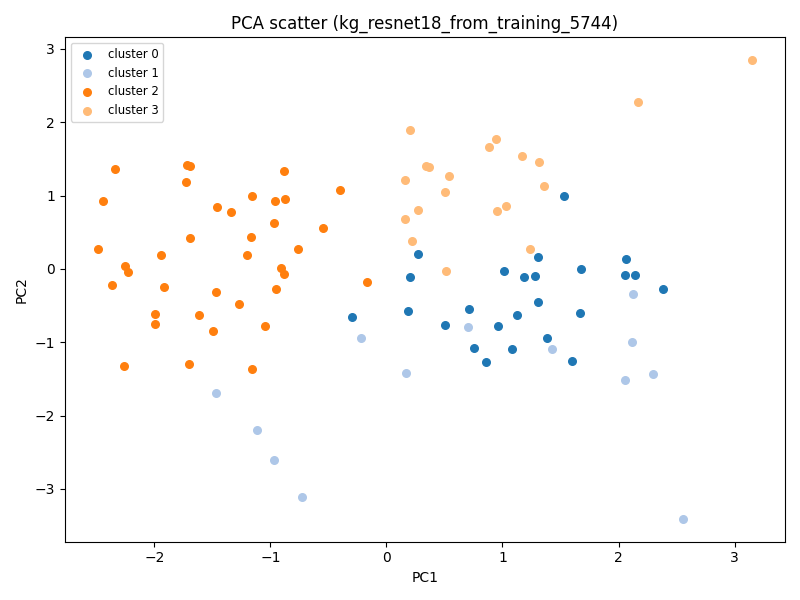

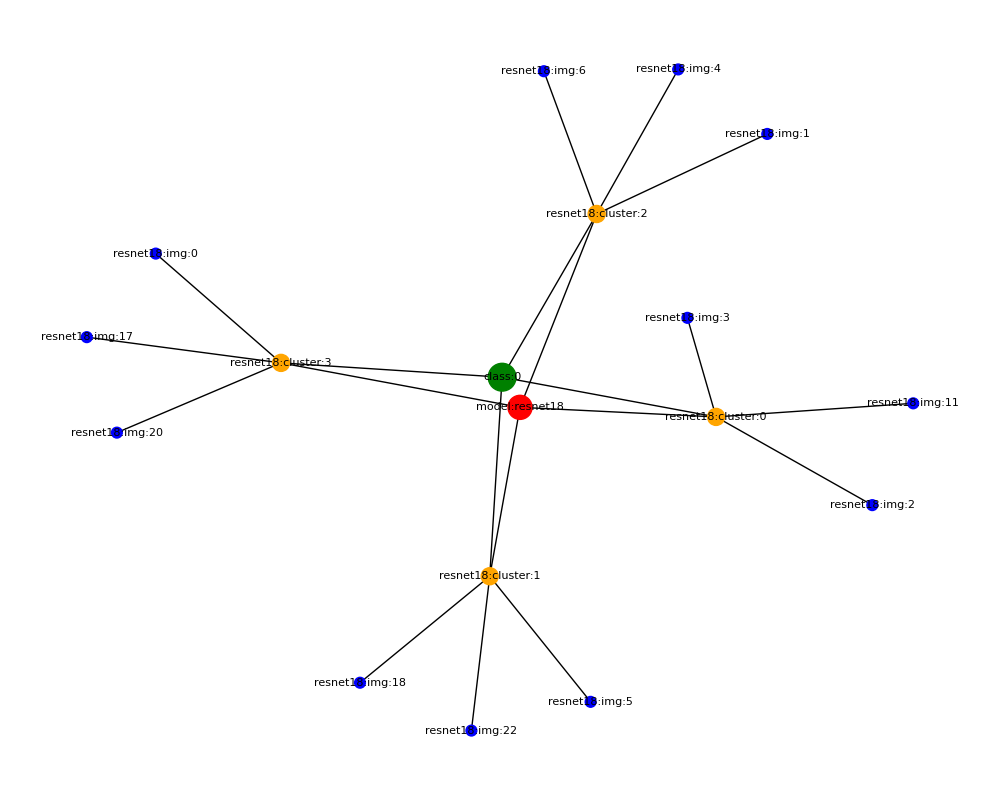


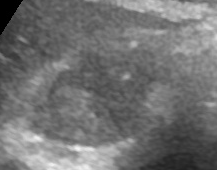
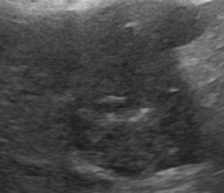
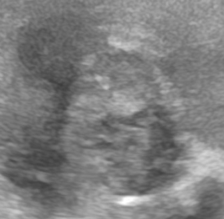
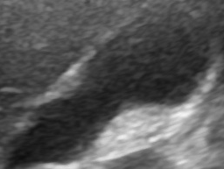
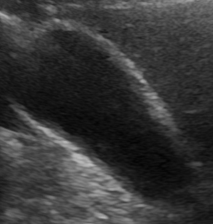
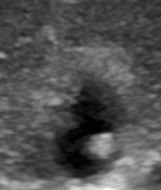
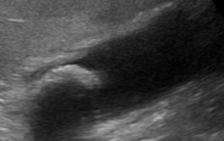
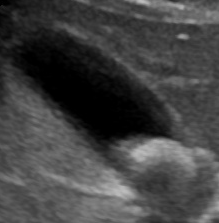
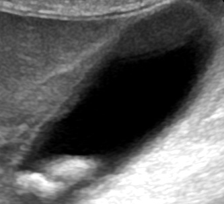
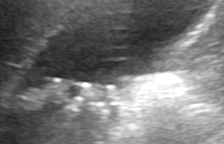
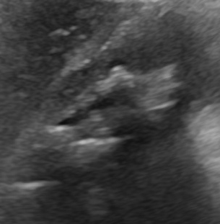
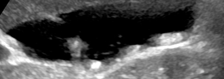

In [103]:
# --- ResNet18 KG export & preview (run after ResNet18 training) ---
from pathlib import Path
import time, base64
import IPython.display as ipd

OUT_DIR = Path.cwd() / "kg_artifacts"
OUT_DIR.mkdir(exist_ok=True)

# Config: use 'auto' / int / 'all' 
cluster_mode = 'auto'   # quick default
max_batches = 3        # smaller for demo
out_prefix = f"kg_resnet18_from_training_{int(time.time())%10000:04d}"

print("Building diagnostic graph...")
try:
    dg = build_and_save_diagnostic_graph('resnet18', train_loss_r18, train_acc_r18, val_loss_r18, val_acc_r18, f"diagnostic_resnet18_{int(time.time())%10000:04d}")
except Exception as e:
    print("Diagnostic build failed:", e)

print("Building model-concept graph (may take a moment)...")
try:
    mcg = build_and_save_model_concept_graph('resnet18', trained_resnet18_model, test_loader, device, out_prefix, n_clusters=cluster_mode, max_batches=max_batches)
except Exception as e:
    print("Model-concept build failed:", e)

# Preview helper
from IPython.display import display, HTML

def preview(prefix):
    p_png = OUT_DIR / f"{prefix}.png"
    p_pca = OUT_DIR / f"{prefix}_pca.png"
    p_samples = OUT_DIR / f"{prefix}_samples"
    print("Artifacts present -> network_png:", p_png.exists(), "pca:", p_pca.exists(), "samples:", p_samples.exists())

    if p_pca.exists():
        display(ipd.Image(filename=str(p_pca)))
    if p_png.exists():
        display(ipd.Image(filename=str(p_png)))

    if p_samples.exists():
        thumbs = sorted(p_samples.glob("*.png"))[:32]
        if thumbs:
            html = '<div style="display:flex;flex-wrap:wrap">'
            for t in thumbs:
                b64 = base64.b64encode(t.read_bytes()).decode()
                html += f"<div style='margin:3px'><img src='data:image/png;base64,{b64}' style='width:100px;height:100px;object-fit:cover;'/></div>"
            html += '</div>'
            display(HTML(html))
        else:
            print("No thumbnails found in", p_samples)

# Preview the artifacts
preview(out_prefix)


Previewing clusters for prefix: kg_resnet18_from_training_5744

Cluster 0: support=25, majority_label=0 (abn), majority_support=25



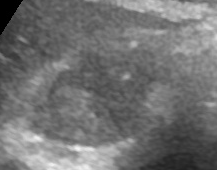
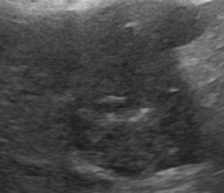
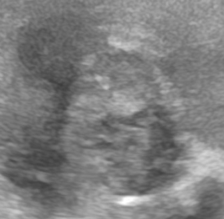


Cluster 1: support=13, majority_label=0 (abn), majority_support=13



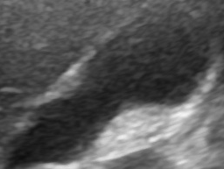
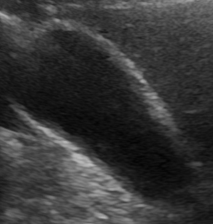
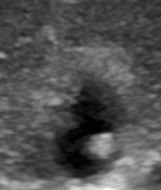


Cluster 2: support=38, majority_label=0 (abn), majority_support=38



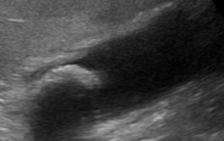
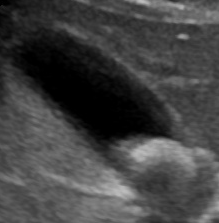
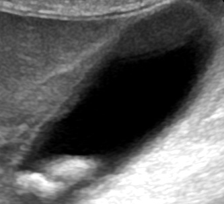


Cluster 3: support=20, majority_label=0 (abn), majority_support=20



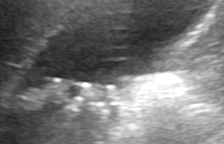
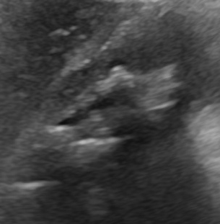
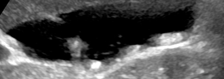

In [105]:
# Helper: list clusters mapped to classes and show top-k thumbnails per cluster
# Usage: show_cluster_previews(prefix='kg_resnet18_from_training_XXXX', top_k=3, filter_class=None)
from IPython.display import display, HTML
import base64


def show_cluster_previews(prefix=None, G=None, top_k=3, filter_class=None):
    """Display cluster -> class mapping and top-k thumbnails per cluster.

    Args:
        prefix (str): the artifact prefix (matching {prefix}.graphml and {prefix}_samples/).
        G (networkx.Graph): optional pre-loaded graph object to use instead of reading graphml.
        top_k (int): number of thumbnails to show per cluster.
        filter_class (int or None): if set, only show clusters whose majority label matches this class index.
    """
    if G is None:
        if not prefix:
            raise ValueError('Provide either prefix or a graph object G')
        graph_path = OUT_DIR / f"{prefix}.graphml"
        if not graph_path.exists():
            print('GraphML not found:', graph_path)
            return
        try:
            G = nx.read_graphml(str(graph_path))
        except Exception as e:
            print('Failed to read graphml:', e)
            return

    # collect cluster nodes
    cluster_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'cluster']
    if not cluster_nodes:
        print('No cluster nodes found in graph.')
        return

    # sort clusters by cluster id
    def _cluster_id(n):
        try:
            v = G.nodes[n].get('cluster')
            return int(float(v))
        except Exception:
            return 0

    cluster_nodes = sorted(cluster_nodes, key=_cluster_id)

    sample_dir = None
    if prefix:
        sample_dir = OUT_DIR / f"{prefix}_samples"

    for cn in cluster_nodes:
        d = G.nodes[cn]
        try:
            c_id = int(float(d.get('cluster', 0)))
        except Exception:
            c_id = d.get('cluster')
        support = int(float(d.get('support', 0))) if d.get('support') is not None else 0
        maj = d.get('majority_label')
        try:
            maj_i = int(float(maj))
            maj_name = class_names[maj_i] if 0 <= maj_i < len(class_names) else 'N/A'
        except Exception:
            maj_i = None
            maj_name = 'N/A'
        maj_support = int(float(d.get('majority_support', 0))) if d.get('majority_support') is not None else 0

        if filter_class is not None and maj_i is not None:
            if int(filter_class) != int(maj_i):
                continue

        print(f"\nCluster {c_id}: support={support}, majority_label={maj_i} ({maj_name}), majority_support={maj_support}")

        thumbs_html = ["<div style='display:flex;flex-wrap:wrap;gap:8px;margin:6px 0'>"]

        # Prefer saved thumbnails in sample_dir if present
        found = 0
        if sample_dir and sample_dir.exists():
            pattern = f"*cluster{c_id}_img*.png"
            files = sorted(sample_dir.glob(pattern))
            for fp in files[:top_k]:
                try:
                    b64 = base64.b64encode(fp.read_bytes()).decode()
                    thumbs_html.append(f"<div style='text-align:center'><img src='data:image/png;base64,{b64}' style='width:140px;height:140px;object-fit:cover;border:1px solid #ddd'/><div style='font-size:smaller;margin-top:4px'>{fp.name}</div></div>")
                    found += 1
                except Exception:
                    continue

        # Fallback: use image nodes connected to this cluster
        if found < top_k:
            imgs = [nbr for nbr in G.neighbors(cn) if G.nodes[nbr].get('type') == 'image']
            for img_node in imgs:
                if found >= top_k:
                    break
                path = G.nodes[img_node].get('path', '')
                if path:
                    pth = Path(path)
                    if pth.exists():
                        try:
                            b64 = base64.b64encode(pth.read_bytes()).decode()
                            thumbs_html.append(f"<div style='text-align:center'><img src='data:image/png;base64,{b64}' style='width:140px;height:140px;object-fit:cover;border:1px solid #ddd'/><div style='font-size:smaller;margin-top:4px'>{pth.name}</div></div>")
                            found += 1
                        except Exception:
                            thumbs_html.append("<div style='width:140px;height:140px;border:1px solid #eee;display:flex;align-items:center;justify-content:center;color:#999'>cannot open</div>")
                            found += 1
                    else:
                        thumbs_html.append(f"<div style='width:140px;height:140px;border:1px solid #eee;display:flex;align-items:center;justify-content:center;color:#999'>missing</div>")
                        found += 1

        if found == 0:
            thumbs_html.append("<div style='color:#666'>No thumbnails available for this cluster.</div>")

        thumbs_html.append("</div>")
        display(HTML(''.join(thumbs_html)))


# If there's a recently-created out_prefix in the namespace, offer a quick demo call
try:
    if 'out_prefix' in globals():
        print('\nPreviewing clusters for prefix:', out_prefix)
        show_cluster_previews(prefix=out_prefix, top_k=3)
except Exception as e:
    print('Preview helper failed:', e)

In [109]:
# Build model-concept graphs for all trained models (auto k, small sample extraction)
# Usage: run this cell after you have trained the models and added them to `all_trained_models` or as individual variables.
import time

models_to_try = [
    ('resnet18', globals().get('trained_resnet18_model')),
    ('efficientnet_b0', globals().get('trained_efficientnet_b0_model')),
    ('efficientnet_b1', globals().get('trained_efficientnet_b1_model')),
    ('efficientnet_b2', globals().get('trained_efficientnet_b2_model')),
    ('efficientnet_b3', globals().get('trained_efficientnet_b3_model')),
    ('efficientnet_b4', globals().get('trained_efficientnet_b4_model')),
    ('densenet121', globals().get('trained_densenet121_model')),
    ('densenet201', globals().get('trained_densenet201_model')),
    ('mobilenet_v2', globals().get('trained_mobilenet_v2_model')),
    ('shufflenet_v2', globals().get('trained_shufflenet_v2_model')),
    ('squeezenet', globals().get('trained_squeezenet_model')),
    ('gbcnet', globals().get('trained_gbcnet_model')),
    ('radformer', globals().get('trained_radformer_model')),
    ('resnet50_v1', globals().get('trained_resnet50_v1_model')),
    ('resnet50_v2', globals().get('trained_resnet50_v2_model')),
]

print('Starting model-concept graph export for models found in the notebook...')
for name, model in models_to_try:
    if model is None:
        print(f"Skipping {name}: model object not found in namespace.")
        continue
    try:
        out_prefix = f"kg_{name}_from_training_{int(time.time())%10000:04d}"
        print(f"\nBuilding model-concept graph for {name} -> {out_prefix}")
        G = build_and_save_model_concept_graph(name, model, test_loader, device, out_prefix, n_clusters='auto', max_batches=3)
        if G is None:
            print(f"{name}: no embeddings produced or graph build returned None")
            continue
        # report artifact paths
        img_out = OUT_DIR / f"{out_prefix}.png"
        pca_out = OUT_DIR / f"{out_prefix}_pca.png"
        samples_dir = OUT_DIR / f"{out_prefix}_samples"
        print('Artifacts:', 'network_png=' + (str(img_out) if img_out.exists() else 'missing'),
              'pca=' + (str(pca_out) if pca_out.exists() else 'missing'),
              'samples_dir=' + (str(samples_dir) if samples_dir.exists() else 'missing'))
    except Exception as e:
        import traceback
        print(f"Failed building model-concept graph for {name}:", e)
        traceback.print_exc()

Starting model-concept graph export for models found in the notebook...

Building model-concept graph for resnet18 -> kg_resnet18_from_training_8258
Auto-selected k=4 (silhouette=0.3233080506324768)


C:\Users\offic\AppData\Local\Temp\ipykernel_17672\776677441.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved PCA scatter: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet18_from_training_8258_pca.png
Saved model-concept graph: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet18_from_training_8258.graphml
Artifacts summary: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet18_from_training_8258.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet18_from_training_8258_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet18_from_training_8258_samples
Artifacts: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet18_from_training_8258.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet18_from_training_8258_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet18_from_training_8258_samples

Building model-concept graph for efficientnet_b0 -> kg_efficientnet_b0_from_training_8258
Auto-selected k=2 (silhouette=0.0645817294716835)
Saved PCA scatter: d:\Gallblader-Cancer-Detecti

C:\Users\offic\AppData\Local\Temp\ipykernel_17672\776677441.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Auto-selected k=2 (silhouette=0.0788865014910698)
Saved PCA scatter: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b1_from_training_8259_pca.png
Saved model-concept graph: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b1_from_training_8259.graphml
Artifacts summary: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b1_from_training_8259.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b1_from_training_8259_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b1_from_training_8259_samples


C:\Users\offic\AppData\Local\Temp\ipykernel_17672\776677441.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Artifacts: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b1_from_training_8259.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b1_from_training_8259_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b1_from_training_8259_samples

Building model-concept graph for efficientnet_b2 -> kg_efficientnet_b2_from_training_8261
Auto-selected k=2 (silhouette=0.2859785854816437)
Saved PCA scatter: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b2_from_training_8261_pca.png
Saved model-concept graph: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b2_from_training_8261.graphml
Artifacts summary: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b2_from_training_8261.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b2_from_training_8261_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b2_from_training_8261

C:\Users\offic\AppData\Local\Temp\ipykernel_17672\776677441.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Auto-selected k=2 (silhouette=0.2672075033187866)
Saved PCA scatter: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b3_from_training_8262_pca.png
Saved model-concept graph: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b3_from_training_8262.graphml
Artifacts summary: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b3_from_training_8262.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b3_from_training_8262_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b3_from_training_8262_samples
Artifacts: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b3_from_training_8262.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b3_from_training_8262_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b3_from_training_8262_samples

Building model-concept graph for efficientnet_b4 -> kg_efficientnet_b4_from_train

C:\Users\offic\AppData\Local\Temp\ipykernel_17672\776677441.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Auto-selected k=3 (silhouette=0.03260769695043564)
Saved PCA scatter: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b4_from_training_8263_pca.png
Saved model-concept graph: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b4_from_training_8263.graphml
Artifacts summary: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b4_from_training_8263.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b4_from_training_8263_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b4_from_training_8263_samples


C:\Users\offic\AppData\Local\Temp\ipykernel_17672\776677441.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Artifacts: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b4_from_training_8263.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b4_from_training_8263_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_efficientnet_b4_from_training_8263_samples

Building model-concept graph for densenet121 -> kg_densenet121_from_training_8265
Auto-selected k=3 (silhouette=0.08327443152666092)


C:\Users\offic\AppData\Local\Temp\ipykernel_17672\776677441.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved PCA scatter: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_densenet121_from_training_8265_pca.png
Saved model-concept graph: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_densenet121_from_training_8265.graphml
Artifacts summary: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_densenet121_from_training_8265.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_densenet121_from_training_8265_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_densenet121_from_training_8265_samples
Artifacts: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_densenet121_from_training_8265.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_densenet121_from_training_8265_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_densenet121_from_training_8265_samples

Building model-concept graph for densenet201 -> kg_densenet201_from_training_8267
Auto-selected k=3 (silhouette=0.10758623480796814)


C:\Users\offic\AppData\Local\Temp\ipykernel_17672\776677441.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved PCA scatter: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_densenet201_from_training_8267_pca.png
Saved model-concept graph: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_densenet201_from_training_8267.graphml
Artifacts summary: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_densenet201_from_training_8267.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_densenet201_from_training_8267_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_densenet201_from_training_8267_samples
Artifacts: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_densenet201_from_training_8267.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_densenet201_from_training_8267_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_densenet201_from_training_8267_samples

Building model-concept graph for mobilenet_v2 -> kg_mobilenet_v2_from_training_8269
Auto-selected k=2 (silhouette=0.4293248653411865)
Saved PCA scatter: d:\Gallbla

C:\Users\offic\AppData\Local\Temp\ipykernel_17672\776677441.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Auto-selected k=2 (silhouette=0.2985239326953888)


C:\Users\offic\AppData\Local\Temp\ipykernel_17672\776677441.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved PCA scatter: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_shufflenet_v2_from_training_8270_pca.png
Saved model-concept graph: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_shufflenet_v2_from_training_8270.graphml
Artifacts summary: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_shufflenet_v2_from_training_8270.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_shufflenet_v2_from_training_8270_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_shufflenet_v2_from_training_8270_samples
Artifacts: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_shufflenet_v2_from_training_8270.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_shufflenet_v2_from_training_8270_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_shufflenet_v2_from_training_8270_samples

Building model-concept graph for squeezenet -> kg_squeezenet_from_training_8270
Auto-selected k=2 (silhouette=0.2848294675350189)
Saved PCA scatter

C:\Users\offic\AppData\Local\Temp\ipykernel_17672\776677441.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Auto-selected k=2 (silhouette=0.24565036594867706)


C:\Users\offic\AppData\Local\Temp\ipykernel_17672\776677441.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved PCA scatter: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_gbcnet_from_training_8271_pca.png
Saved model-concept graph: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_gbcnet_from_training_8271.graphml
Artifacts summary: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_gbcnet_from_training_8271.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_gbcnet_from_training_8271_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_gbcnet_from_training_8271_samples
Artifacts: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_gbcnet_from_training_8271.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_gbcnet_from_training_8271_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_gbcnet_from_training_8271_samples
Skipping radformer: model object not found in namespace.

Building model-concept graph for resnet50_v1 -> kg_resnet50_v1_from_training_8272
Auto-selected k=3 (silhouette=0.30365273356437683)


C:\Users\offic\AppData\Local\Temp\ipykernel_17672\776677441.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved PCA scatter: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet50_v1_from_training_8272_pca.png
Saved model-concept graph: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet50_v1_from_training_8272.graphml
Artifacts summary: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet50_v1_from_training_8272.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet50_v1_from_training_8272_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet50_v1_from_training_8272_samples
Artifacts: network_png=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet50_v1_from_training_8272.png pca=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet50_v1_from_training_8272_pca.png samples_dir=d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet50_v1_from_training_8272_samples

Building model-concept graph for resnet50_v2 -> kg_resnet50_v2_from_training_8273
Auto-selected k=3 (silhouette=0.2964734137058258)
Saved PCA scatter: d:\Gallblade

C:\Users\offic\AppData\Local\Temp\ipykernel_17672\776677441.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



Checking prefix: kg_resnet50_v1_from_training_8105
Network PNG exists: True
PCA PNG exists: True
Samples dir exists: True
Displaying PCA scatter: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet50_v1_from_training_8105_pca.png


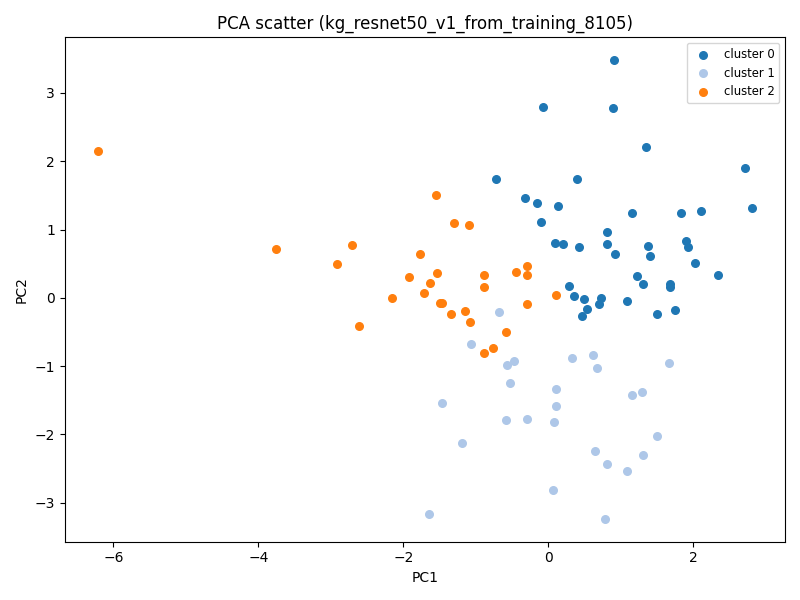

Displaying network PNG: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet50_v1_from_training_8105.png


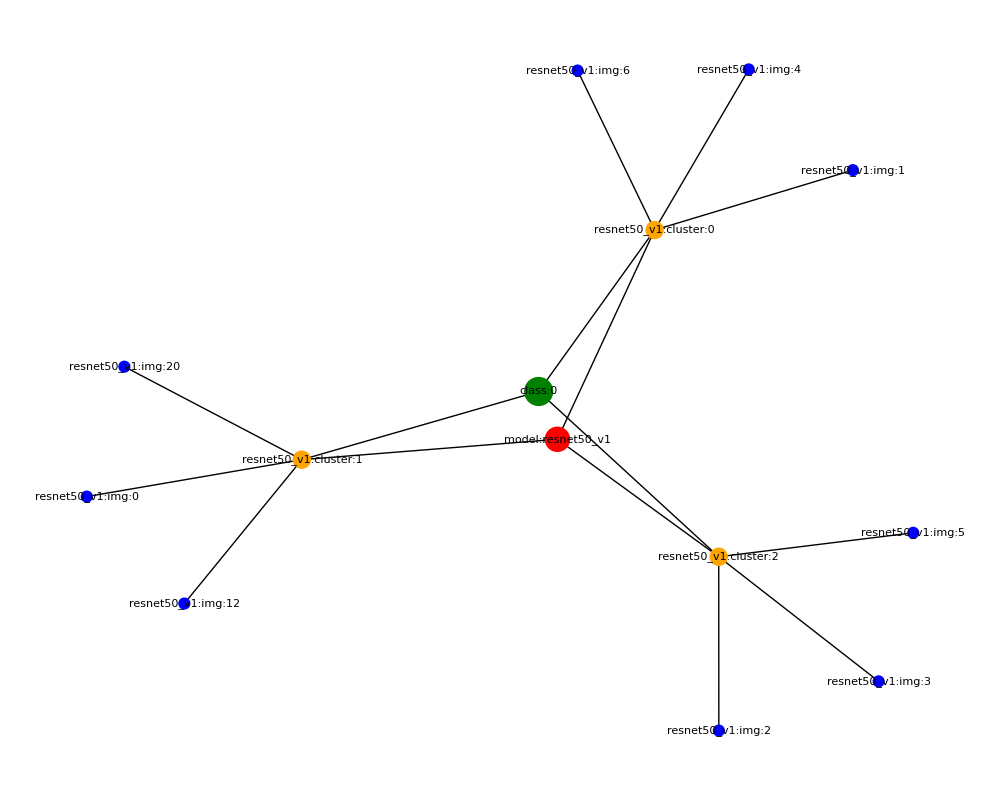

Thumbnail count: 9
Showing top 3 thumbnails:
 - resnet50_v1_cluster0_img1.png


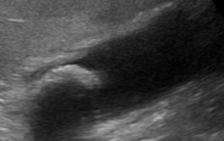

 - resnet50_v1_cluster0_img4.png


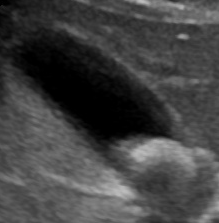

 - resnet50_v1_cluster0_img6.png


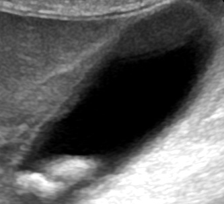

Checked 9 paths, bad=0
Bad thumbnails (first 10): []

Checking prefix: kg_resnet50_v2_from_training_8106
Network PNG exists: True
PCA PNG exists: True
Samples dir exists: True
Displaying PCA scatter: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet50_v2_from_training_8106_pca.png


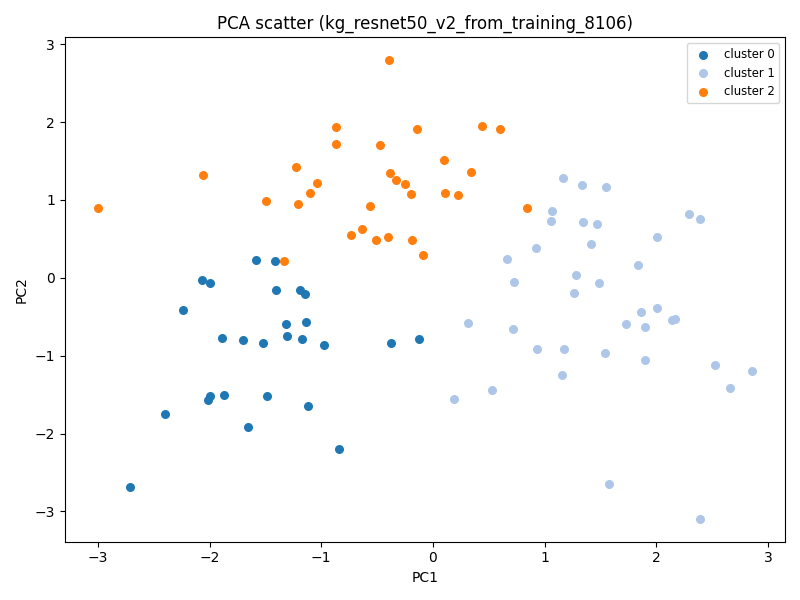

Displaying network PNG: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet50_v2_from_training_8106.png


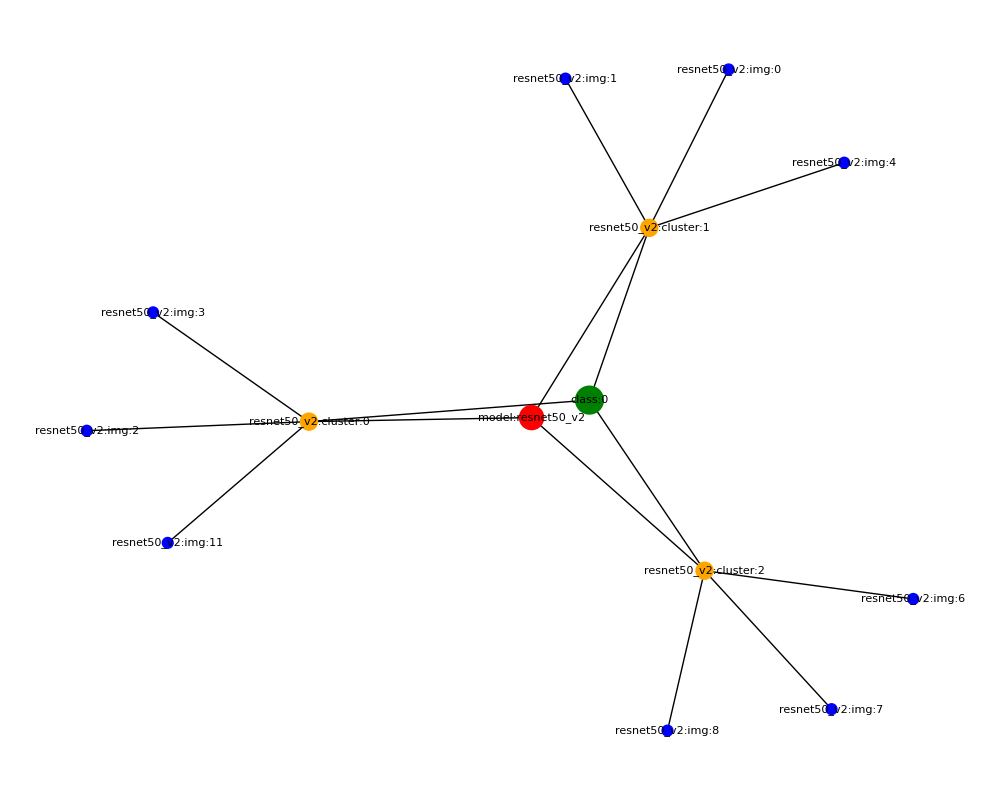

Thumbnail count: 9
Showing top 3 thumbnails:
 - resnet50_v2_cluster0_img11.png


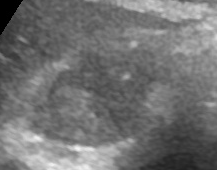

 - resnet50_v2_cluster0_img2.png


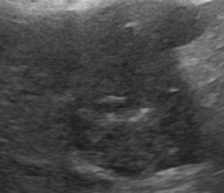

 - resnet50_v2_cluster0_img3.png


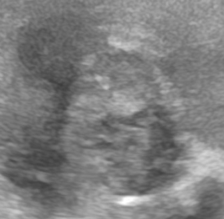

Checked 9 paths, bad=0
Bad thumbnails (first 10): []

Done checks.


In [116]:
# Quick checks and inline preview for specified prefixes
# This will display PCA scatter, network PNG, and top-3 thumbnails (if present) and report unreadable/corrupt files.
import base64
import IPython.display as ipd
from pathlib import Path

prefixes = [
    'kg_resnet50_v1_from_training_8105',
    'kg_resnet50_v2_from_training_8106'
]

for pref in prefixes:
    print('\n' + '='*60)
    print('Checking prefix:', pref)
    p_png = OUT_DIR / f"{pref}.png"
    p_pca = OUT_DIR / f"{pref}_pca.png"
    p_samples = OUT_DIR / f"{pref}_samples"

    print('Network PNG exists:', p_png.exists())
    print('PCA PNG exists:', p_pca.exists())
    print('Samples dir exists:', p_samples.exists())

    if p_pca.exists():
        try:
            print('Displaying PCA scatter:', p_pca)
            display(ipd.Image(filename=str(p_pca)))
        except Exception as e:
            print('Could not display PCA image:', e)

    if p_png.exists():
        try:
            print('Displaying network PNG:', p_png)
            display(ipd.Image(filename=str(p_png)))
        except Exception as e:
            print('Could not display network PNG:', e)

    if p_samples.exists():
        thumbs = sorted(p_samples.glob('*.png'))
        print('Thumbnail count:', len(thumbs))
        if len(thumbs) == 0:
            print('No thumbnails found in', p_samples)
        else:
            print('Showing top 3 thumbnails:')
            for t in thumbs[:3]:
                print(' -', t.name)
                try:
                    display(ipd.Image(filename=str(t)))
                except Exception as e:
                    print('Could not display thumbnail', t, e)

            # run quick readability check on first 50 thumbnails
            check_list = [str(x) for x in thumbs[:50]]
            bad = check_image_paths(check_list, max_checks=50)
            print('Bad thumbnails (first 10):', bad[:10])
    else:
        print('Samples directory missing; thumbnails were not produced.')

print('\nDone checks.')

### Efficientnet_B0

In [61]:
efficientnet_b0_model = get_model("efficientnet_b0", num_classes=len(class_names))
trained_efficientnet_b0_model, train_loss_eb0, val_loss_eb0, train_acc_eb0, val_acc_eb0 = train_model(efficientnet_b0_model, "EfficientNetB0", epochs=30, patience=5)
plot_accuracy_loss(train_loss_eb0, val_loss_eb0, train_acc_eb0, val_acc_eb0, "EfficientNetB0")
y_true_eb0, y_pred_classes_eb0, y_pred_scores_eb0 = evaluate_model_on_test(trained_efficientnet_b0_model, "EfficientNetB0")
plot_confusion_matrix(y_true_eb0, y_pred_classes_eb0, class_names, "EfficientNetB0")
plot_roc_curve(label_binarize(y_true_eb0, classes=list(range(NUM_CLASSES))), y_pred_scores_eb0, NUM_CLASSES, class_names, "EfficientNetB0")
all_trained_models.append(trained_efficientnet_b0_model)


--- Training EfficientNetB0 ---
Epoch 0/29
----------
training Loss: 0.8430 Acc: 0.6847
validation Loss: 0.6887 Acc: 0.7832
Epoch 1/29
----------


KeyboardInterrupt: 

### Densenet-121

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\offic/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:02<00:00, 11.5MB/s]



--- Training DenseNet121 ---
Epoch 0/29
----------
training Loss: 0.9034 Acc: 0.6436
validation Loss: 0.9495 Acc: 0.6590
Epoch 1/29
----------
training Loss: 0.6820 Acc: 0.7402
validation Loss: 0.8002 Acc: 0.6908
Epoch 2/29
----------
training Loss: 0.6144 Acc: 0.7533
validation Loss: 0.6824 Acc: 0.7428
Epoch 3/29
----------
training Loss: 0.5487 Acc: 0.7763
validation Loss: 0.8851 Acc: 0.7370
Epoch 4/29
----------
training Loss: 0.5263 Acc: 0.7857
validation Loss: 0.5326 Acc: 0.7832
Epoch 5/29
----------
training Loss: 0.5116 Acc: 0.8118
validation Loss: 0.7094 Acc: 0.7717
Epoch 6/29
----------
training Loss: 0.5272 Acc: 0.8012
validation Loss: 0.6123 Acc: 0.7630
Epoch 7/29
----------
training Loss: 0.3844 Acc: 0.8505
validation Loss: 0.4185 Acc: 0.8497
Epoch 8/29
----------
training Loss: 0.3375 Acc: 0.8741
validation Loss: 0.4010 Acc: 0.8642
Epoch 9/29
----------
training Loss: 0.3160 Acc: 0.8916
validation Loss: 0.3908 Acc: 0.8613
Epoch 10/29
----------
training Loss: 0.2894 Acc: 

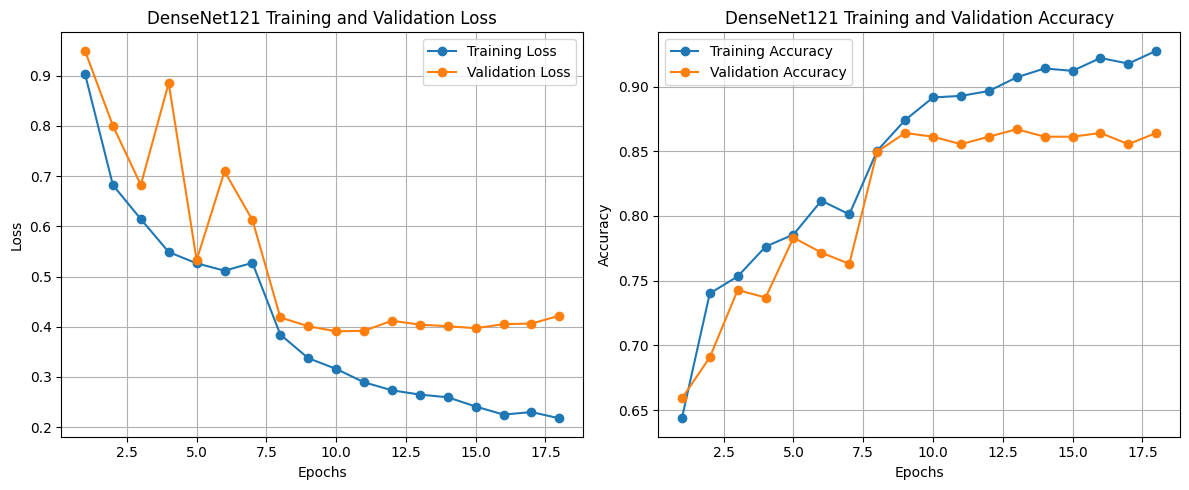


--- Evaluating DenseNet121 on Test Set ---
Test Accuracy for DenseNet121: 0.8630
Classification Report for DenseNet121:
              precision    recall  f1-score   support

         abn       0.91      0.83      0.87       123
         bmt       0.81      0.72      0.76        29
        malg       0.61      0.85      0.71        40
         nml       0.92      0.89      0.91        65
         stn       0.94      0.94      0.94        86

    accuracy                           0.86       343
   macro avg       0.84      0.85      0.84       343
weighted avg       0.88      0.86      0.87       343



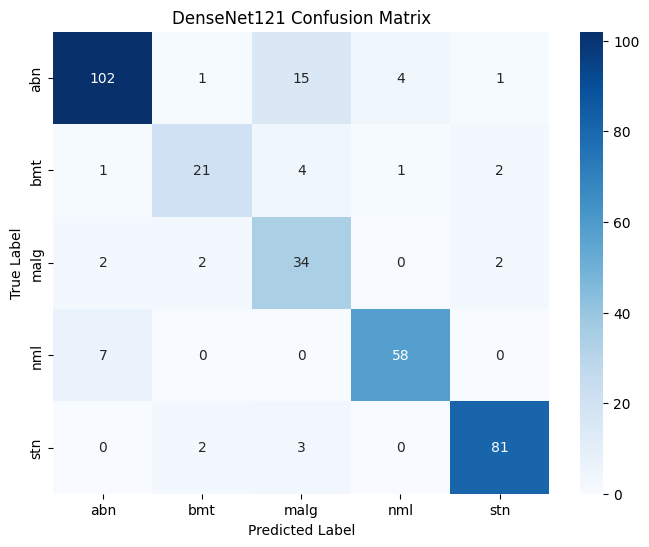

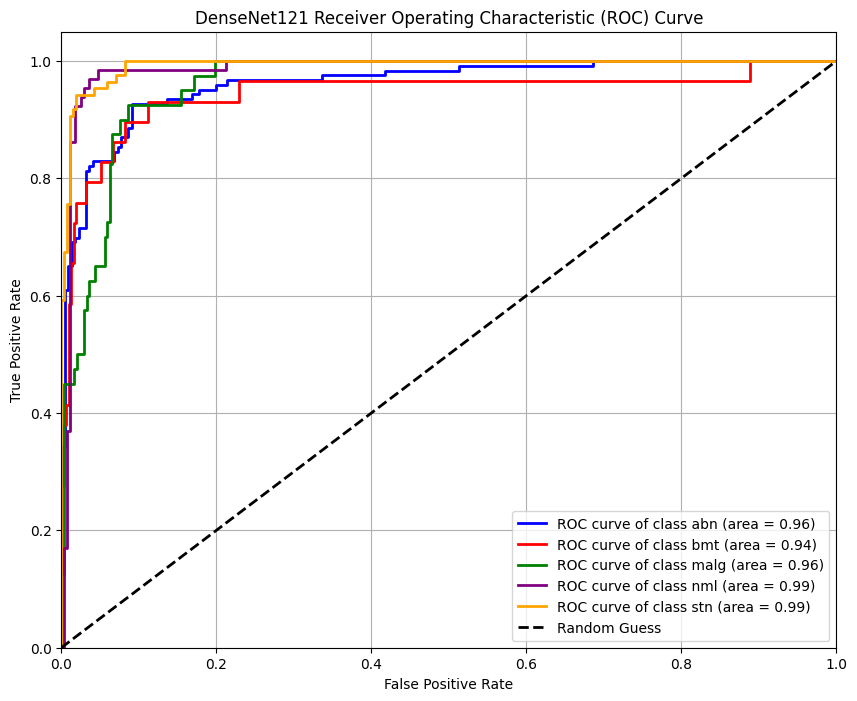

In [ ]:
densenet121_model = get_model("densenet121", num_classes=len(class_names))
trained_densenet121_model, train_loss_d121, val_loss_d121, train_acc_d121, val_acc_d121 = train_model(densenet121_model, "DenseNet121", epochs=30, patience=5)
plot_accuracy_loss(train_loss_d121, val_loss_d121, train_acc_d121, val_acc_d121, "DenseNet121")
y_true_d121, y_pred_classes_d121, y_pred_scores_d121 = evaluate_model_on_test(trained_densenet121_model, "DenseNet121")
plot_confusion_matrix(y_true_d121, y_pred_classes_d121, class_names, "DenseNet121")
plot_roc_curve(label_binarize(y_true_d121, classes=list(range(NUM_CLASSES))), y_pred_scores_d121, NUM_CLASSES, class_names, "DenseNet121")
all_trained_models.append(trained_densenet121_model)

### MobileNetV2

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\offic/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:01<00:00, 11.6MB/s]



--- Training MobileNetV2 ---
Epoch 0/29
----------
training Loss: 0.9218 Acc: 0.6224
validation Loss: 0.7458 Acc: 0.7457
Epoch 1/29
----------
training Loss: 0.6900 Acc: 0.7371
validation Loss: 0.5421 Acc: 0.8179
Epoch 2/29
----------
training Loss: 0.6063 Acc: 0.7676
validation Loss: 0.5755 Acc: 0.7977
Epoch 3/29
----------
training Loss: 0.5211 Acc: 0.7988
validation Loss: 0.5122 Acc: 0.8064
Epoch 4/29
----------
training Loss: 0.5224 Acc: 0.8087
validation Loss: 0.5793 Acc: 0.7861
Epoch 5/29
----------
training Loss: 0.5358 Acc: 0.7956
validation Loss: 0.5159 Acc: 0.8064
Epoch 6/29
----------
training Loss: 0.4699 Acc: 0.8287
validation Loss: 0.6806 Acc: 0.7254
Early stopping triggered.
Best val Acc: 0.8179


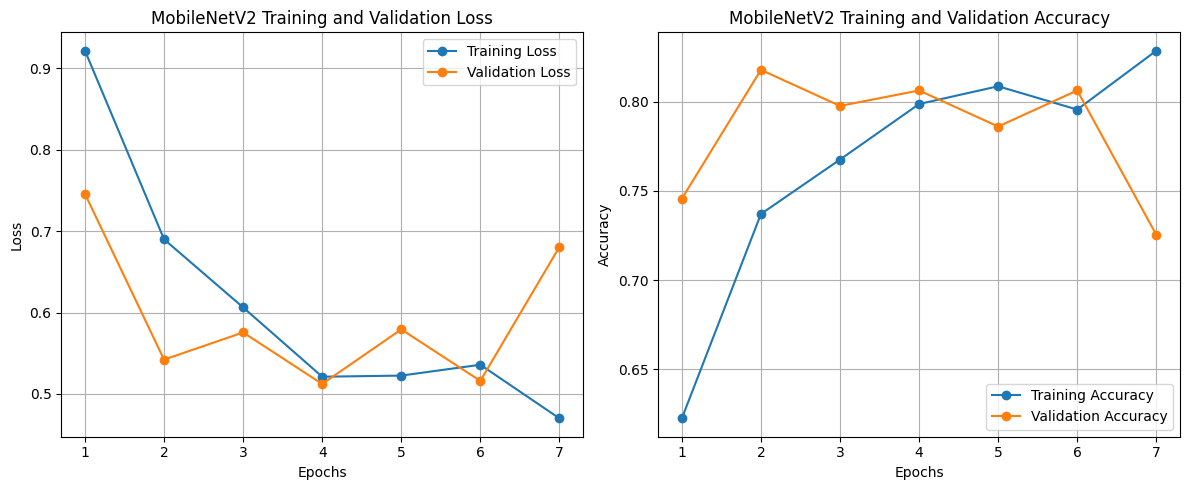


--- Evaluating MobileNetV2 on Test Set ---
Test Accuracy for MobileNetV2: 0.7172
Classification Report for MobileNetV2:
              precision    recall  f1-score   support

         abn       0.87      0.69      0.77       123
         bmt       0.39      0.66      0.49        29
        malg       0.55      0.85      0.67        40
         nml       0.73      1.00      0.84        65
         stn       0.96      0.50      0.66        86

    accuracy                           0.72       343
   macro avg       0.70      0.74      0.68       343
weighted avg       0.79      0.72      0.72       343



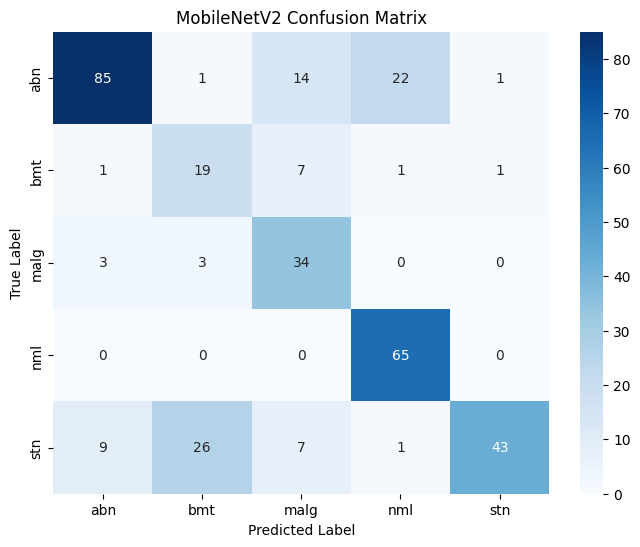

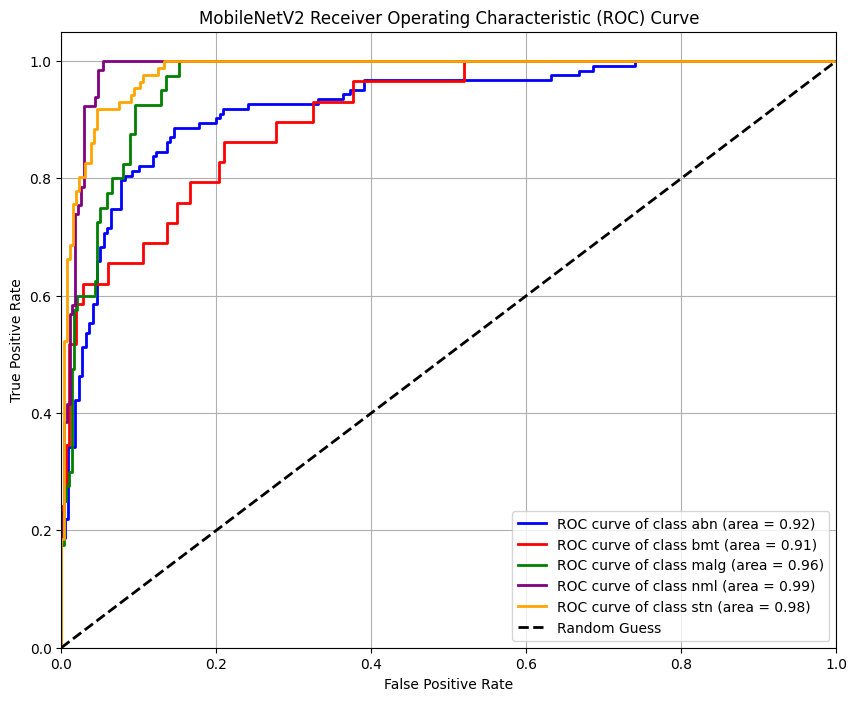

In [ ]:
mobilenet_v2_model = get_model("mobilenet_v2", num_classes=len(class_names))
trained_mobilenet_v2_model, train_loss_mv2, val_loss_mv2, train_acc_mv2, val_acc_mv2 = train_model(mobilenet_v2_model, "MobileNetV2", epochs=30, patience=5)
plot_accuracy_loss(train_loss_mv2, val_loss_mv2, train_acc_mv2, val_acc_mv2, "MobileNetV2")
y_true_mv2, y_pred_classes_mv2, y_pred_scores_mv2 = evaluate_model_on_test(trained_mobilenet_v2_model, "MobileNetV2")
plot_confusion_matrix(y_true_mv2, y_pred_classes_mv2, class_names, "MobileNetV2")
plot_roc_curve(label_binarize(y_true_mv2, classes=list(range(NUM_CLASSES))), y_pred_scores_mv2, NUM_CLASSES, class_names, "MobileNetV2")
all_trained_models.append(trained_mobilenet_v2_model)

### ShuffleNetV2

Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to C:\Users\offic/.cache\torch\hub\checkpoints\shufflenetv2_x1-5666bf0f80.pth


100%|██████████| 8.79M/8.79M [00:00<00:00, 11.5MB/s]



--- Training ShuffleNetV2 ---
Epoch 0/29
----------
training Loss: 1.0701 Acc: 0.6318
validation Loss: 0.6738 Acc: 0.7254
Epoch 1/29
----------
training Loss: 0.6614 Acc: 0.7526
validation Loss: 0.5368 Acc: 0.8121
Epoch 2/29
----------
training Loss: 0.5490 Acc: 0.7913
validation Loss: 0.5566 Acc: 0.7919
Epoch 3/29
----------
training Loss: 0.4821 Acc: 0.8181
validation Loss: 0.4713 Acc: 0.8439
Epoch 4/29
----------
training Loss: 0.3986 Acc: 0.8536
validation Loss: 0.4896 Acc: 0.8208
Epoch 5/29
----------
training Loss: 0.4053 Acc: 0.8455
validation Loss: 0.3903 Acc: 0.8410
Epoch 6/29
----------
training Loss: 0.3841 Acc: 0.8561
validation Loss: 0.3870 Acc: 0.8613
Epoch 7/29
----------
training Loss: 0.3025 Acc: 0.8953
validation Loss: 0.3723 Acc: 0.8728
Epoch 8/29
----------
training Loss: 0.2560 Acc: 0.9146
validation Loss: 0.3641 Acc: 0.8873
Epoch 9/29
----------
training Loss: 0.2390 Acc: 0.9165
validation Loss: 0.3537 Acc: 0.8873
Epoch 10/29
----------
training Loss: 0.2264 Acc:

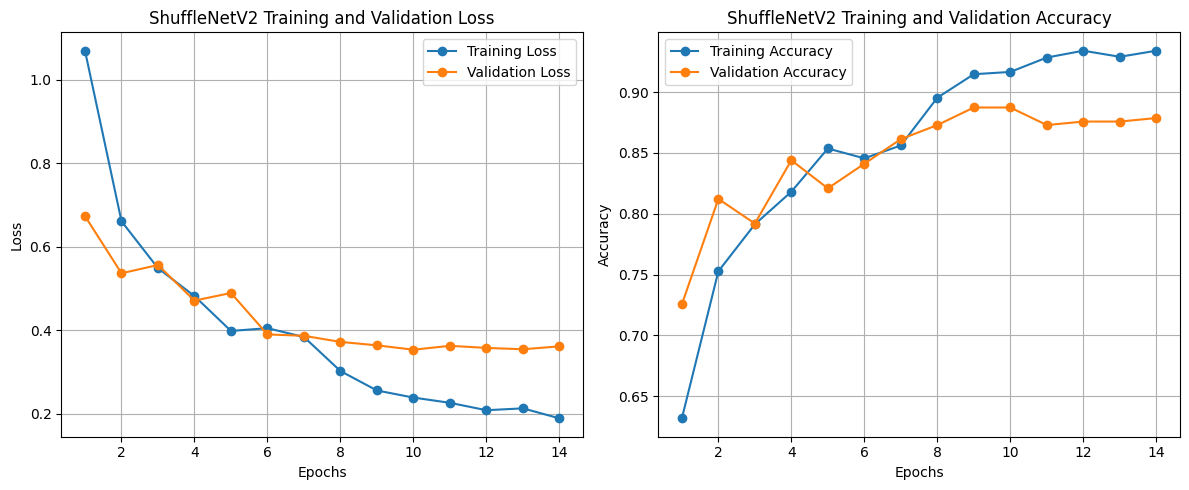


--- Evaluating ShuffleNetV2 on Test Set ---
Test Accuracy for ShuffleNetV2: 0.8688
Classification Report for ShuffleNetV2:
              precision    recall  f1-score   support

         abn       0.92      0.83      0.87       123
         bmt       0.80      0.69      0.74        29
        malg       0.64      0.85      0.73        40
         nml       0.91      0.92      0.92        65
         stn       0.93      0.95      0.94        86

    accuracy                           0.87       343
   macro avg       0.84      0.85      0.84       343
weighted avg       0.88      0.87      0.87       343



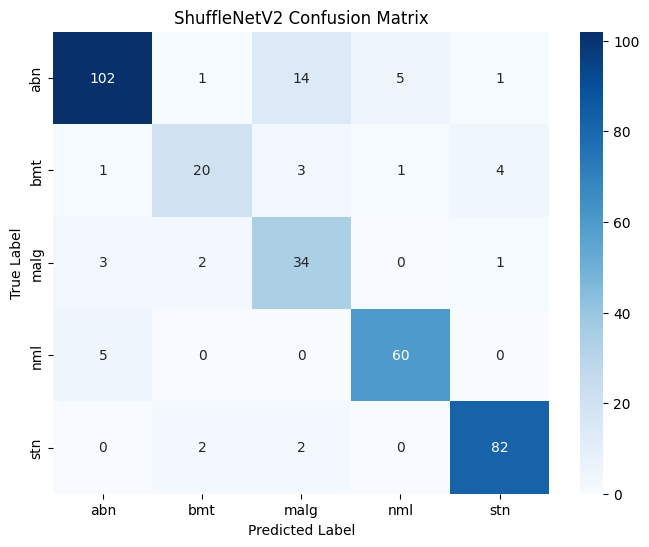

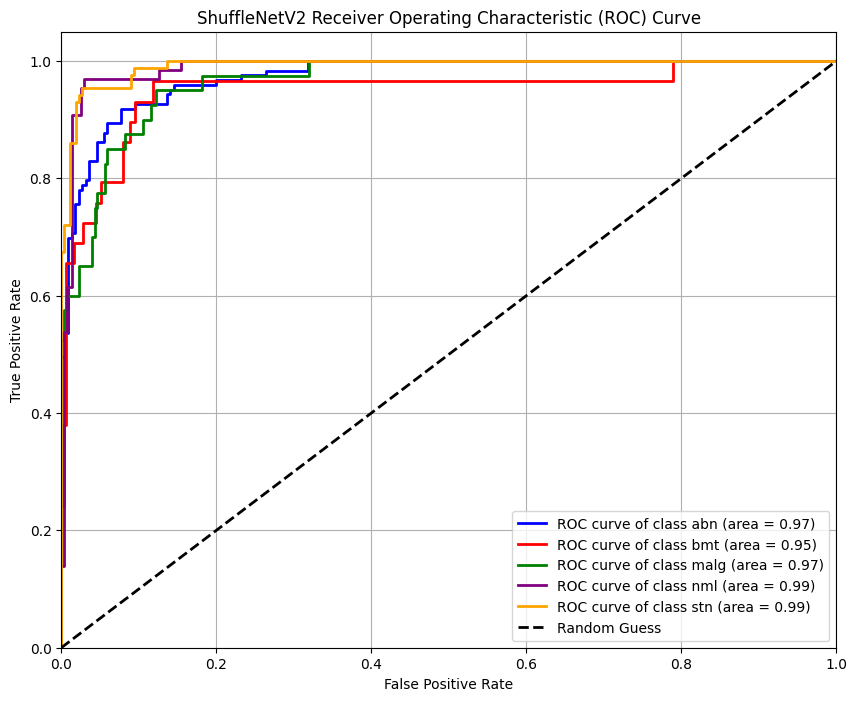

In [ ]:
shufflenet_v2_model = get_model("shufflenet_v2", num_classes=len(class_names))
trained_shufflenet_v2_model, train_loss_sv2, val_loss_sv2, train_acc_sv2, val_acc_sv2 = train_model(shufflenet_v2_model, "ShuffleNetV2", epochs=30, patience=5)
plot_accuracy_loss(train_loss_sv2, val_loss_sv2, train_acc_sv2, val_acc_sv2, "ShuffleNetV2")
y_true_sv2, y_pred_classes_sv2, y_pred_scores_sv2 = evaluate_model_on_test(trained_shufflenet_v2_model, "ShuffleNetV2")
plot_confusion_matrix(y_true_sv2, y_pred_classes_sv2, class_names, "ShuffleNetV2")
plot_roc_curve(label_binarize(y_true_sv2, classes=list(range(NUM_CLASSES))), y_pred_scores_sv2, NUM_CLASSES, class_names, "ShuffleNetV2")
all_trained_models.append(trained_shufflenet_v2_model)

### SqueezeNet1_0

Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to C:\Users\offic/.cache\torch\hub\checkpoints\squeezenet1_0-b66bff10.pth


100%|██████████| 4.78M/4.78M [00:00<00:00, 10.2MB/s]



--- Training SqueezeNet ---
Epoch 0/29
----------
training Loss: 1.4508 Acc: 0.4000
validation Loss: 1.7688 Acc: 0.4220
Epoch 1/29
----------
training Loss: 1.1700 Acc: 0.5458
validation Loss: 1.2285 Acc: 0.5347
Epoch 2/29
----------
training Loss: 1.1005 Acc: 0.5807
validation Loss: 0.9371 Acc: 0.6329
Epoch 3/29
----------
training Loss: 0.9785 Acc: 0.6044
validation Loss: 0.8823 Acc: 0.6301
Epoch 4/29
----------
training Loss: 0.8917 Acc: 0.6399
validation Loss: 0.9706 Acc: 0.6243
Epoch 5/29
----------
training Loss: 0.8878 Acc: 0.6231
validation Loss: 0.8244 Acc: 0.6618
Epoch 6/29
----------
training Loss: 0.8155 Acc: 0.6592
validation Loss: 0.7621 Acc: 0.6908
Epoch 7/29
----------
training Loss: 0.7449 Acc: 0.7065
validation Loss: 0.6879 Acc: 0.7139
Epoch 8/29
----------
training Loss: 0.6919 Acc: 0.7153
validation Loss: 0.6831 Acc: 0.7168
Epoch 9/29
----------
training Loss: 0.6875 Acc: 0.7227
validation Loss: 0.6656 Acc: 0.7081
Epoch 10/29
----------
training Loss: 0.6690 Acc: 0

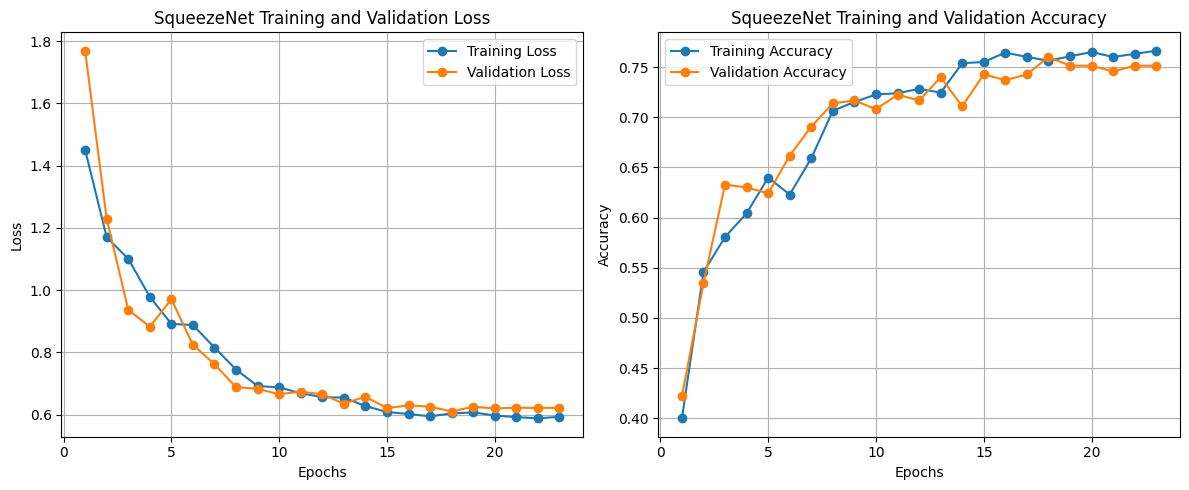


--- Evaluating SqueezeNet on Test Set ---
Test Accuracy for SqueezeNet: 0.7580
Classification Report for SqueezeNet:
              precision    recall  f1-score   support

         abn       0.76      0.86      0.81       123
         bmt       0.48      0.38      0.42        29
        malg       0.74      0.57      0.65        40
         nml       0.80      0.72      0.76        65
         stn       0.81      0.85      0.83        86

    accuracy                           0.76       343
   macro avg       0.72      0.68      0.69       343
weighted avg       0.75      0.76      0.75       343



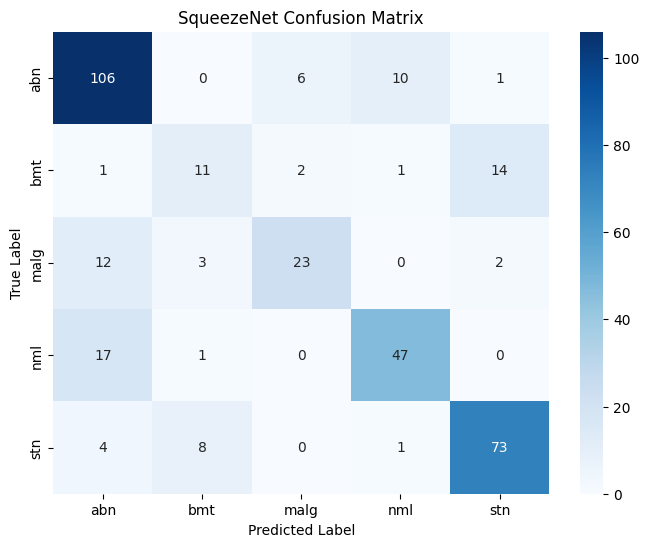

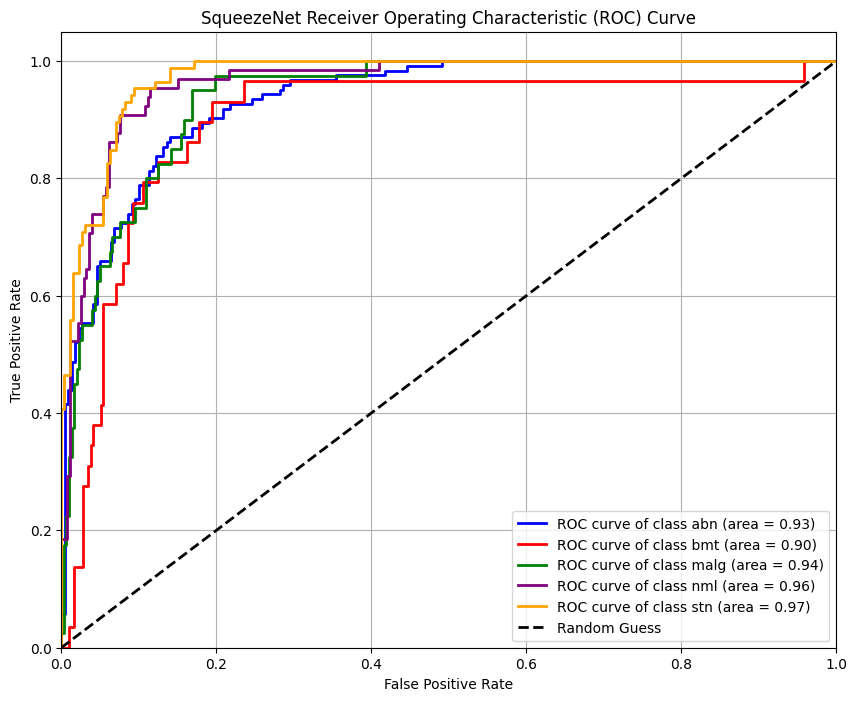

In [ ]:
squeezenet_model = get_model("squeezenet", num_classes=len(class_names))
trained_squeezenet_model, train_loss_sqz, val_loss_sqz, train_acc_sqz, val_acc_sqz = train_model(squeezenet_model, "SqueezeNet", epochs=30, patience=5)
plot_accuracy_loss(train_loss_sqz, val_loss_sqz, train_acc_sqz, val_acc_sqz, "SqueezeNet")
y_true_sqz, y_pred_classes_sqz, y_pred_scores_sqz = evaluate_model_on_test(trained_squeezenet_model, "SqueezeNet")
plot_confusion_matrix(y_true_sqz, y_pred_classes_sqz, class_names, "SqueezeNet")
plot_roc_curve(label_binarize(y_true_sqz, classes=list(range(NUM_CLASSES))), y_pred_scores_sqz, NUM_CLASSES, class_names, "SqueezeNet")
all_trained_models.append(trained_squeezenet_model)

### Densenet201

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to C:\Users\offic/.cache\torch\hub\checkpoints\densenet201-c1103571.pth


100%|██████████| 77.4M/77.4M [00:08<00:00, 9.45MB/s]



--- Training DenseNet201 ---
Epoch 0/29
----------
training Loss: 0.8928 Acc: 0.6505
validation Loss: 0.9319 Acc: 0.6879
Epoch 1/29
----------
training Loss: 0.7533 Acc: 0.6997
validation Loss: 0.6553 Acc: 0.7630
Epoch 2/29
----------
training Loss: 0.6082 Acc: 0.7539
validation Loss: 0.6127 Acc: 0.7688
Epoch 3/29
----------
training Loss: 0.5926 Acc: 0.7726
validation Loss: 0.5780 Acc: 0.7832
Epoch 4/29
----------
training Loss: 0.5828 Acc: 0.7801
validation Loss: 0.6575 Acc: 0.7775
Epoch 5/29
----------
training Loss: 0.5785 Acc: 0.7651
validation Loss: 0.6595 Acc: 0.7225
Epoch 6/29
----------
training Loss: 0.5224 Acc: 0.7975
validation Loss: 0.5760 Acc: 0.7601
Epoch 7/29
----------
training Loss: 0.4169 Acc: 0.8405
validation Loss: 0.4187 Acc: 0.8555
Epoch 8/29
----------
training Loss: 0.3781 Acc: 0.8586
validation Loss: 0.3990 Acc: 0.8410
Epoch 9/29
----------
training Loss: 0.3475 Acc: 0.8629
validation Loss: 0.4011 Acc: 0.8439
Epoch 10/29
----------
training Loss: 0.3157 Acc: 

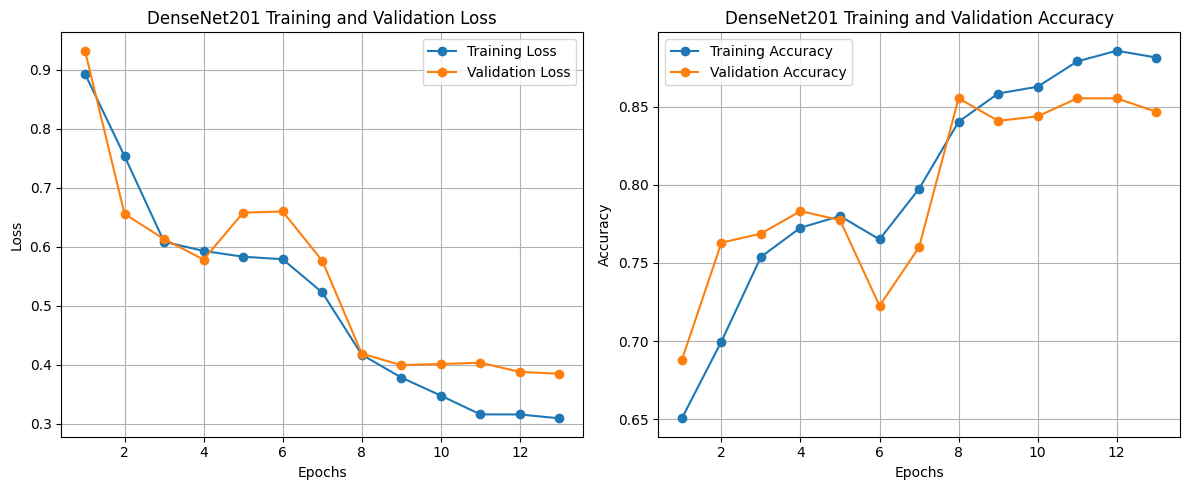


--- Evaluating DenseNet201 on Test Set ---
Test Accuracy for DenseNet201: 0.8571
Classification Report for DenseNet201:
              precision    recall  f1-score   support

         abn       0.91      0.83      0.87       123
         bmt       0.73      0.76      0.75        29
        malg       0.58      0.80      0.67        40
         nml       0.92      0.94      0.93        65
         stn       0.96      0.90      0.93        86

    accuracy                           0.86       343
   macro avg       0.82      0.84      0.83       343
weighted avg       0.87      0.86      0.86       343



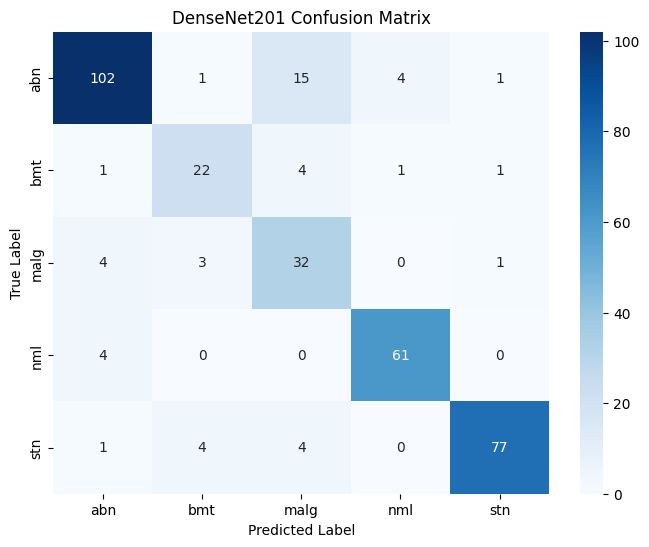

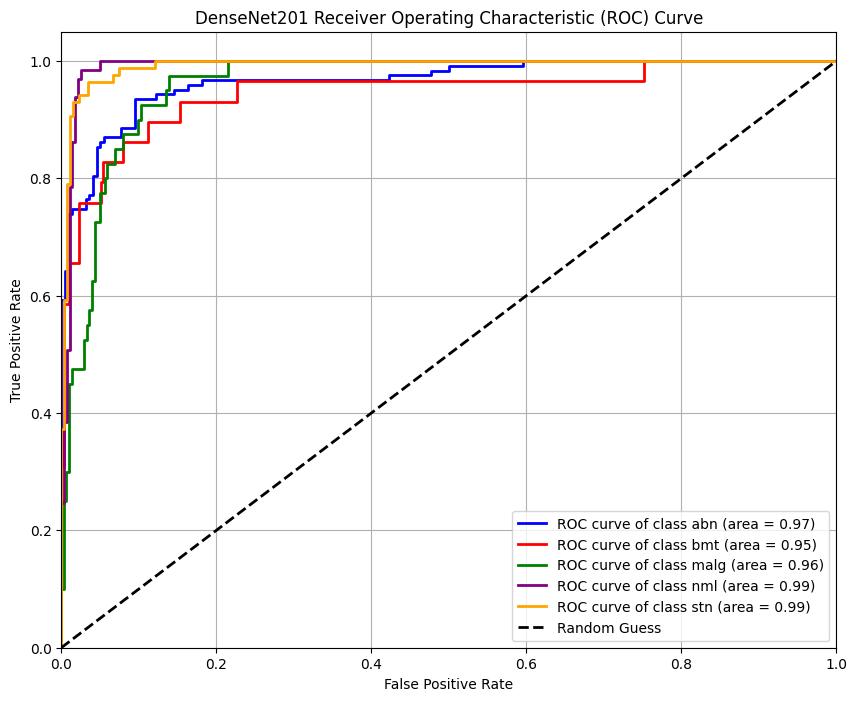

In [ ]:
densenet201_model = get_model("densenet201", num_classes=len(class_names))
trained_densenet201_model, train_loss_d201, val_loss_d201, train_acc_d201, val_acc_d201 = train_model(densenet201_model, "DenseNet201", epochs=30, patience=5)
plot_accuracy_loss(train_loss_d201, val_loss_d201, train_acc_d201, val_acc_d201, "DenseNet201")
y_true_d201, y_pred_classes_d201, y_pred_scores_d201 = evaluate_model_on_test(trained_densenet201_model, "DenseNet201")
plot_confusion_matrix(y_true_d201, y_pred_classes_d201, class_names, "DenseNet201")
plot_roc_curve(label_binarize(y_true_d201, classes=list(range(NUM_CLASSES))), y_pred_scores_d201, NUM_CLASSES, class_names, "DenseNet201")
all_trained_models.append(trained_densenet201_model)

### EfficientNet-B1

Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to C:\Users\offic/.cache\torch\hub\checkpoints\efficientnet_b1_rwightman-bac287d4.pth


100%|██████████| 30.1M/30.1M [00:02<00:00, 11.6MB/s]



--- Training EfficientNetB1 ---
Epoch 0/29
----------
training Loss: 0.8269 Acc: 0.6984
validation Loss: 0.7070 Acc: 0.6850
Epoch 1/29
----------
training Loss: 0.5775 Acc: 0.7869
validation Loss: 0.5285 Acc: 0.8208
Epoch 2/29
----------
training Loss: 0.4340 Acc: 0.8349
validation Loss: 0.4675 Acc: 0.8410
Epoch 3/29
----------
training Loss: 0.4052 Acc: 0.8380
validation Loss: 0.4889 Acc: 0.8179
Epoch 4/29
----------
training Loss: 0.3487 Acc: 0.8723
validation Loss: 0.4915 Acc: 0.8410
Epoch 5/29
----------
training Loss: 0.2652 Acc: 0.9059
validation Loss: 0.5029 Acc: 0.8382
Epoch 6/29
----------
training Loss: 0.2439 Acc: 0.9072
validation Loss: 0.5337 Acc: 0.8121
Epoch 7/29
----------
training Loss: 0.1976 Acc: 0.9308
validation Loss: 0.3784 Acc: 0.8757
Epoch 8/29
----------
training Loss: 0.1199 Acc: 0.9607
validation Loss: 0.3603 Acc: 0.8757
Epoch 9/29
----------
training Loss: 0.1040 Acc: 0.9645
validation Loss: 0.3821 Acc: 0.8699
Epoch 10/29
----------
training Loss: 0.0856 Ac

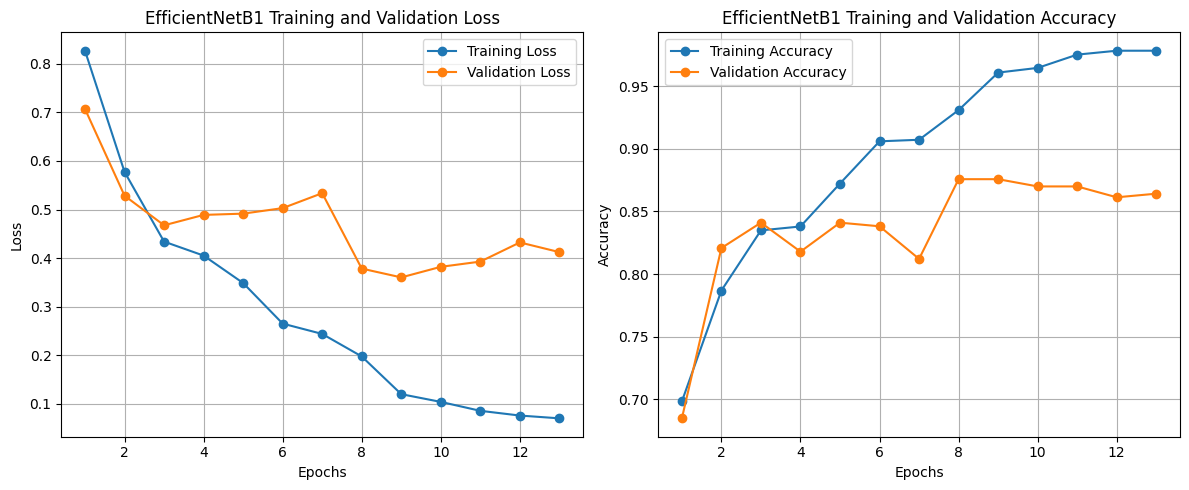


--- Evaluating EfficientNetB1 on Test Set ---
Test Accuracy for EfficientNetB1: 0.8630
Classification Report for EfficientNetB1:
              precision    recall  f1-score   support

         abn       0.89      0.83      0.86       123
         bmt       0.79      0.66      0.72        29
        malg       0.67      0.82      0.74        40
         nml       0.92      0.94      0.93        65
         stn       0.90      0.94      0.92        86

    accuracy                           0.86       343
   macro avg       0.84      0.84      0.83       343
weighted avg       0.87      0.86      0.86       343



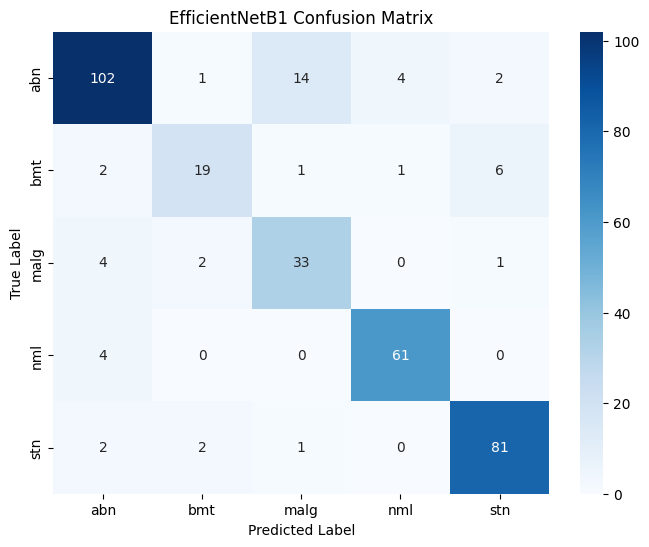

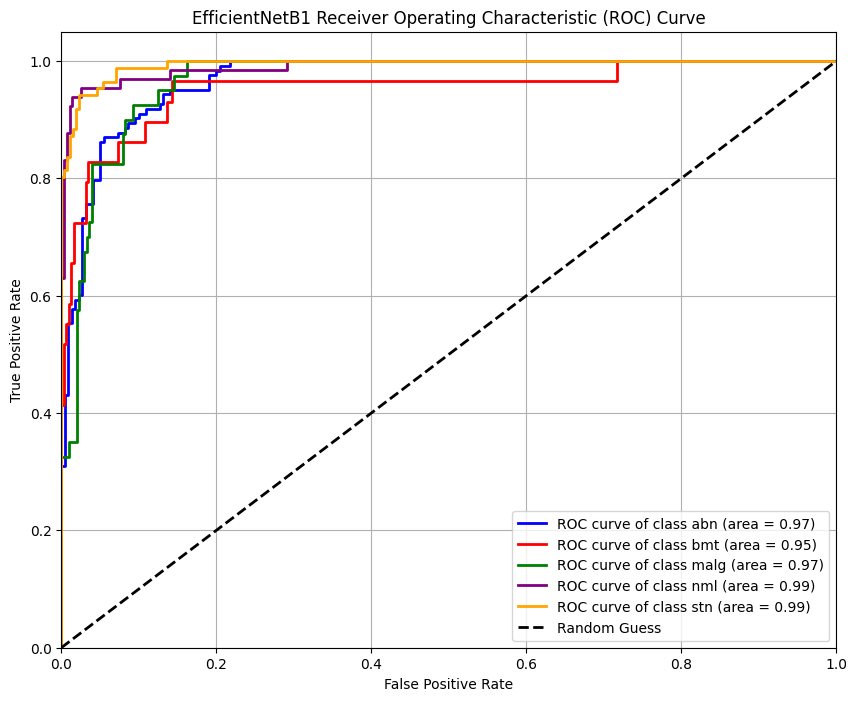

In [ ]:
efficientnet_b1_model = get_model("efficientnet_b1", num_classes=len(class_names))
trained_efficientnet_b1_model, train_loss_eb1, val_loss_eb1, train_acc_eb1, val_acc_eb1 = train_model(efficientnet_b1_model, "EfficientNetB1", epochs=30, patience=5)
plot_accuracy_loss(train_loss_eb1, val_loss_eb1, train_acc_eb1, val_acc_eb1, "EfficientNetB1")
y_true_eb1, y_pred_classes_eb1, y_pred_scores_eb1 = evaluate_model_on_test(trained_efficientnet_b1_model, "EfficientNetB1")
plot_confusion_matrix(y_true_eb1, y_pred_classes_eb1, class_names, "EfficientNetB1")
plot_roc_curve(label_binarize(y_true_eb1, classes=list(range(NUM_CLASSES))), y_pred_scores_eb1, NUM_CLASSES, class_names, "EfficientNetB1")
all_trained_models.append(trained_efficientnet_b1_model)

### EfficientNet-B2

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to C:\Users\offic/.cache\torch\hub\checkpoints\efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:03<00:00, 11.6MB/s]



--- Training EfficientNetB2 ---
Epoch 0/29
----------
training Loss: 0.7988 Acc: 0.6885
validation Loss: 0.7565 Acc: 0.7081
Epoch 1/29
----------
training Loss: 0.6005 Acc: 0.7826
validation Loss: 0.5885 Acc: 0.7803
Epoch 2/29
----------
training Loss: 0.4687 Acc: 0.8087
validation Loss: 0.5065 Acc: 0.8208
Epoch 3/29
----------
training Loss: 0.4209 Acc: 0.8548
validation Loss: 0.5453 Acc: 0.8237
Epoch 4/29
----------
training Loss: 0.3647 Acc: 0.8548
validation Loss: 0.5556 Acc: 0.8035
Epoch 5/29
----------
training Loss: 0.3390 Acc: 0.8779
validation Loss: 0.4982 Acc: 0.8324
Epoch 6/29
----------
training Loss: 0.2803 Acc: 0.8910
validation Loss: 0.6994 Acc: 0.7948
Epoch 7/29
----------
training Loss: 0.1855 Acc: 0.9321
validation Loss: 0.4560 Acc: 0.8555
Epoch 8/29
----------
training Loss: 0.1447 Acc: 0.9477
validation Loss: 0.4334 Acc: 0.8699
Epoch 9/29
----------
training Loss: 0.1109 Acc: 0.9601
validation Loss: 0.4319 Acc: 0.8815
Epoch 10/29
----------
training Loss: 0.1047 Ac

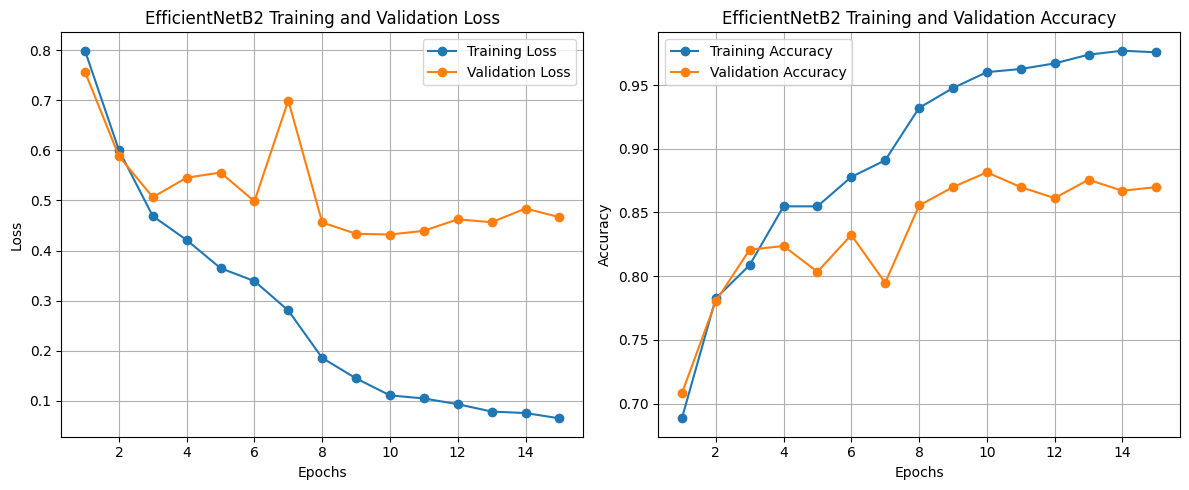


--- Evaluating EfficientNetB2 on Test Set ---
Test Accuracy for EfficientNetB2: 0.8630
Classification Report for EfficientNetB2:
              precision    recall  f1-score   support

         abn       0.91      0.84      0.87       123
         bmt       0.76      0.66      0.70        29
        malg       0.63      0.85      0.72        40
         nml       0.97      0.92      0.94        65
         stn       0.90      0.93      0.91        86

    accuracy                           0.86       343
   macro avg       0.83      0.84      0.83       343
weighted avg       0.87      0.86      0.87       343



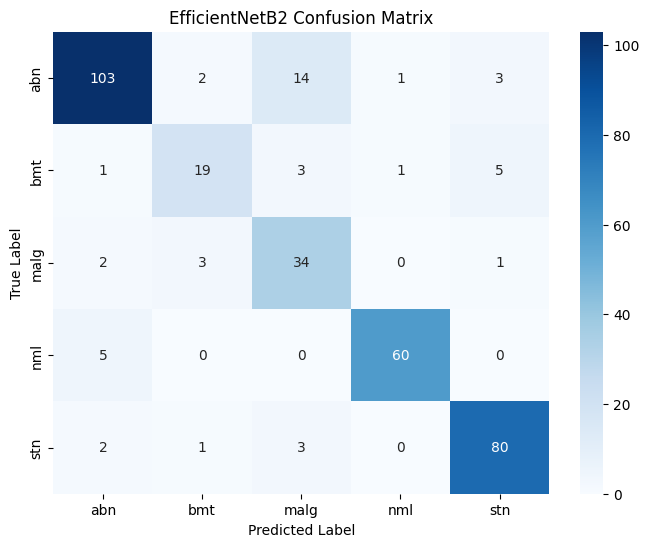

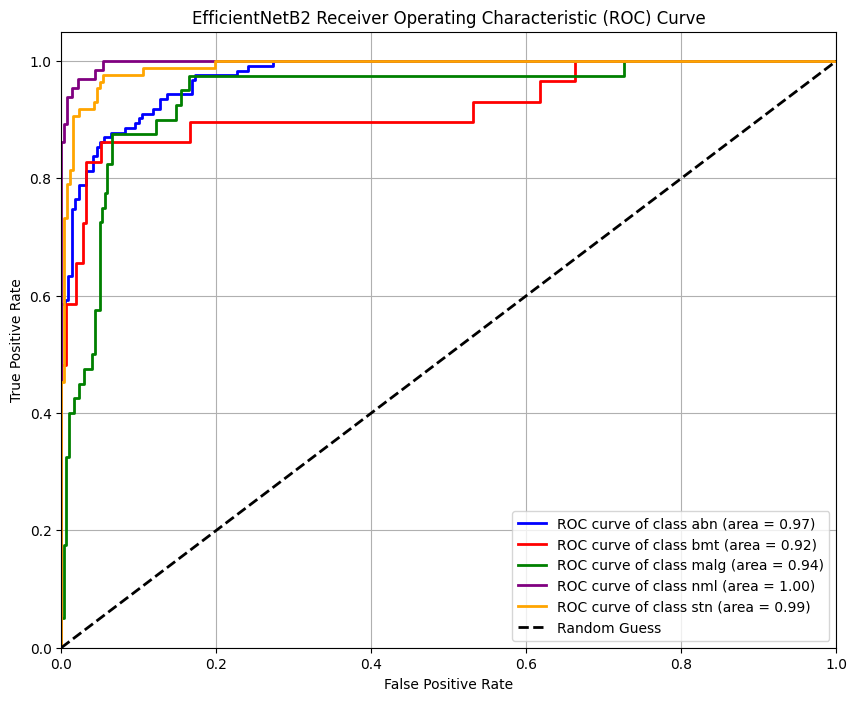

In [ ]:
efficientnet_b2_model = get_model("efficientnet_b2", num_classes=len(class_names))
trained_efficientnet_b2_model, train_loss_eb2, val_loss_eb2, train_acc_eb2, val_acc_eb2 = train_model(efficientnet_b2_model, "EfficientNetB2", epochs=30, patience=5)
plot_accuracy_loss(train_loss_eb2, val_loss_eb2, train_acc_eb2, val_acc_eb2, "EfficientNetB2")
y_true_eb2, y_pred_classes_eb2, y_pred_scores_eb2 = evaluate_model_on_test(trained_efficientnet_b2_model, "EfficientNetB2")
plot_confusion_matrix(y_true_eb2, y_pred_classes_eb2, class_names, "EfficientNetB2")
plot_roc_curve(label_binarize(y_true_eb2, classes=list(range(NUM_CLASSES))), y_pred_scores_eb2, NUM_CLASSES, class_names, "EfficientNetB2")
all_trained_models.append(trained_efficientnet_b2_model)

### EfficientNet-B3

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to C:\Users\offic/.cache\torch\hub\checkpoints\efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:04<00:00, 11.6MB/s]



--- Training EfficientNetB3 ---
Epoch 0/29
----------
training Loss: 0.8061 Acc: 0.6972
validation Loss: 0.6571 Acc: 0.7861
Epoch 1/29
----------
training Loss: 0.5457 Acc: 0.8100
validation Loss: 0.6241 Acc: 0.8064
Epoch 2/29
----------
training Loss: 0.4325 Acc: 0.8380
validation Loss: 0.5235 Acc: 0.8121
Epoch 3/29
----------
training Loss: 0.3650 Acc: 0.8648
validation Loss: 0.4723 Acc: 0.8092
Epoch 4/29
----------
training Loss: 0.3368 Acc: 0.8773
validation Loss: 0.4698 Acc: 0.8584
Epoch 5/29
----------
training Loss: 0.2957 Acc: 0.8941
validation Loss: 0.4798 Acc: 0.8295
Epoch 6/29
----------
training Loss: 0.3144 Acc: 0.8903
validation Loss: 0.4050 Acc: 0.8468
Epoch 7/29
----------
training Loss: 0.1613 Acc: 0.9495
validation Loss: 0.3765 Acc: 0.8526
Epoch 8/29
----------
training Loss: 0.1429 Acc: 0.9514
validation Loss: 0.3732 Acc: 0.8642
Epoch 9/29
----------
training Loss: 0.1161 Acc: 0.9626
validation Loss: 0.4062 Acc: 0.8613
Epoch 10/29
----------
training Loss: 0.1032 Ac

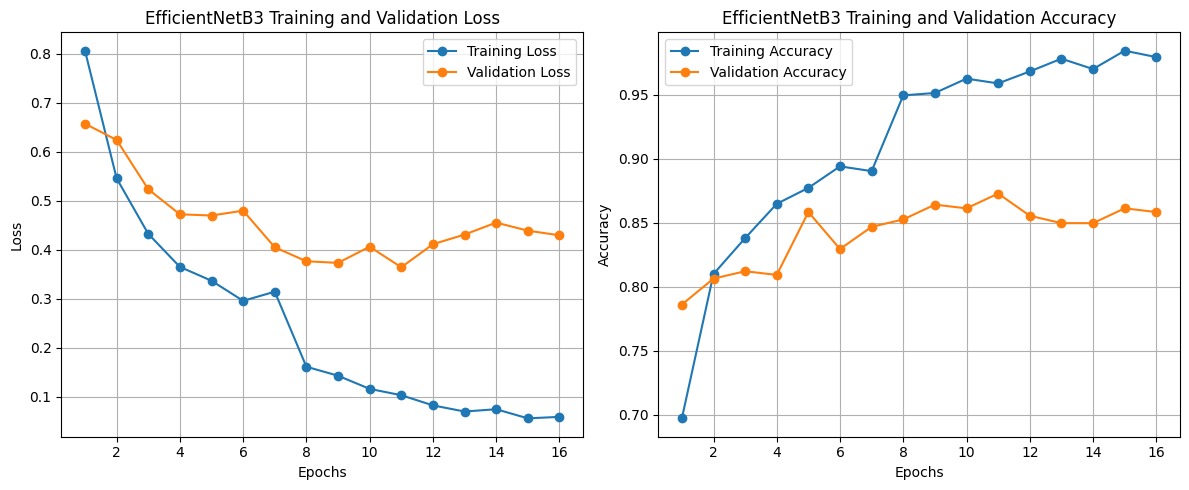


--- Evaluating EfficientNetB3 on Test Set ---
Test Accuracy for EfficientNetB3: 0.8717
Classification Report for EfficientNetB3:
              precision    recall  f1-score   support

         abn       0.91      0.87      0.89       123
         bmt       0.73      0.66      0.69        29
        malg       0.63      0.78      0.70        40
         nml       0.95      0.94      0.95        65
         stn       0.94      0.94      0.94        86

    accuracy                           0.87       343
   macro avg       0.83      0.84      0.83       343
weighted avg       0.88      0.87      0.87       343



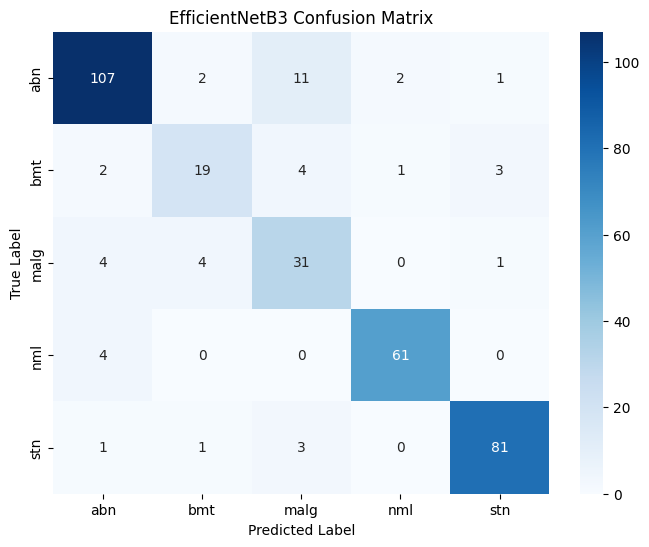

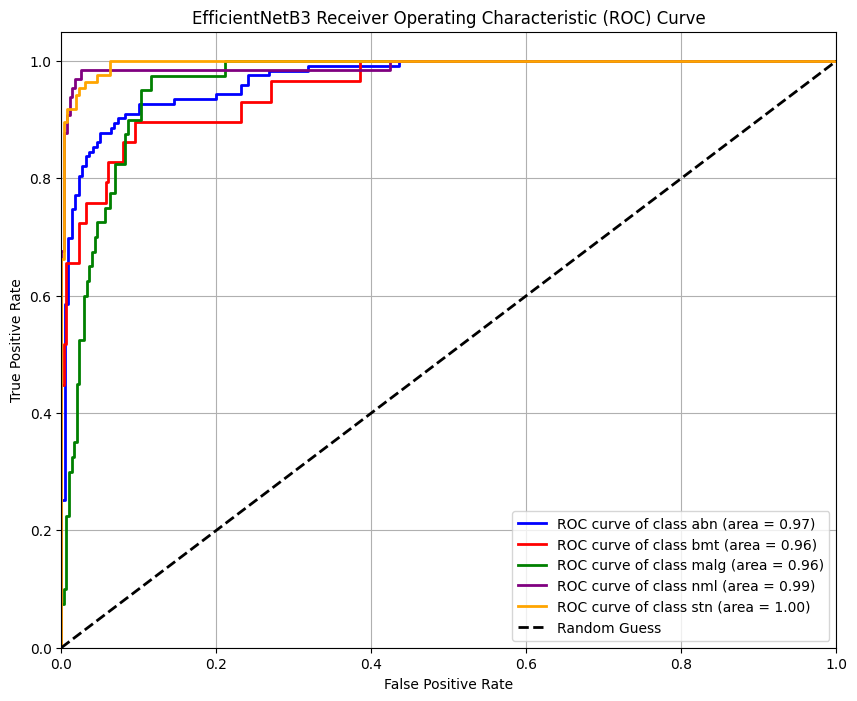

In [ ]:
efficientnet_b3_model = get_model("efficientnet_b3", num_classes=len(class_names))
trained_efficientnet_b3_model, train_loss_eb3, val_loss_eb3, train_acc_eb3, val_acc_eb3 = train_model(efficientnet_b3_model, "EfficientNetB3", epochs=30, patience=5)
plot_accuracy_loss(train_loss_eb3, val_loss_eb3, train_acc_eb3, val_acc_eb3, "EfficientNetB3")
y_true_eb3, y_pred_classes_eb3, y_pred_scores_eb3 = evaluate_model_on_test(trained_efficientnet_b3_model, "EfficientNetB3")
plot_confusion_matrix(y_true_eb3, y_pred_classes_eb3, class_names, "EfficientNetB3")
plot_roc_curve(label_binarize(y_true_eb3, classes=list(range(NUM_CLASSES))), y_pred_scores_eb3, NUM_CLASSES, class_names, "EfficientNetB3")
all_trained_models.append(trained_efficientnet_b3_model)

### EfficientNet-B4

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to C:\Users\offic/.cache\torch\hub\checkpoints\efficientnet_b4_rwightman-23ab8bcd.pth


100%|██████████| 74.5M/74.5M [00:06<00:00, 11.6MB/s]



--- Training EfficientNetB4 ---
Epoch 0/29
----------
training Loss: 0.9336 Acc: 0.6343
validation Loss: 0.5810 Acc: 0.7659
Epoch 1/29
----------
training Loss: 0.5366 Acc: 0.7975
validation Loss: 0.4956 Acc: 0.8237
Epoch 2/29
----------
training Loss: 0.3884 Acc: 0.8548
validation Loss: 0.5172 Acc: 0.8035
Epoch 3/29
----------
training Loss: 0.3208 Acc: 0.8804
validation Loss: 0.4950 Acc: 0.8179
Epoch 4/29
----------
training Loss: 0.2255 Acc: 0.9171
validation Loss: 0.6188 Acc: 0.8237
Epoch 5/29
----------
training Loss: 0.2476 Acc: 0.9059
validation Loss: 0.5349 Acc: 0.7919
Epoch 6/29
----------
training Loss: 0.2116 Acc: 0.9246
validation Loss: 0.4977 Acc: 0.8324
Epoch 7/29
----------
training Loss: 0.1412 Acc: 0.9533
validation Loss: 0.4646 Acc: 0.8410
Epoch 8/29
----------
training Loss: 0.1111 Acc: 0.9583
validation Loss: 0.4727 Acc: 0.8468
Epoch 9/29
----------
training Loss: 0.0846 Acc: 0.9707
validation Loss: 0.5036 Acc: 0.8295
Epoch 10/29
----------
training Loss: 0.0969 Ac

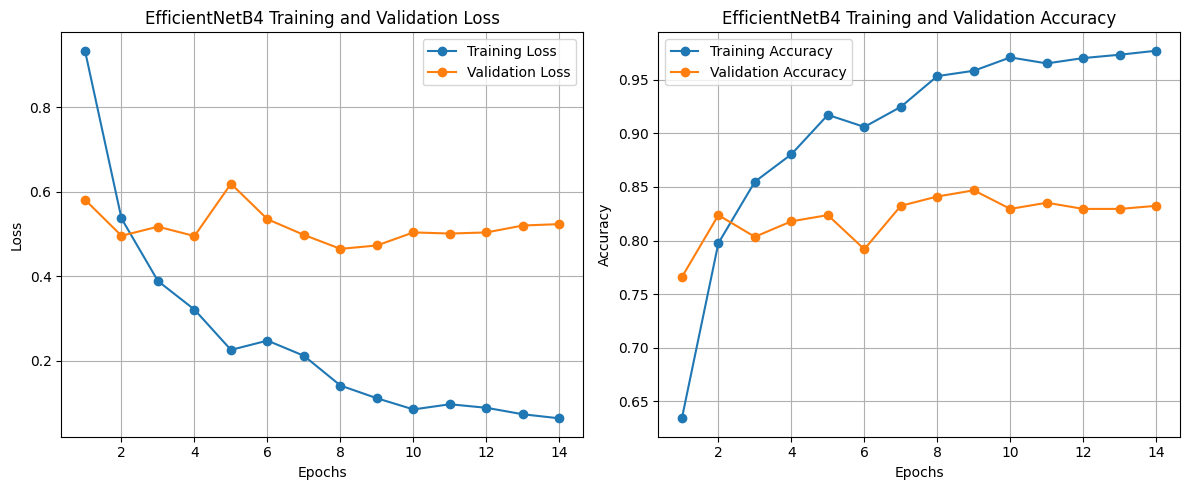


--- Evaluating EfficientNetB4 on Test Set ---
Test Accuracy for EfficientNetB4: 0.8776
Classification Report for EfficientNetB4:
              precision    recall  f1-score   support

         abn       0.91      0.86      0.89       123
         bmt       0.82      0.79      0.81        29
        malg       0.63      0.78      0.70        40
         nml       0.94      0.94      0.94        65
         stn       0.94      0.93      0.94        86

    accuracy                           0.88       343
   macro avg       0.85      0.86      0.85       343
weighted avg       0.88      0.88      0.88       343



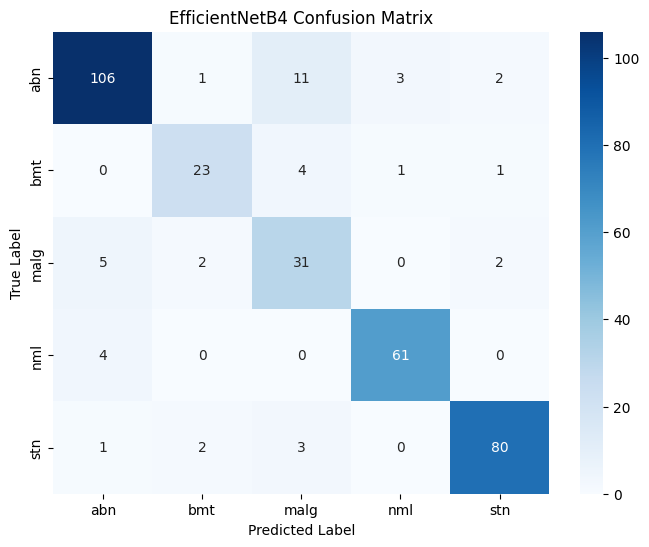

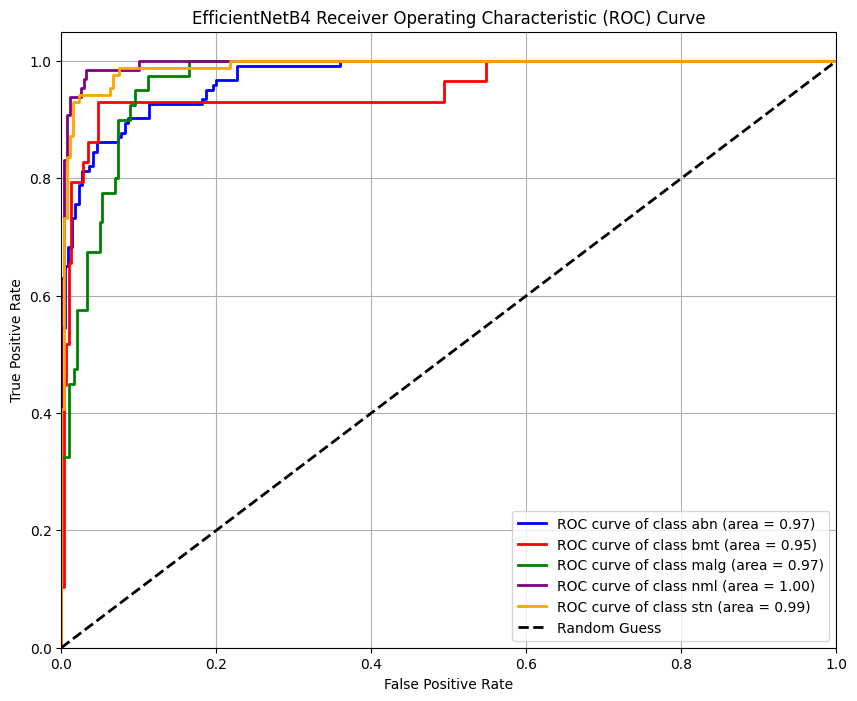

In [ ]:
efficientnet_b4_model = get_model("efficientnet_b4", num_classes=len(class_names))
trained_efficientnet_b4_model, train_loss_eb4, val_loss_eb4, train_acc_eb4, val_acc_eb4 = train_model(efficientnet_b4_model, "EfficientNetB4", epochs=30, patience=5)
plot_accuracy_loss(train_loss_eb4, val_loss_eb4, train_acc_eb4, val_acc_eb4, "EfficientNetB4")
y_true_eb4, y_pred_classes_eb4, y_pred_scores_eb4 = evaluate_model_on_test(trained_efficientnet_b4_model, "EfficientNetB4")
plot_confusion_matrix(y_true_eb4, y_pred_classes_eb4, class_names, "EfficientNetB4")
plot_roc_curve(label_binarize(y_true_eb4, classes=list(range(NUM_CLASSES))), y_pred_scores_eb4, NUM_CLASSES, class_names, "EfficientNetB4")
all_trained_models.append(trained_efficientnet_b4_model)

### ResNet-50 V1

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\offic/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:08<00:00, 11.5MB/s]



--- Training ResNet50V1 ---
Epoch 0/29
----------
training Loss: 1.0501 Acc: 0.5838
validation Loss: 1.4931 Acc: 0.5809
Epoch 1/29
----------
training Loss: 0.8398 Acc: 0.6567
validation Loss: 0.8358 Acc: 0.6936
Epoch 2/29
----------
training Loss: 0.7309 Acc: 0.7022
validation Loss: 0.6581 Acc: 0.7428
Epoch 3/29
----------
training Loss: 0.7011 Acc: 0.7271
validation Loss: 1.2172 Acc: 0.5694
Epoch 4/29
----------
training Loss: 0.7261 Acc: 0.7103
validation Loss: 0.7848 Acc: 0.6908
Epoch 5/29
----------
training Loss: 0.6197 Acc: 0.7657
validation Loss: 0.8376 Acc: 0.6908
Epoch 6/29
----------
training Loss: 0.6092 Acc: 0.7657
validation Loss: 1.1477 Acc: 0.6040
Epoch 7/29
----------
training Loss: 0.5032 Acc: 0.8006
validation Loss: 0.4810 Acc: 0.8092
Epoch 8/29
----------
training Loss: 0.4489 Acc: 0.8380
validation Loss: 0.4530 Acc: 0.8295
Epoch 9/29
----------
training Loss: 0.4332 Acc: 0.8336
validation Loss: 0.4553 Acc: 0.8295
Epoch 10/29
----------
training Loss: 0.3962 Acc: 0

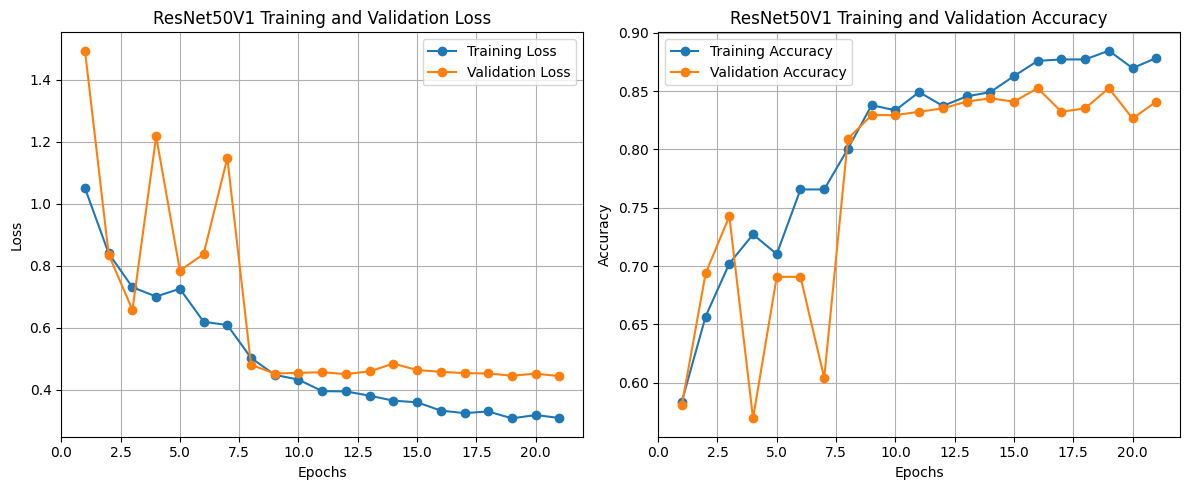


--- Evaluating ResNet50V1 on Test Set ---
Test Accuracy for ResNet50V1: 0.8571
Classification Report for ResNet50V1:
              precision    recall  f1-score   support

         abn       0.92      0.84      0.88       123
         bmt       0.78      0.62      0.69        29
        malg       0.65      0.88      0.74        40
         nml       0.92      0.91      0.91        65
         stn       0.88      0.92      0.90        86

    accuracy                           0.86       343
   macro avg       0.83      0.83      0.83       343
weighted avg       0.87      0.86      0.86       343



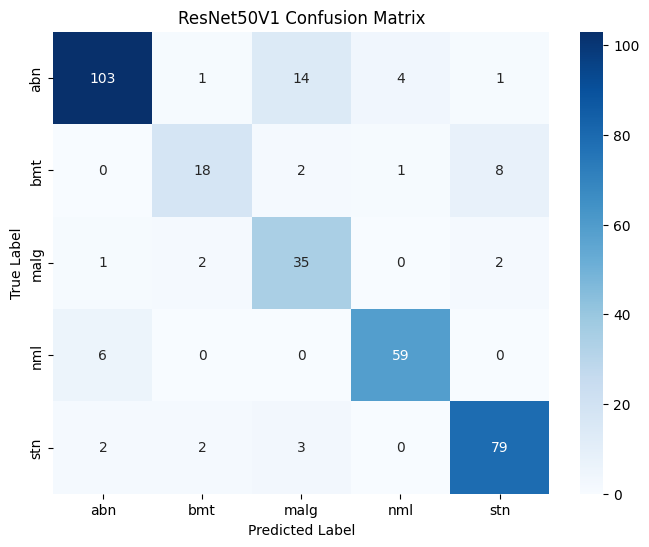

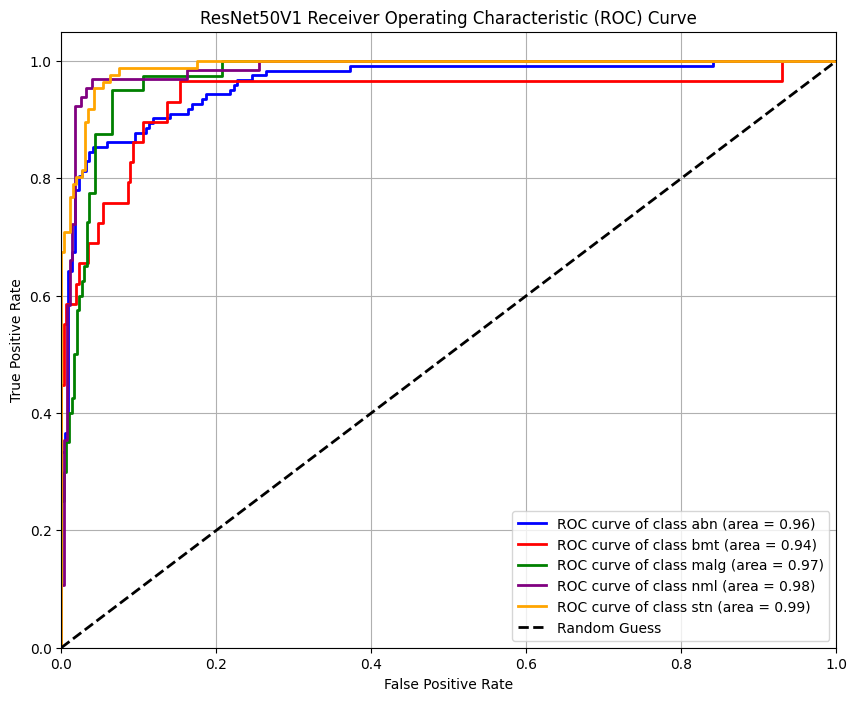

In [ ]:
resnet50_v1_model = get_model("resnet50_v1", num_classes=len(class_names))
trained_resnet50_v1_model, train_loss_r50v1, val_loss_r50v1, train_acc_r50v1, val_acc_r50v1 = train_model(resnet50_v1_model, "ResNet50V1", epochs=30, patience=5)
plot_accuracy_loss(train_loss_r50v1, val_loss_r50v1, train_acc_r50v1, val_acc_r50v1, "ResNet50V1")
y_true_r50v1, y_pred_classes_r50v1, y_pred_scores_r50v1 = evaluate_model_on_test(trained_resnet50_v1_model, "ResNet50V1")
plot_confusion_matrix(y_true_r50v1, y_pred_classes_r50v1, class_names, "ResNet50V1")
plot_roc_curve(label_binarize(y_true_r50v1, classes=list(range(NUM_CLASSES))), y_pred_scores_r50v1, NUM_CLASSES, class_names, "ResNet50V1")
all_trained_models.append(trained_resnet50_v1_model)

### ResNet-50 V2

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\offic/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:09<00:00, 11.3MB/s]



--- Training ResNet50V2 ---
Epoch 0/29
----------
training Loss: 0.9294 Acc: 0.6604
validation Loss: 1.3044 Acc: 0.5954
Epoch 1/29
----------
training Loss: 0.6618 Acc: 0.7470
validation Loss: 0.6573 Acc: 0.7543
Epoch 2/29
----------
training Loss: 0.6124 Acc: 0.7508
validation Loss: 0.5742 Acc: 0.7688
Epoch 3/29
----------
training Loss: 0.5625 Acc: 0.7944
validation Loss: 0.5832 Acc: 0.7601
Epoch 4/29
----------
training Loss: 0.5115 Acc: 0.7994
validation Loss: 0.6219 Acc: 0.7543
Epoch 5/29
----------
training Loss: 0.5050 Acc: 0.8093
validation Loss: 0.5407 Acc: 0.7977
Epoch 6/29
----------
training Loss: 0.4531 Acc: 0.8287
validation Loss: 0.5138 Acc: 0.7948
Epoch 7/29
----------
training Loss: 0.3136 Acc: 0.8847
validation Loss: 0.4109 Acc: 0.8353
Epoch 8/29
----------
training Loss: 0.2639 Acc: 0.9022
validation Loss: 0.4119 Acc: 0.8468
Epoch 9/29
----------
training Loss: 0.2423 Acc: 0.9165
validation Loss: 0.3972 Acc: 0.8382
Epoch 10/29
----------
training Loss: 0.2200 Acc: 0

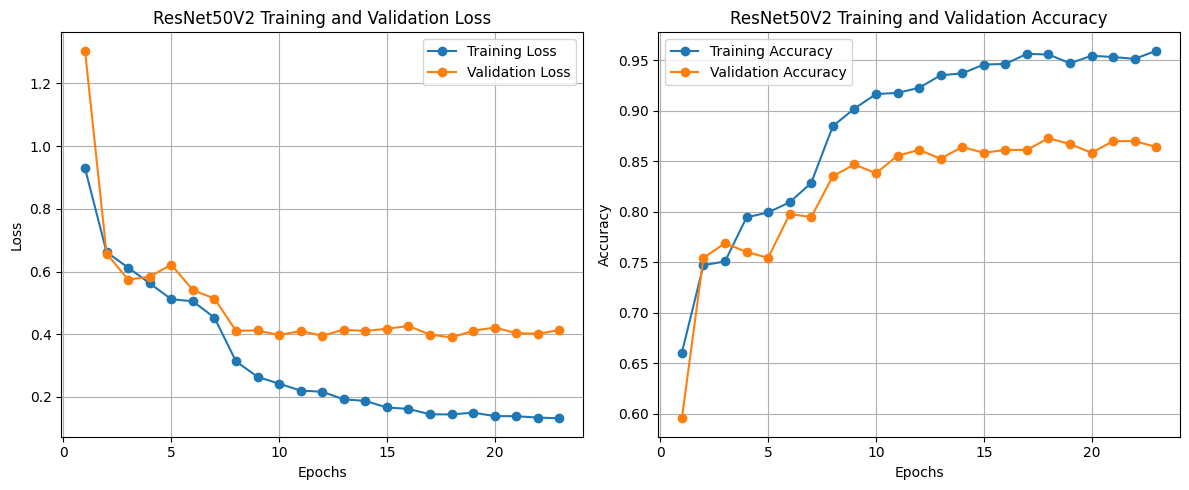


--- Evaluating ResNet50V2 on Test Set ---
Test Accuracy for ResNet50V2: 0.8571
Classification Report for ResNet50V2:
              precision    recall  f1-score   support

         abn       0.90      0.84      0.87       123
         bmt       0.77      0.79      0.78        29
        malg       0.65      0.82      0.73        40
         nml       0.88      0.92      0.90        65
         stn       0.94      0.87      0.90        86

    accuracy                           0.86       343
   macro avg       0.83      0.85      0.84       343
weighted avg       0.87      0.86      0.86       343



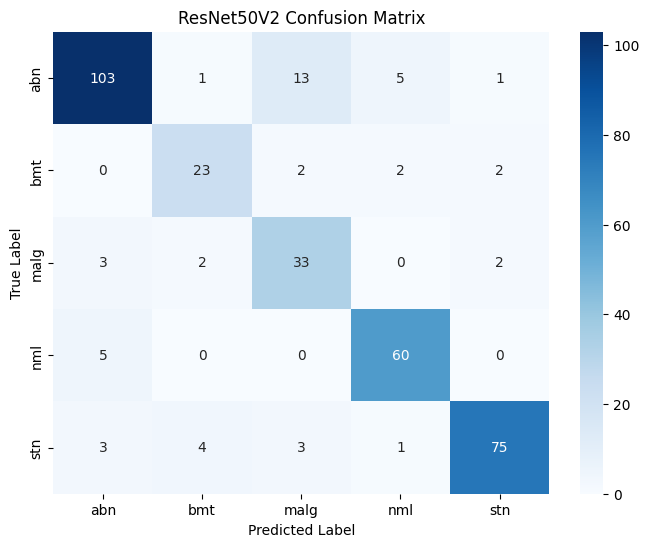

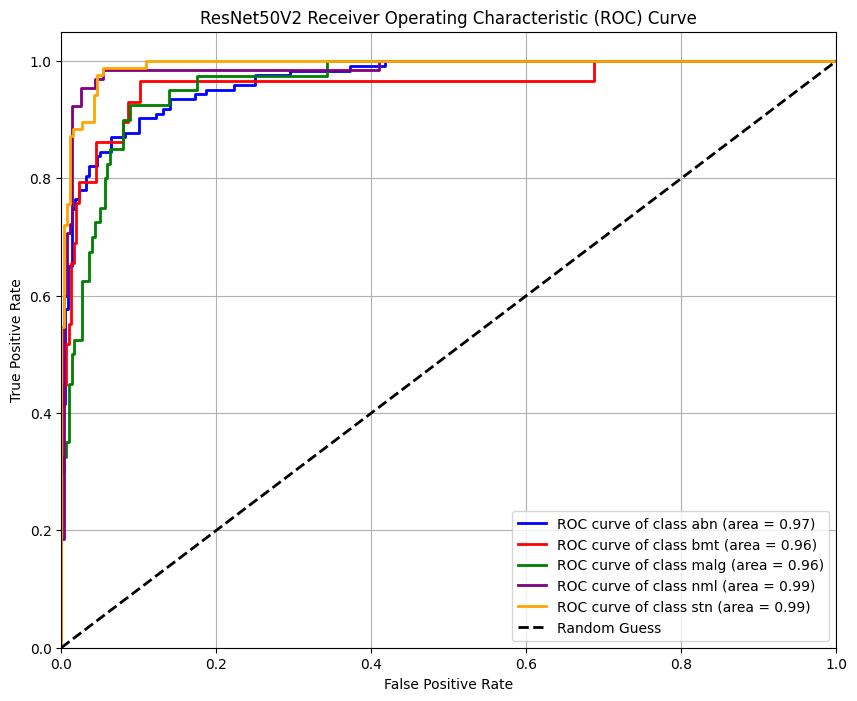

In [ ]:
resnet50_v2_model = get_model("resnet50_v2", num_classes=len(class_names))
trained_resnet50_v2_model, train_loss_r50v2, val_loss_r50v2, train_acc_r50v2, val_acc_r50v2 = train_model(resnet50_v2_model, "ResNet50V2", epochs=30, patience=5)
plot_accuracy_loss(train_loss_r50v2, val_loss_r50v2, train_acc_r50v2, val_acc_r50v2, "ResNet50V2")
y_true_r50v2, y_pred_classes_r50v2, y_pred_scores_r50v2 = evaluate_model_on_test(trained_resnet50_v2_model, "ResNet50V2")
plot_confusion_matrix(y_true_r50v2, y_pred_classes_r50v2, class_names, "ResNet50V2")
plot_roc_curve(label_binarize(y_true_r50v2, classes=list(range(NUM_CLASSES))), y_pred_scores_r50v2, NUM_CLASSES, class_names, "ResNet50V2")
all_trained_models.append(trained_resnet50_v2_model)

### GBCNet


--- Training GBCNet ---
Epoch 0/29
----------
training Loss: 1.1891 Acc: 0.5333
validation Loss: 1.1988 Acc: 0.5202
Epoch 1/29
----------
training Loss: 1.0517 Acc: 0.5620
validation Loss: 1.1264 Acc: 0.5549
Epoch 2/29
----------
training Loss: 1.0318 Acc: 0.5651
validation Loss: 1.0231 Acc: 0.5694
Epoch 3/29
----------
training Loss: 0.9915 Acc: 0.5807
validation Loss: 1.0425 Acc: 0.5607
Epoch 4/29
----------
training Loss: 0.9700 Acc: 0.5925
validation Loss: 0.9586 Acc: 0.5896
Epoch 5/29
----------
training Loss: 0.9546 Acc: 0.5819
validation Loss: 1.0970 Acc: 0.5665
Epoch 6/29
----------
training Loss: 0.9575 Acc: 0.5807
validation Loss: 1.1923 Acc: 0.5376
Epoch 7/29
----------
training Loss: 0.9233 Acc: 0.5950
validation Loss: 0.9541 Acc: 0.5694
Epoch 8/29
----------
training Loss: 0.9003 Acc: 0.6212
validation Loss: 0.9462 Acc: 0.5751
Epoch 9/29
----------
training Loss: 0.9032 Acc: 0.6162
validation Loss: 0.9451 Acc: 0.5809
Early stopping triggered.
Best val Acc: 0.5896


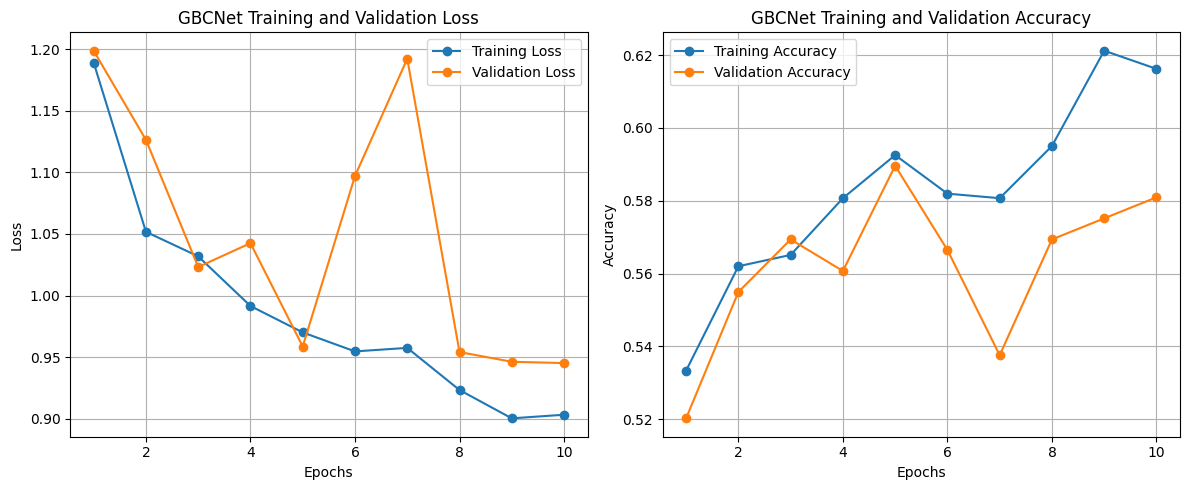


--- Evaluating GBCNet on Test Set ---
Test Accuracy for GBCNet: 0.6122
Classification Report for GBCNet:
              precision    recall  f1-score   support

         abn       0.60      0.85      0.70       123
         bmt       1.00      0.07      0.13        29
        malg       0.53      0.40      0.46        40
         nml       0.57      0.06      0.11        65
         stn       0.64      0.97      0.77        86

    accuracy                           0.61       343
   macro avg       0.67      0.47      0.43       343
weighted avg       0.63      0.61      0.53       343



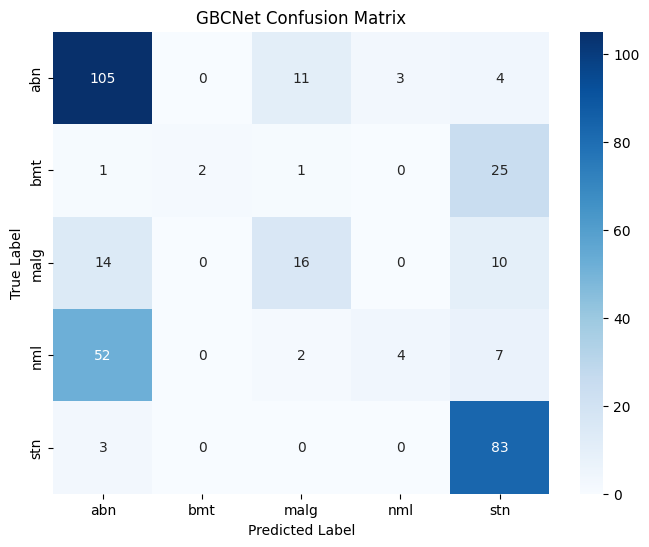

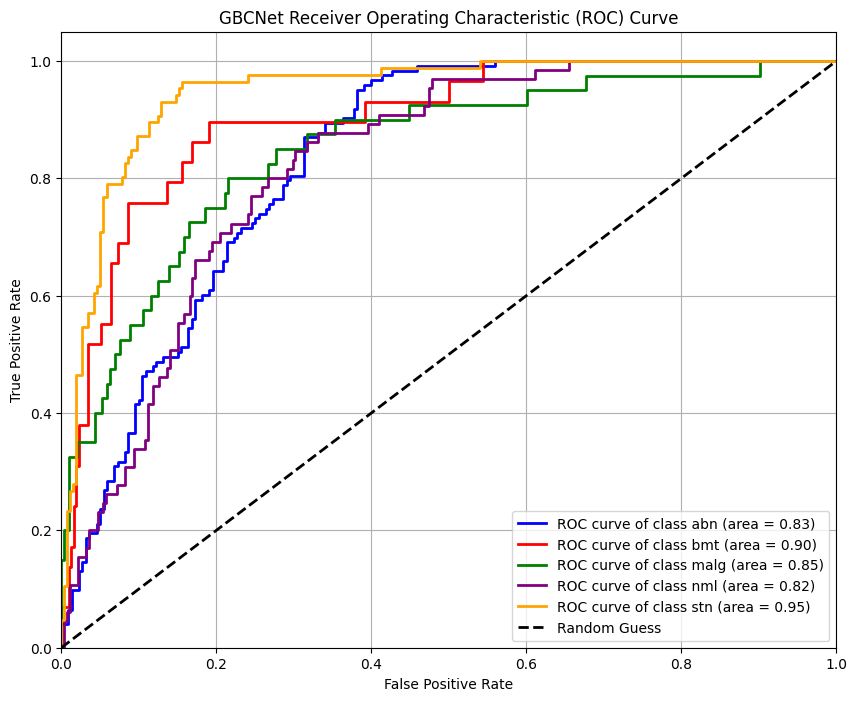

In [ ]:
gbcnet_model = get_model("gbcnet", num_classes=len(class_names))
trained_gbcnet_model, train_loss_gbc, val_loss_gbc, train_acc_gbc, val_acc_gbc = train_model(gbcnet_model, "GBCNet", epochs=30, patience=5)
plot_accuracy_loss(train_loss_gbc, val_loss_gbc, train_acc_gbc, val_acc_gbc, "GBCNet")
y_true_gbc, y_pred_classes_gbc, y_pred_scores_gbc = evaluate_model_on_test(trained_gbcnet_model, "GBCNet")
plot_confusion_matrix(y_true_gbc, y_pred_classes_gbc, class_names, "GBCNet")
plot_roc_curve(label_binarize(y_true_gbc, classes=list(range(NUM_CLASSES))), y_pred_scores_gbc, NUM_CLASSES, class_names, "GBCNet")
all_trained_models.append(trained_gbcnet_model)

### RadFormer

In [ ]:
radformer_model = get_model("radformer", num_classes=len(class_names))
trained_radformer_model, train_loss_rad, val_loss_rad, train_acc_rad, val_acc_rad = train_model(radformer_model, "RadFormer", epochs=30, patience=5)
plot_accuracy_loss(train_loss_rad, val_loss_rad, train_acc_rad, val_acc_rad, "RadFormer")
y_true_rad, y_pred_classes_rad, y_pred_scores_rad = evaluate_model_on_test(trained_radformer_model, "RadFormer")
plot_confusion_matrix(y_true_rad, y_pred_classes_rad, class_names, "RadFormer")
plot_roc_curve(label_binarize(y_true_rad, classes=list(range(NUM_CLASSES))), y_pred_scores_rad, NUM_CLASSES, class_names, "RadFormer")
all_trained_models.append(trained_radformer_model)

# Cancelled (Too low result)


--- Training RadFormer ---
Epoch 0/29
----------


KeyboardInterrupt: 

### Ensemble Evaluation


--- Performing Ensemble Evaluation ---
Ensemble Test Accuracy: 0.8834
Ensemble Classification Report:
              precision    recall  f1-score   support

         abn       0.92      0.86      0.89       123
         bmt       0.81      0.76      0.79        29
        malg       0.67      0.85      0.75        40
         nml       0.92      0.94      0.93        65
         stn       0.95      0.93      0.94        86

    accuracy                           0.88       343
   macro avg       0.86      0.87      0.86       343
weighted avg       0.89      0.88      0.89       343



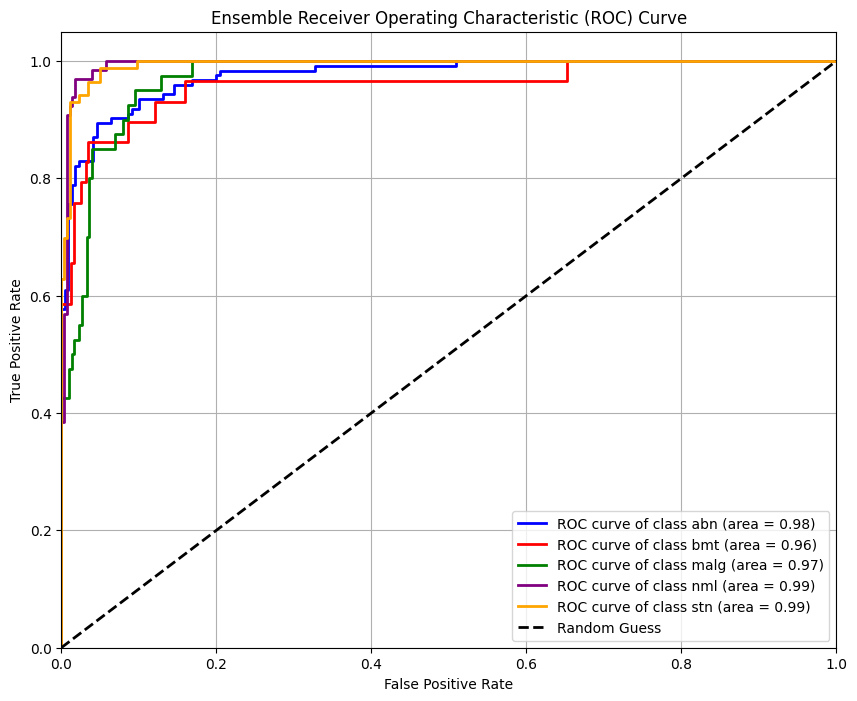

In [ ]:
ensemble_accuracy, ensemble_probs, y_true_ensemble = ensemble_evaluate(all_trained_models, test_loader, class_names, device)
model_results["Ensemble"] = ensemble_accuracy
plot_roc_curve(label_binarize(y_true_ensemble, classes=list(range(NUM_CLASSES))), ensemble_probs, NUM_CLASSES, class_names, "Ensemble")

### Table

In [ ]:
print("\nModel Performance Summary (Including Ensemble - All Test Accuracies):\\n")
results_df = pd.DataFrame(list(model_results.items()), columns=["Model", "Test Accuracy"])
results_df["Test Accuracy"] = results_df["Test Accuracy"].apply(lambda x: f"{x*100:.2f}%")
results_df = results_df.sort_values(by="Test Accuracy", ascending=False) # Sort by accuracy

print(results_df.to_string(index=False))


Model Performance Summary (Including Ensemble - All Test Accuracies):\n
         Model Test Accuracy
      Ensemble        88.34%
EfficientNetB0        87.76%
EfficientNetB4        87.76%
EfficientNetB3        87.17%
  ShuffleNetV2        86.88%
   DenseNet121        86.30%
EfficientNetB1        86.30%
EfficientNetB2        86.30%
      ResNet18        86.01%
   DenseNet201        85.71%
    ResNet50V1        85.71%
    ResNet50V2        85.71%
    SqueezeNet        75.80%
   MobileNetV2        71.72%
        GBCNet        61.22%


Weights for weighted ensemble: [0.16917028 0.16750969 0.16750969 0.16693707 0.16527648 0.1635968 ]

Weighted Ensemble Test Accuracy: 88.63%
Classification Report:
              precision    recall  f1-score   support

         abn       0.92      0.88      0.90       123
         bmt       0.78      0.72      0.75        29
        malg       0.67      0.85      0.75        40
         nml       0.97      0.94      0.95        65
         stn       0.94      0.93      0.94        86

    accuracy                           0.89       343
   macro avg       0.86      0.86      0.86       343
weighted avg       0.89      0.89      0.89       343



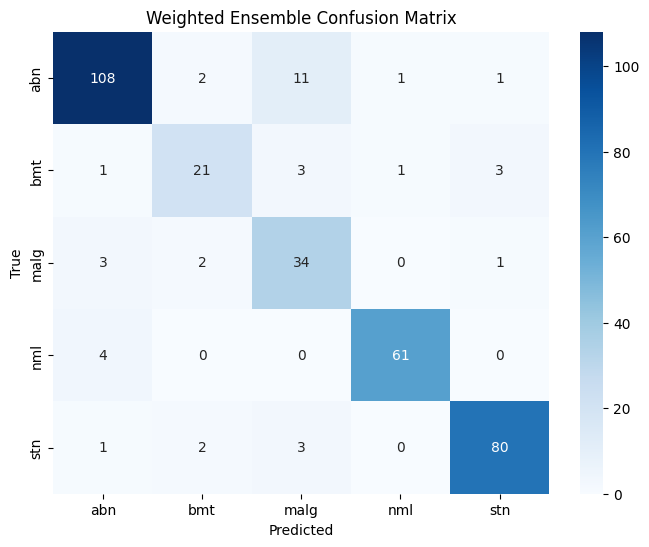

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# Selected models and weights
# --------------------------
selected_models = [
    ("EfficientNetB2", efficientnet_b2_model),
    ("EfficientNetB1", efficientnet_b1_model),
    ("EfficientNetB3", efficientnet_b3_model),
    ("EfficientNetB0", efficientnet_b0_model),
    ("EfficientNetB4", efficientnet_b4_model),
    ("MobileNetV2", mobilenet_v2_model)
]

# Test accuracies of selected models
selected_accs = np.array([0.8863, 0.8776, 0.8776, 0.8746, 0.8659, 0.8571])
weights = selected_accs / selected_accs.sum()
print("Weights for weighted ensemble:", weights)

# --------------------------
# Weighted Ensemble Prediction
# --------------------------
def weighted_ensemble_predict(models, weights, test_loader, device):
    all_preds = []
    y_true = []
    weighted_probs_list = []

    for inputs, labels in test_loader:
        if device.type == 'cuda':
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
        else:
            inputs = inputs.to(device)
            labels = labels.to(device)
        y_true.extend(labels.cpu().numpy())

        # Weighted probability sum
        weighted_probs = 0
        for (name, model), w in zip(models, weights):
            model.eval()
            with torch.no_grad():
                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=1).cpu().numpy()
                weighted_probs += w * probs

        weighted_probs_list.extend(weighted_probs)
        all_preds.extend(np.argmax(weighted_probs, axis=1))

    ensemble_accuracy = accuracy_score(y_true, all_preds)
    print(f"\nWeighted Ensemble Test Accuracy: {ensemble_accuracy*100:.2f}%")
    print(f"Classification Report:\n{classification_report(y_true, all_preds, target_names=class_names)}")

    return ensemble_accuracy, all_preds, np.array(weighted_probs_list), y_true

# Run weighted ensemble
ensemble_accuracy, ensemble_preds, ensemble_probs, y_true_ensemble = weighted_ensemble_predict(
    selected_models, weights, test_loader, device
)

# --------------------------
# Plot Confusion Matrix
# --------------------------
def plot_confusion_matrix(y_true, y_pred, class_names, model_name="Weighted Ensemble"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(y_true_ensemble, ensemble_preds, class_names, "Weighted Ensemble")

# --------------------------
# Plot ROC Curve
# --------------------------
def plot_roc_curve(y_true, y_pred_probs, class_names, model_name="Weighted Ensemble"):
    n_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10,8))
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0,1], [0,1], 'k--', lw=2, label='Random Guess')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")

    plt.grid(True)
    plt.show()


# Call the ROC plotting function for the weighted ensemble
plot_roc_curve(y_true_ensemble, ensemble_probs, class_names, "Weighted Ensemble")

extra


In [101]:
# --- KG export for ResNet18 (diagnostic + model-concept + hybrid) ---
# This cell is safe and runs only on existing objects produced by your ResNet18 run.
import os
import shutil
try:
    import networkx as nx
except Exception as e:
    print("Optional: install 'networkx' to enable KG export: pip install networkx", e)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from collections import Counter
from PIL import Image as PilImage

OUT_DIR = Path.cwd() / "kg_artifacts"
OUT_DIR.mkdir(exist_ok=True)


def extract_embeddings_for_model(model, dataloader, device, max_batches=6):
    model.eval()
    embs = []
    labels = []
    paths = []

    with torch.no_grad():
        for batch_idx, (inputs, lbs) in enumerate(dataloader):
            if batch_idx >= max_batches:
                break
            bs = inputs.size(0)
            inputs = inputs.to(device)
            try:
                if hasattr(model, 'features'):
                    out = model.features(inputs)
                    feat = torch.flatten(out, 1)
                elif hasattr(model, 'forward_features'):
                    out = model.forward_features(inputs)
                    if torch.is_tensor(out):
                        feat = torch.flatten(out, 1)
                    else:
                        feat = torch.as_tensor(out)
                else:
                    out = model(inputs)
                    feat = torch.flatten(out, 1)
            except Exception:
                out = model(inputs)
                feat = torch.flatten(out, 1)

            feat_np = feat.detach().cpu().numpy()
            embs.append(feat_np)
            labels.extend(lbs.cpu().numpy())

            # collect file paths from dataset samples (assumes ImageFolder)
            start = batch_idx * dataloader.batch_size
            for i in range(bs):
                idx = start + i
                if idx < len(dataloader.dataset.samples):
                    p, _ = dataloader.dataset.samples[idx]
                    paths.append(p)
                else:
                    paths.append(None)

    if len(embs) == 0:
        return np.zeros((0,)), np.array([]), []
    embs = np.vstack(embs)
    return embs, np.array(labels), paths


def build_and_save_model_concept_graph(name, model, dataloader, device, out_prefix, n_clusters=6, max_batches=6):
    """
    Builds a model-concept graph by extracting embeddings, optionally clustering them, and saving:
      - {out_prefix}.graphml
      - {out_prefix}.png (network visualization)
      - {out_prefix}_pca.png (PCA scatter colored by cluster)
      - {out_prefix}_samples/ (up to 3 thumbnails per cluster)

    n_clusters can be:
      - int: use KMeans with that many clusters
      - 'auto': use silhouette search to pick k (2..min(12, n_samples-1))
      - 'all': treat each sample as its own cluster (cluster id = sample index)
    """
    embs, labels, paths = extract_embeddings_for_model(model, dataloader, device, max_batches=max_batches)
    if embs.shape[0] == 0:
        print("No embeddings extracted; skipping model-concept graph.")
        return None

    # Standardize and reduce dimensionality for clustering/visualization
    sc = StandardScaler()
    e = sc.fit_transform(embs)
    n_comp = min(50, e.shape[1])
    pca = PCA(n_components=n_comp)
    e_p = pca.fit_transform(e)

    n_samples = e_p.shape[0]

    # Determine clusters robustly
    chosen_k = None
    if isinstance(n_clusters, str) and n_clusters == 'all':
        # each sample is its own cluster
        cl_labels = np.arange(n_samples)
        chosen_k = n_samples
        print(f"Using 'all' mode: creating {chosen_k} clusters (one per sample)")
    elif isinstance(n_clusters, str) and n_clusters == 'auto':
        # silhouette-based k selection
        from sklearn.metrics import silhouette_score
        best_k = None
        best_s = -1
        max_k = min(12, max(2, n_samples - 1))
        for k in range(2, max_k + 1):
            try:
                labels_k = KMeans(n_clusters=k, random_state=42).fit_predict(e_p)
                if len(np.unique(labels_k)) > 1:
                    s = silhouette_score(e_p, labels_k)
                    if s > best_s:
                        best_s = s
                        best_k = k
            except Exception:
                continue
        if best_k is None:
            best_k = min(6, max(1, n_samples))
        chosen_k = best_k
        print(f"Auto-selected k={chosen_k} (silhouette={best_s if best_s is not None else 'NA'})")
        km = KMeans(n_clusters=chosen_k, random_state=42).fit(e_p)
        cl_labels = km.labels_
    else:
        # explicit integer (or convertible string)
        try:
            k = int(n_clusters)
        except Exception:
            k = 6
        k = max(1, min(k, n_samples))
        chosen_k = k
        if k == 1:
            cl_labels = np.zeros(n_samples, dtype=int)
        else:
            km = KMeans(n_clusters=k, random_state=42).fit(e_p)
            cl_labels = km.labels_
        print(f"Using k={chosen_k} clusters")

    # Build graph
    G = nx.Graph()
    model_node = f"model:{name}"
    G.add_node(model_node, type='model', label=name)

    sample_dir = OUT_DIR / f"{out_prefix}_samples"
    sample_dir.mkdir(parents=True, exist_ok=True)

    for c in np.unique(cl_labels):
        node_id = f"{name}:cluster:{c}"
        idxs = np.where(cl_labels == c)[0]
        support = int(len(idxs))
        counts = Counter(labels[idxs]) if len(idxs) > 0 else Counter()
        if len(counts) > 0:
            majority_label, majority_count = counts.most_common(1)[0]
        else:
            majority_label, majority_count = -1, 0

        G.add_node(node_id, type='cluster', model=name, cluster=int(c), support=support,
                   majority_label=int(majority_label) if majority_label is not None else -1,
                   majority_support=int(majority_count))
        G.add_edge(model_node, node_id)

        # Connect to class node if possible
        if isinstance(majority_label, (int, np.integer)) and 0 <= majority_label < len(class_names):
            class_node = f"class:{majority_label}"
            if not G.has_node(class_node):
                G.add_node(class_node, type='class', label=class_names[majority_label])
            G.add_edge(node_id, class_node, weight=float(majority_count) / max(1, support))

        # save up to 3 sample thumbnails per cluster
        for ii in idxs[:3]:
            img_node = f"{name}:img:{ii}"
            img_path = paths[ii] if ii < len(paths) else None
            true_lab = int(labels[ii]) if ii < len(labels) else -1
            G.add_node(img_node, type='image', sample_idx=int(ii), true_label=true_lab, path=str(img_path) if img_path else '')
            G.add_edge(node_id, img_node)

            if img_path and Path(img_path).exists():
                try:
                    im = PilImage.open(img_path).convert('RGB')
                    im.thumbnail((224, 224))
                    thumb_path = sample_dir / f"{name}_cluster{c}_img{ii}.png"
                    im.save(thumb_path)
                except Exception as e:
                    print('Could not save thumbnail', img_path, e)

    # save graphml
    graph_path = OUT_DIR / f"{out_prefix}.graphml"
    try:
        nx.write_graphml(G, graph_path)
    except Exception as e:
        print('Failed to write graphml:', e)

    # draw and save network visualization (may be cluttered if many clusters)
    try:
        plt.figure(figsize=(10, 8))
        pos = nx.spring_layout(G, k=0.3)
        types = nx.get_node_attributes(G, 'type')
        color_map = []
        size_map = []
        for n in G.nodes():
            t = types.get(n, 'other')
            if t == 'class':
                color_map.append('green'); size_map.append(400)
            elif t == 'model':
                color_map.append('red'); size_map.append(300)
            elif t == 'cluster':
                color_map.append('orange'); size_map.append(150)
            elif t == 'image':
                color_map.append('blue'); size_map.append(60)
            else:
                color_map.append('gray'); size_map.append(80)

        nx.draw(G, pos, node_color=color_map, node_size=size_map, with_labels=True, font_size=8)
        img_out = OUT_DIR / f"{out_prefix}.png"
        plt.tight_layout()
        plt.savefig(img_out)
        plt.close()
    except Exception as e:
        print('Network visualization failed:', e)

    # PCA scatter: color by cluster
    try:
        pca_out = OUT_DIR / f"{out_prefix}_pca.png"
        plt.figure(figsize=(8, 6))
        unique_clusters = np.unique(cl_labels)
        cmap = plt.get_cmap('tab20')
        for i, c in enumerate(unique_clusters):
            idxs = np.where(cl_labels == c)[0]
            color = cmap(i % 20)
            plt.scatter(e_p[idxs, 0], e_p[idxs, 1], s=30, color=color, label=f'cluster {c}')
        if len(unique_clusters) <= 20:
            plt.legend(loc='best', fontsize='small')
        plt.title(f'PCA scatter ({out_prefix})')
        plt.xlabel('PC1'); plt.ylabel('PC2')
        plt.tight_layout(); plt.savefig(pca_out); plt.close()
        print('Saved PCA scatter:', pca_out)
    except Exception as e:
        print('PCA scatter failed:', e)

    img_out = OUT_DIR / f"{out_prefix}.png"
    pca_out = OUT_DIR / f"{out_prefix}_pca.png"
    print('Saved model-concept graph:', graph_path)
    print('Artifacts summary:', 'network_png=' + (str(img_out) if img_out.exists() else 'missing'), 'pca=' + (str(pca_out) if pca_out.exists() else 'missing'), 'samples_dir=' + (str(sample_dir) if sample_dir.exists() else 'missing'))
    return G


def build_and_save_diagnostic_graph(name, train_loss, train_acc, val_loss, val_acc, out_prefix):
    """Builds a diagnostic graph (epoch nodes + simple plots) and saves .graphml and .png"""
    G = nx.DiGraph()
    prev = None
    for epoch, (l, a) in enumerate(zip(train_loss, train_acc)):
        n = f"{name}:epoch:{epoch}"
        G.add_node(n, type='epoch', model=name, epoch=int(epoch), train_loss=float(l), train_acc=float(a))
        if prev is not None:
            G.add_edge(prev, n)
        prev = n

    G.add_node(f"{name}:summary", type='summary', best_val=max(val_acc) if len(val_acc) else None)
    if prev is not None:
        G.add_edge(prev, f"{name}:summary")

    graph_path = OUT_DIR / f"{out_prefix}.graphml"
    try:
        nx.write_graphml(G, graph_path)
    except Exception as e:
        print('Failed to write diagnostic graphml:', e)

    # draw simple plots for loss and accuracy
    try:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        epochs = range(1, len(train_loss) + 1)
        axes[0].plot(epochs, train_loss, 'o-', label='Training Loss')
        axes[0].plot(epochs, val_loss, 'o-', label='Validation Loss')
        axes[0].set_title(f'{name} Loss'); axes[0].legend(); axes[0].grid(True)

        axes[1].plot(epochs, train_acc, 'o-', label='Training Acc')
        axes[1].plot(epochs, val_acc, 'o-', label='Validation Acc')
        axes[1].set_title(f'{name} Accuracy'); axes[1].legend(); axes[1].grid(True)

        plt.tight_layout()
        img_out = OUT_DIR / f"{out_prefix}.png"
        plt.savefig(img_out)
        plt.close()
        print('Saved diagnostic graph:', graph_path, img_out)
    except Exception as e:
        print('Diagnostic plotting failed:', e)


    return G

In [ ]:
# Quick utility: verify that sample image files can be opened by PIL (useful to detect corrupt files)
def check_image_paths(paths, max_checks=100):
    """Attempt to open and verify up to `max_checks` image paths with PIL; returns list of (path, error_str) for failures."""
    bad = []
    for p in (paths or [])[:max_checks]:
        if not p:
            bad.append((p, 'missing'))
            continue
        try:
            PilImage.open(p).verify()
        except Exception as e:
            bad.append((p, str(e)))
    if not bad:
        print('All tested images opened OK')
    else:
        print(f"Found {len(bad)} bad images (first 10):", bad[:10])
    return bad

# Example usage (uncomment to run):
# problematic = [r'd:\Gallblader-Cancer-Detection-DL\data\test\abn\1010_im00443_abn_1.png', ...]
# check_image_paths(problematic)

In [95]:
# --- Per-epoch snapshot demo (ResNet18) ---
# Re-train ResNet18 for a short run with per-epoch KG snapshots.
# Adjust the following config as desired.
# Examples below show using fixed k, auto-selected k, or 'all' (one cluster per sample).

# Example 1: fixed k=6 (default)
SNAPSHOT_CONFIG = {
    'every': 1,        # snapshot every epoch
    'max_batches': 3,  # use 3 batches per snapshot
    'n_clusters': 6    # fixed number of clusters per epoch
}

# Example 2: auto-select k using silhouette search
SNAPSHOT_CONFIG_AUTO = {
    'every': 1,
    'max_batches': 3,
    'n_clusters': 'auto'
}

# Example 3: 'all' mode - one cluster per extracted sample (can be very large)
SNAPSHOT_CONFIG_ALL = {
    'every': 1,
    'max_batches': 3,
    'n_clusters': 'all'
}

# Choose which config to use for the demo (change as desired)
config_to_use = SNAPSHOT_CONFIG_ALL  # or SNAPSHOT_CONFIG, SNAPSHOT_CONFIG_AUTO
print('\nStarting demo training (5 epochs) with per-epoch snapshots...')
print('Using snapshot config:', config_to_use)

# Run a short demo training to generate per-epoch artifacts
demo_model = get_model('resnet18', num_classes=len(class_names))
trained_demo_model, train_loss_demo, val_loss_demo, train_acc_demo, val_acc_demo = train_model(
    demo_model, 'ResNet18', epochs=5, patience=3, snapshot_config=config_to_use
)

print('\nDemo finished. Check the kg_artifacts/ folder for per-epoch artifacts (kg_resnet18_epochXX*).')

# Quick viewer: list and display recent per-epoch KG artifacts
from IPython.display import display, HTML
import IPython.display as ipd
import base64, glob

print('\nQuick KG artifact check (latest epoch):')
ART_DIR = Path.cwd() / 'kg_artifacts'
if not ART_DIR.exists():
    print('No kg_artifacts/ directory found.')
else:
    # list matching files
    pngs = sorted(ART_DIR.glob('kg_resnet18_epoch*.png'))
    pcas = sorted(ART_DIR.glob('kg_resnet18_epoch*_pca.png'))
    graphs = sorted(ART_DIR.glob('kg_resnet18_epoch*.graphml'))
    samples_dirs = sorted(ART_DIR.glob('kg_resnet18_epoch*_samples'))

    print('Found', len(pngs), 'epoch PNG(s),', len(pcas), 'PCA image(s),', len(graphs), 'graphml(s),', len(samples_dirs), 'sample dir(s)')

    def _display_file(fp, title=None):
        if fp.exists():
            print('\n' + (title or fp.name))
            display(ipd.Image(filename=str(fp)))
        else:
            print('Missing:', fp)

    if pngs:
        _display_file(pngs[-1], title='Latest epoch network PNG')
    if pcas:
        _display_file(pcas[-1], title='Latest epoch PCA scatter')

    # show up to 64 thumbnails from latest samples dir
    if samples_dirs:
        d = samples_dirs[-1]
        thumbs = sorted(d.glob('*.png'))
        if thumbs:
            print('\nShowing up to 64 thumbnails from sample dir:', d.name)
            html = ['<div style="display:flex;flex-wrap:wrap">']
            for t in thumbs[:64]:
                b64 = base64.b64encode(t.read_bytes()).decode()
                html.append(f"<div style='margin:3px'><img src='data:image/png;base64,{b64}' style='width:120px;height:120px;object-fit:cover;'/></div>")
            html.append('</div>')
            display(HTML(''.join(html)))
        else:
            print('No thumbnails found in', d)

    # print names of latest graphml
    if graphs:
        print('\nMost recent graphml:', graphs[-1])


Starting demo training (5 epochs) with per-epoch snapshots...
Using snapshot config: {'every': 1, 'max_batches': 3, 'n_clusters': 'all'}

--- Training ResNet18 ---
Epoch 0/4
----------
training Loss: 0.9056 Acc: 0.6417
validation Loss: 0.6889 Acc: 0.7081
Snapshotting embeddings for epoch 0 -> kg_resnet18_epoch00 (n_clusters=all)
Using 'all' mode: creating 96 clusters (one per sample)
Could not save thumbnail d:\Gallblader-Cancer-Detection-DL\data\test\abn\1010_im00443_abn_1.png type object 'Image' has no attribute 'open'
Could not save thumbnail d:\Gallblader-Cancer-Detection-DL\data\test\abn\1014_im00331_abn_1.png type object 'Image' has no attribute 'open'
Could not save thumbnail d:\Gallblader-Cancer-Detection-DL\data\test\abn\1027_im00292_abn_2.png type object 'Image' has no attribute 'open'
Could not save thumbnail d:\Gallblader-Cancer-Detection-DL\data\test\abn\1039_im00865_abn_1.png type object 'Image' has no attribute 'open'
Could not save thumbnail d:\Gallblader-Cancer-Detect

C:\Users\offic\AppData\Local\Temp\ipykernel_17672\3604678802.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved PCA scatter: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet18_epoch00_pca.png
Saved model-concept graph: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet18_epoch00.graphml
Epoch 1/4
----------
training Loss: 0.6852 Acc: 0.7265
validation Loss: 1.0532 Acc: 0.5925
Snapshotting embeddings for epoch 1 -> kg_resnet18_epoch01 (n_clusters=all)
Using 'all' mode: creating 96 clusters (one per sample)
Could not save thumbnail d:\Gallblader-Cancer-Detection-DL\data\test\abn\1010_im00443_abn_1.png type object 'Image' has no attribute 'open'
Could not save thumbnail d:\Gallblader-Cancer-Detection-DL\data\test\abn\1014_im00331_abn_1.png type object 'Image' has no attribute 'open'
Could not save thumbnail d:\Gallblader-Cancer-Detection-DL\data\test\abn\1027_im00292_abn_2.png type object 'Image' has no attribute 'open'
Could not save thumbnail d:\Gallblader-Cancer-Detection-DL\data\test\abn\1039_im00865_abn_1.png type object 'Image' has no attribute 'open'
Could not save thumbn

C:\Users\offic\AppData\Local\Temp\ipykernel_17672\3604678802.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved PCA scatter: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet18_epoch01_pca.png
Saved model-concept graph: d:\Gallblader-Cancer-Detection-DL\kg_artifacts\kg_resnet18_epoch01.graphml
Epoch 2/4
----------


KeyboardInterrupt: 


--- kg_resnet50_v1_from_training_8105


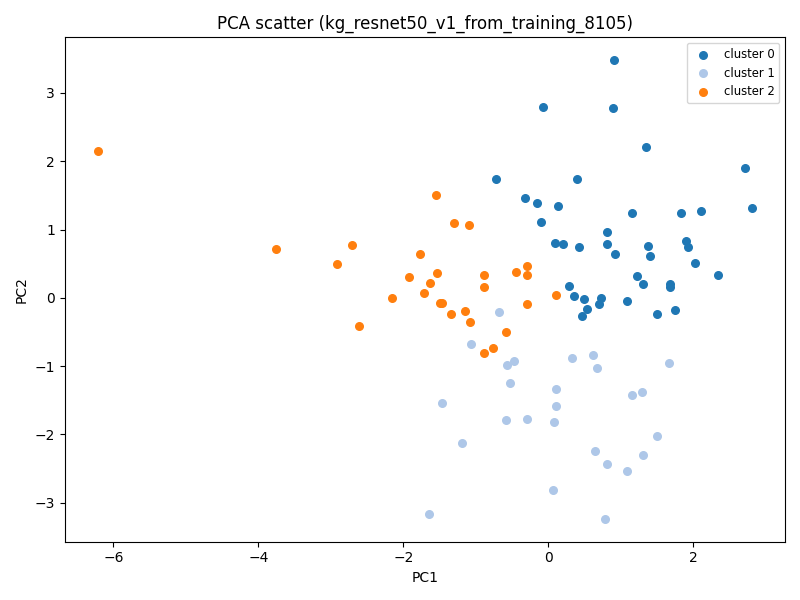

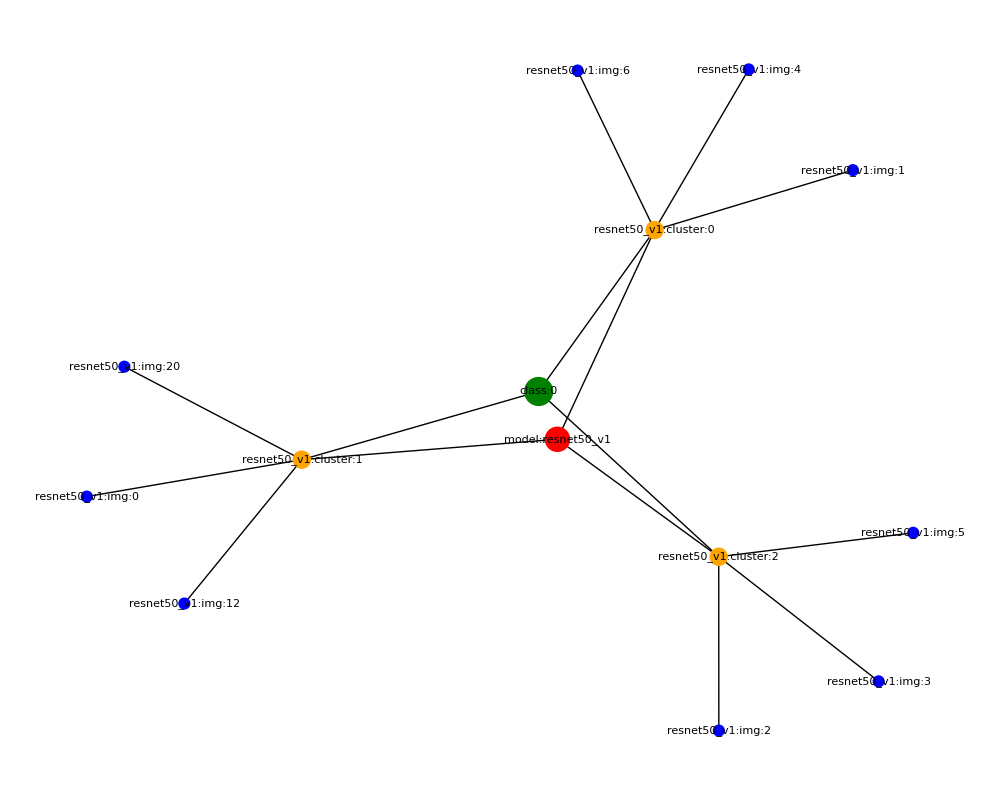


--- kg_resnet50_v2_from_training_8106


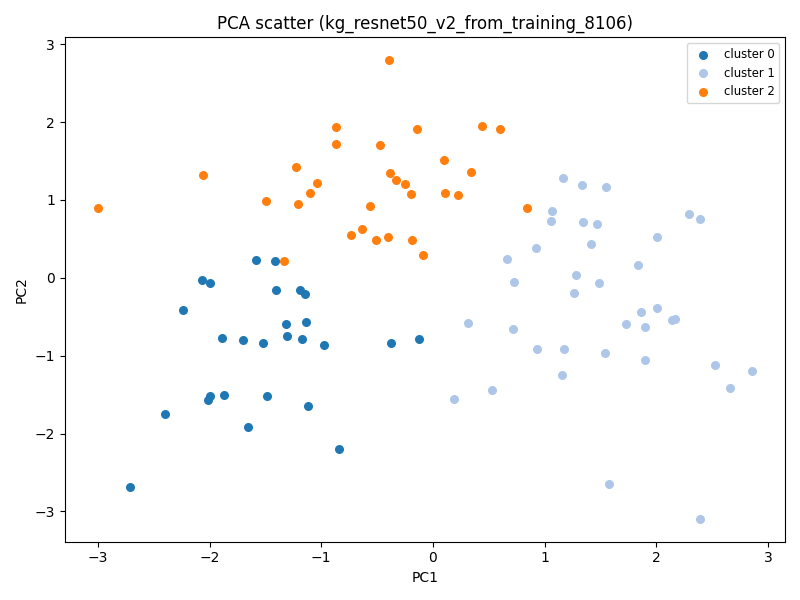

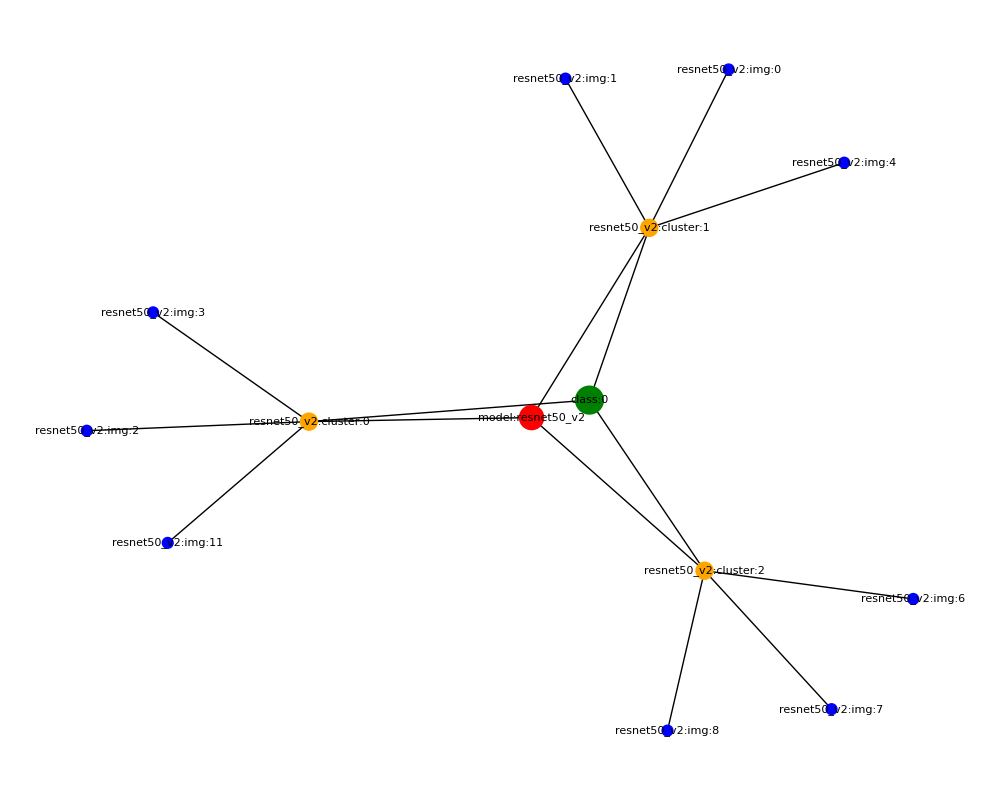

In [117]:
# Quick display: show PCA scatter and network PNG for each KG prefix
from IPython.display import display, Image as IPyImage

for pref in prefixes:
    print('\n---', pref)
    try:
        p_pca = OUT_DIR / f"{pref}_pca.png"
        p_png = OUT_DIR / f"{pref}.png"
        if p_pca.exists():
            display(IPyImage(filename=str(p_pca)))
        else:
            print('PCA png missing:', p_pca)
        if p_png.exists():
            display(IPyImage(filename=str(p_png)))
        else:
            print('Network png missing:', p_png)
    except Exception as e:
        print('Error displaying for', pref, repr(e))

Found 44 KG prefixes; displaying PCA and network PNG for each...

--- kg_densenet121_from_training_8098


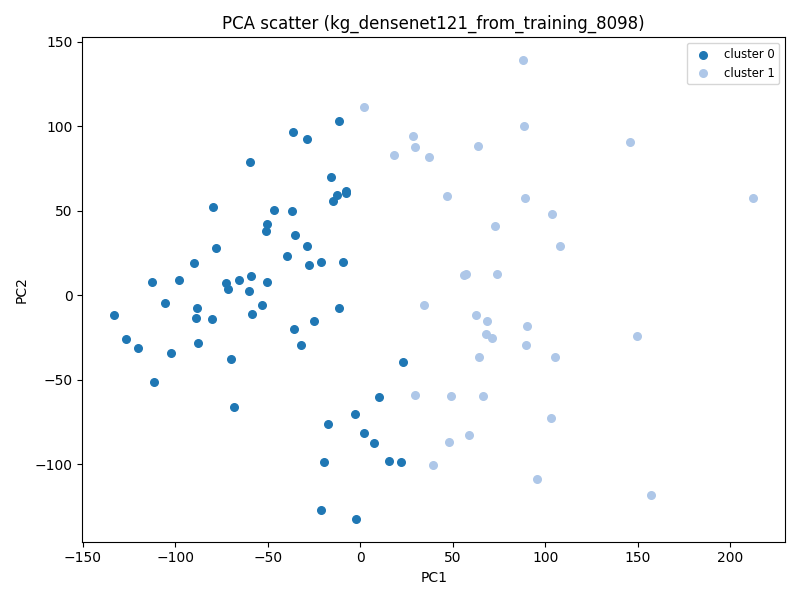

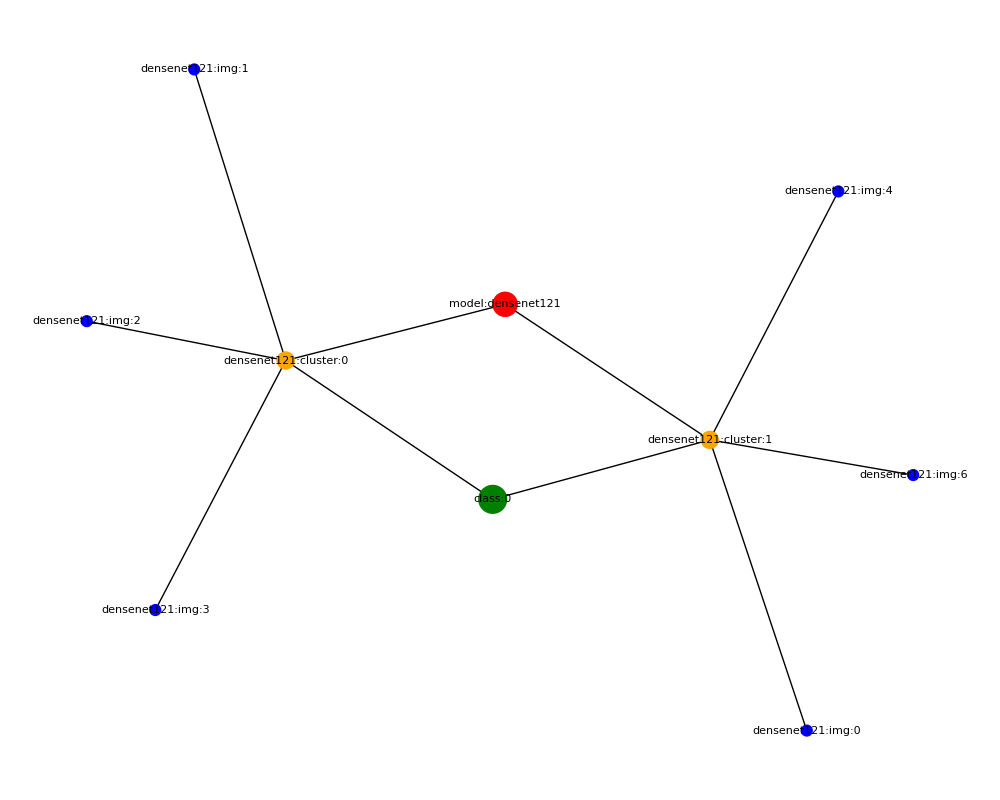


--- kg_densenet121_from_training_8185


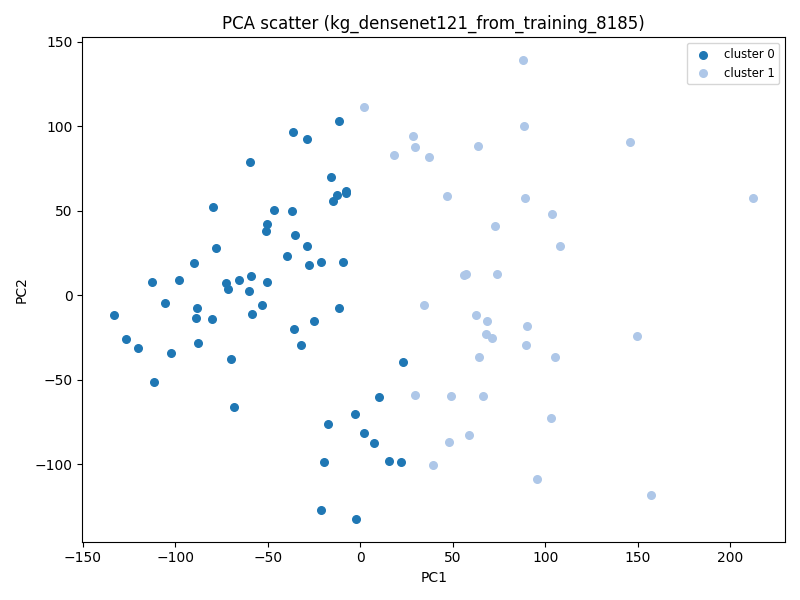

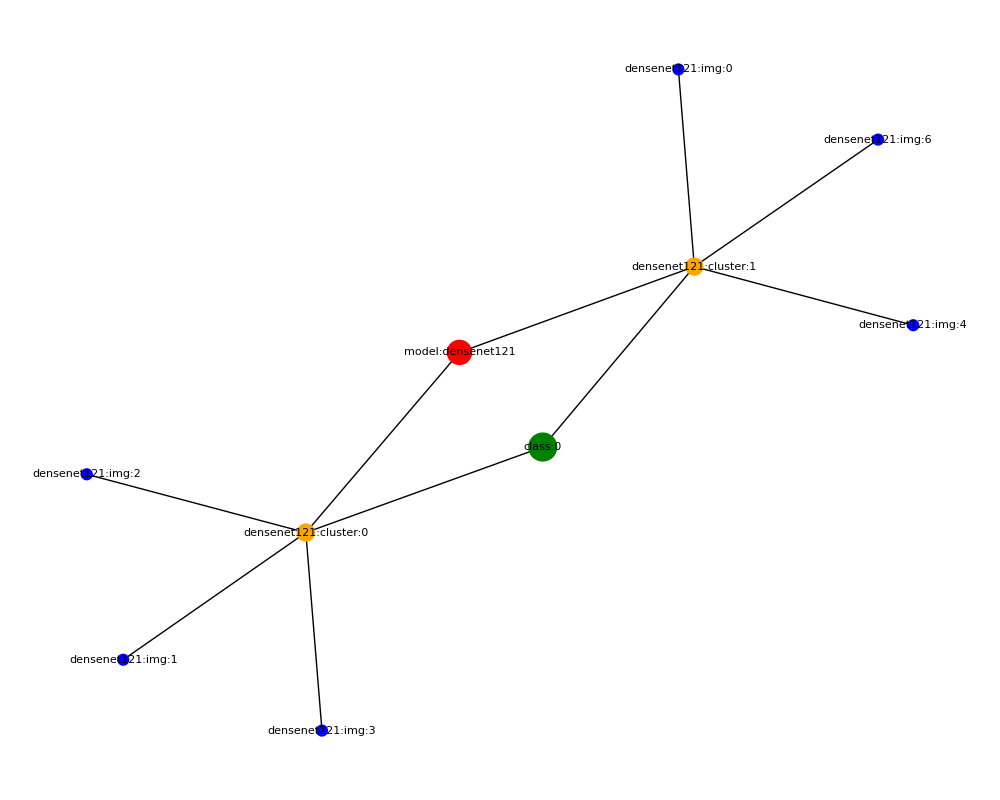


--- kg_densenet121_from_training_8265


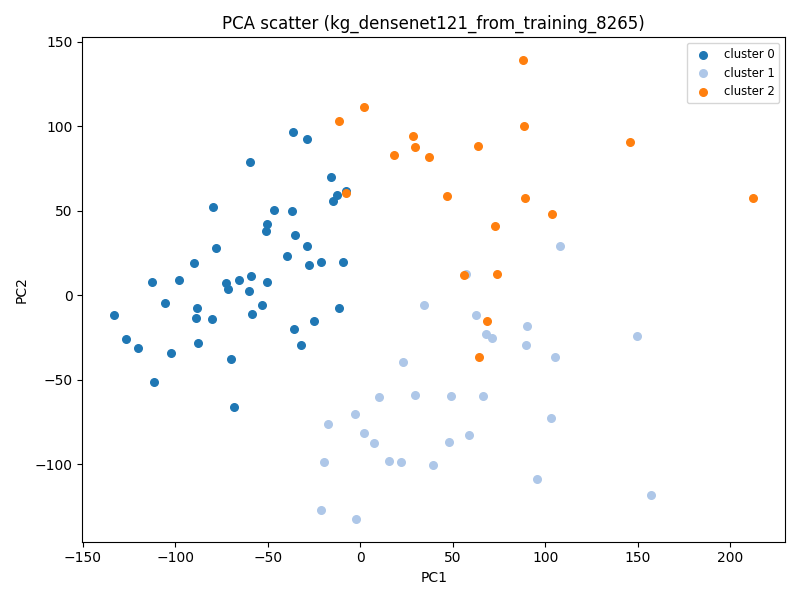

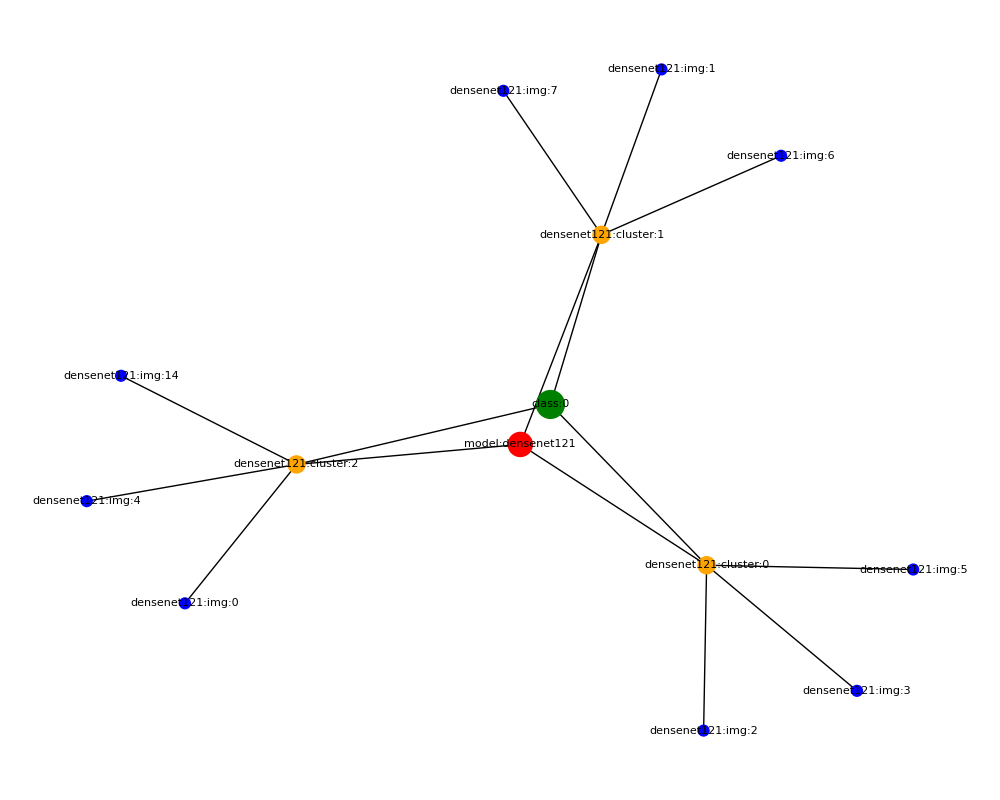


--- kg_densenet201_from_training_8099


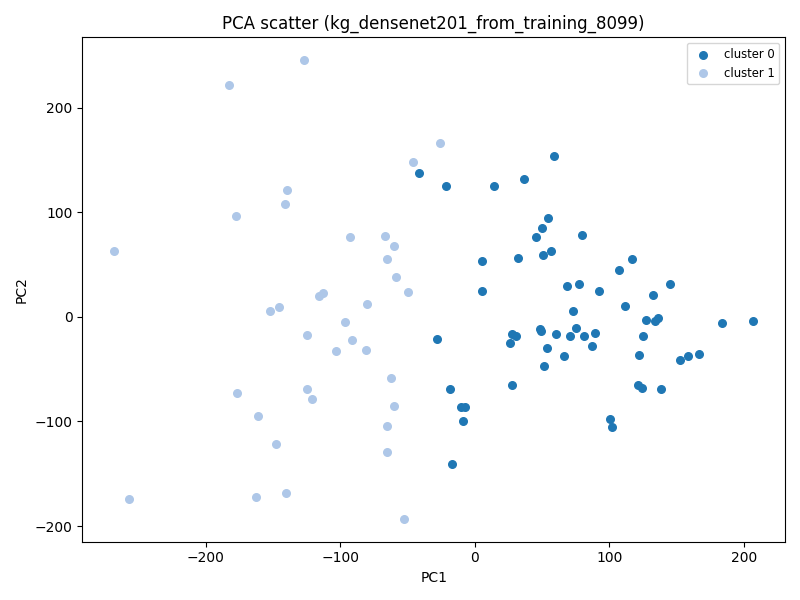

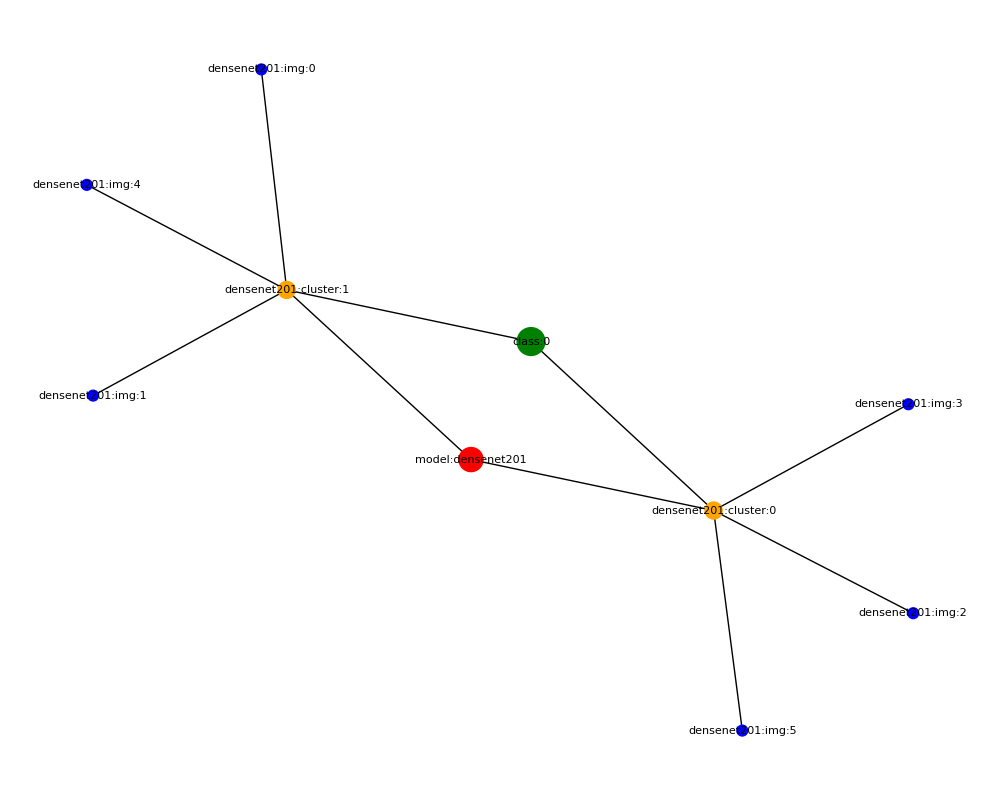


--- kg_densenet201_from_training_8187


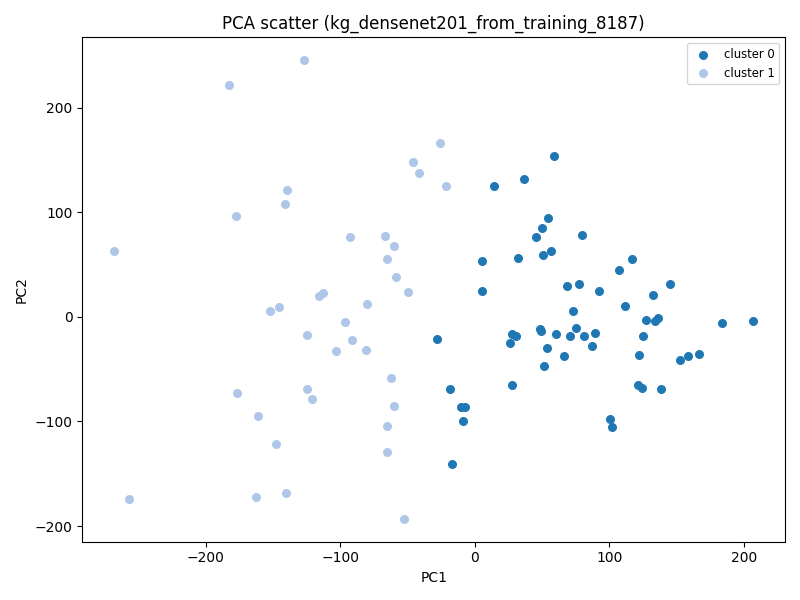

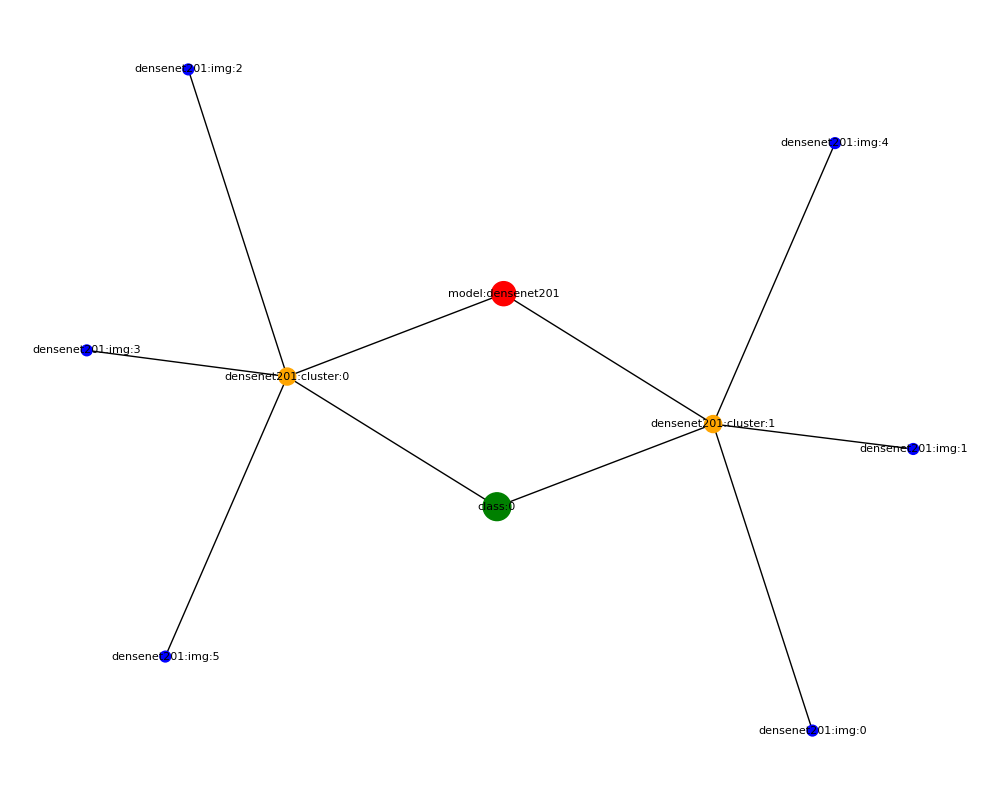


--- kg_densenet201_from_training_8267


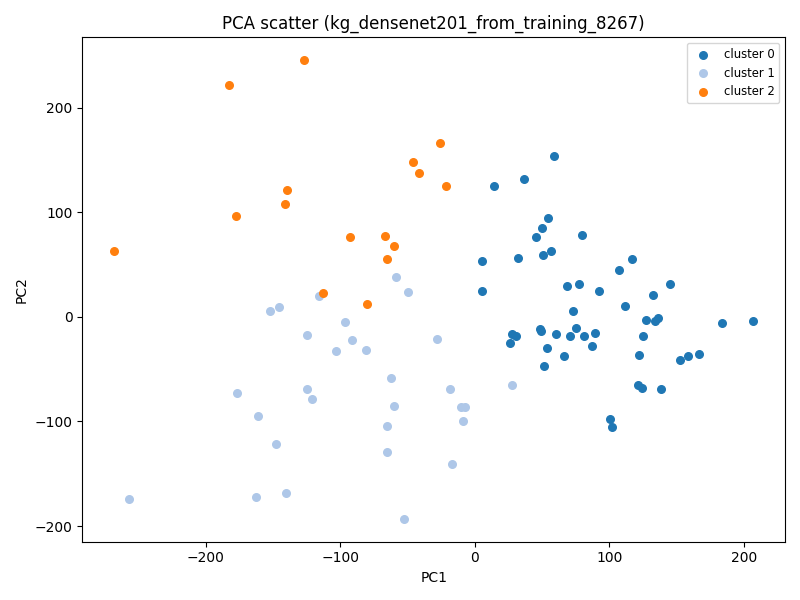

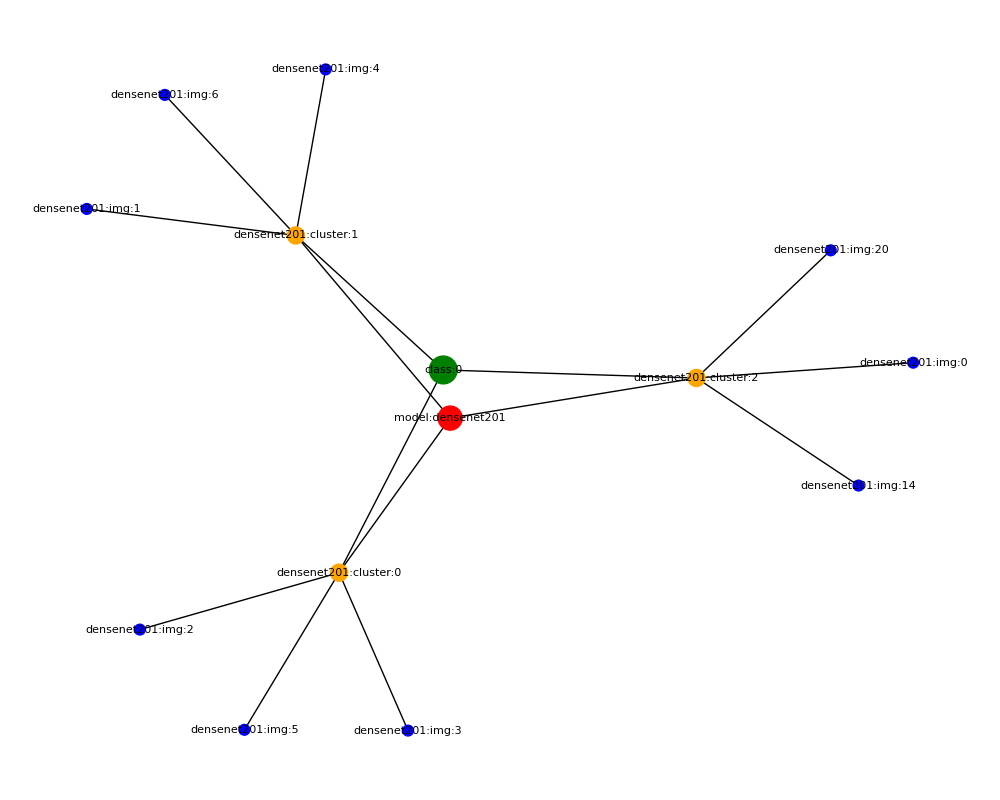


--- kg_efficientnet_b0_from_training_8091


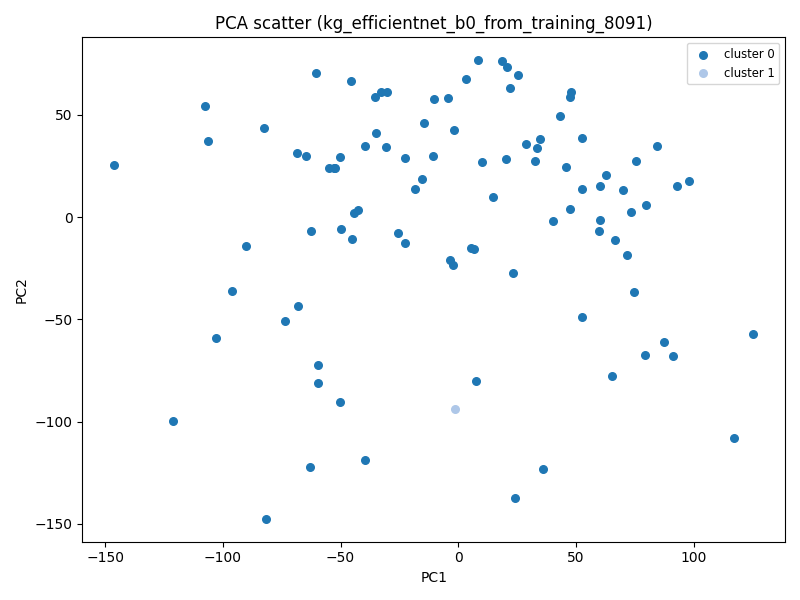

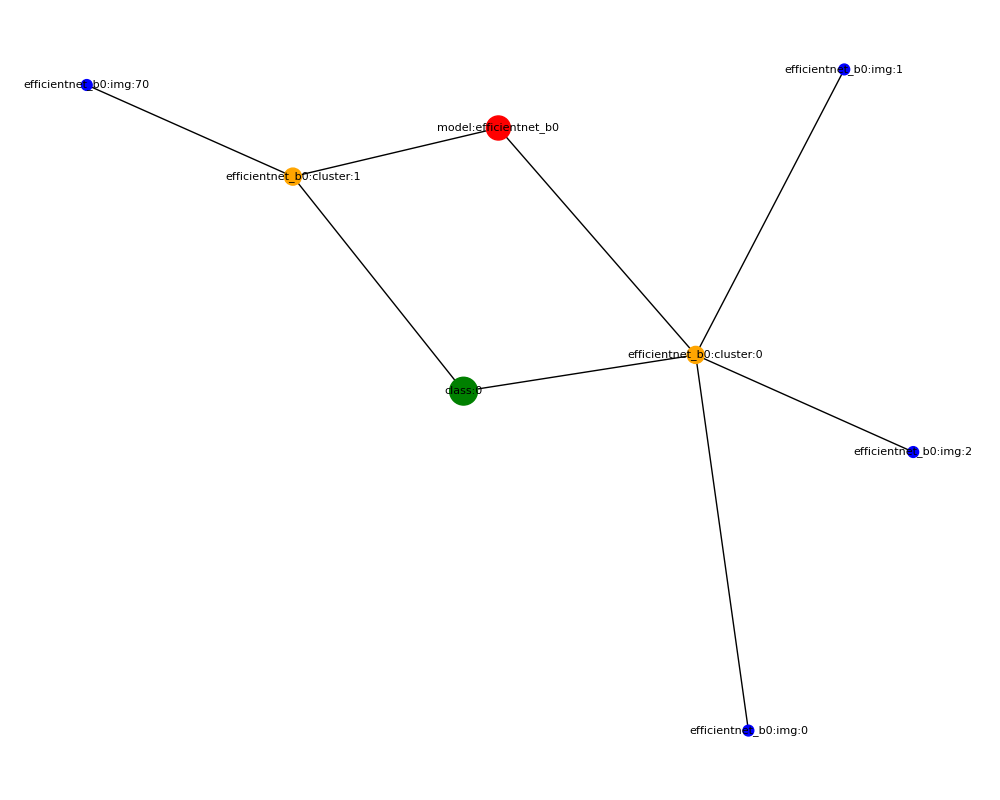


--- kg_efficientnet_b0_from_training_8178


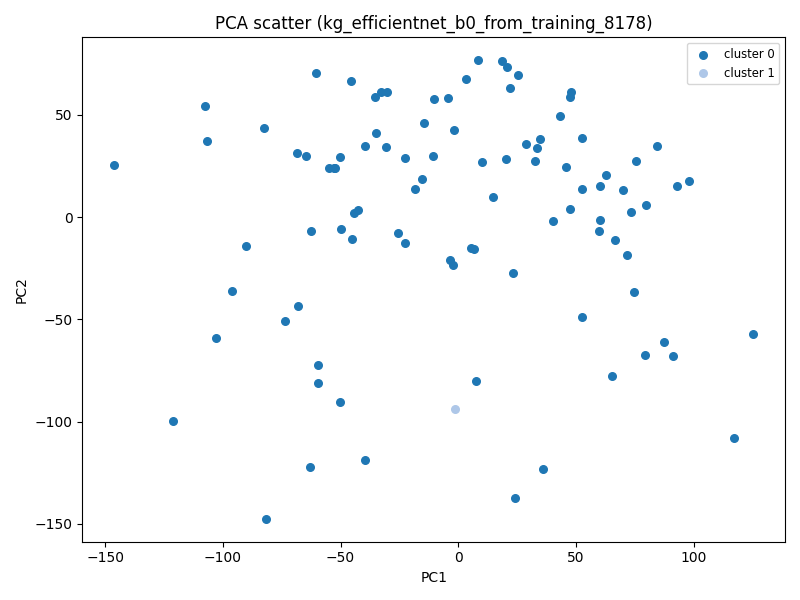

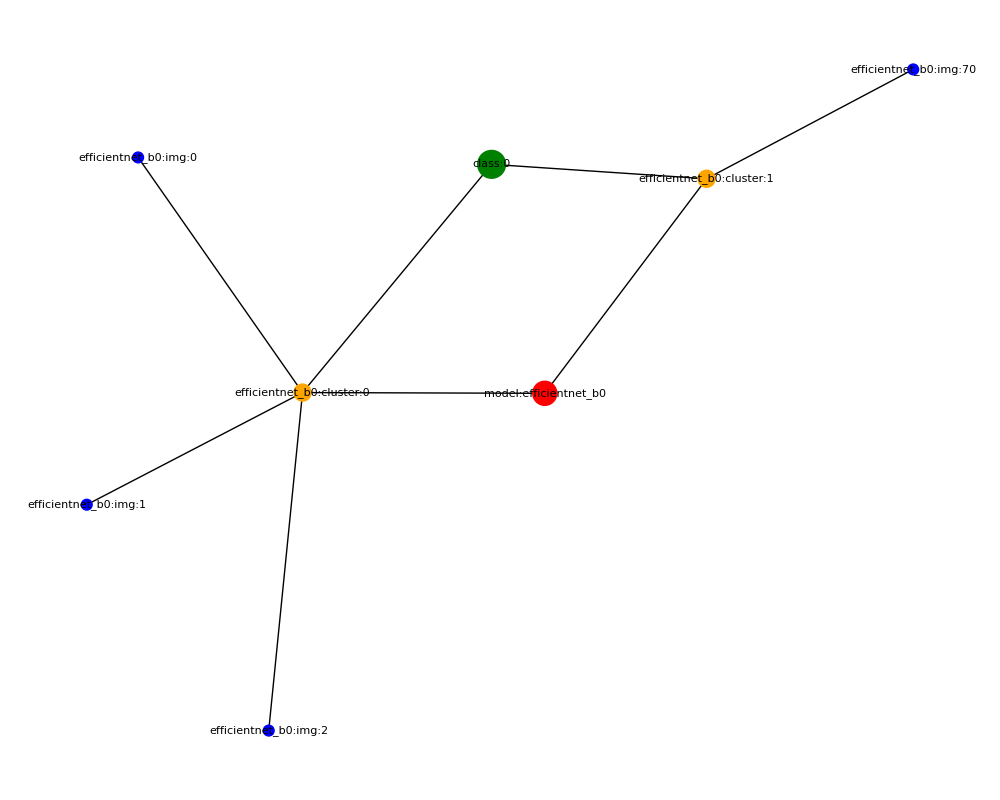


--- kg_efficientnet_b0_from_training_8258


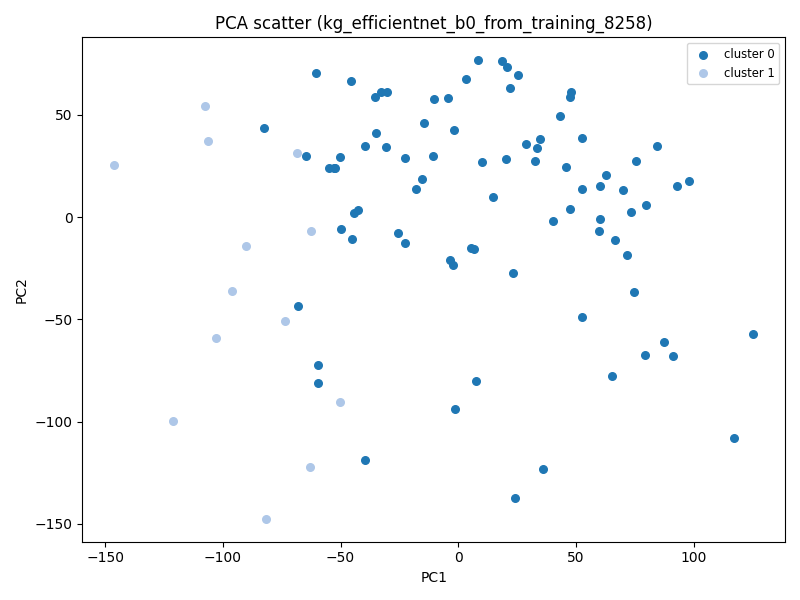

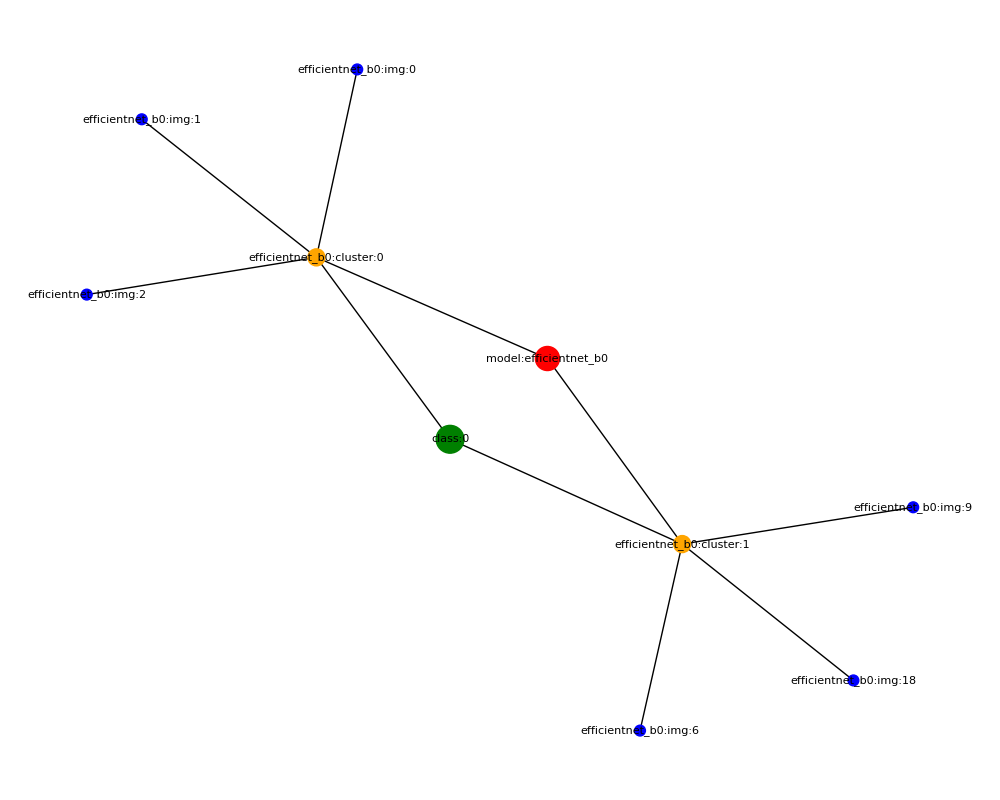


--- kg_efficientnet_b1_from_training_8092


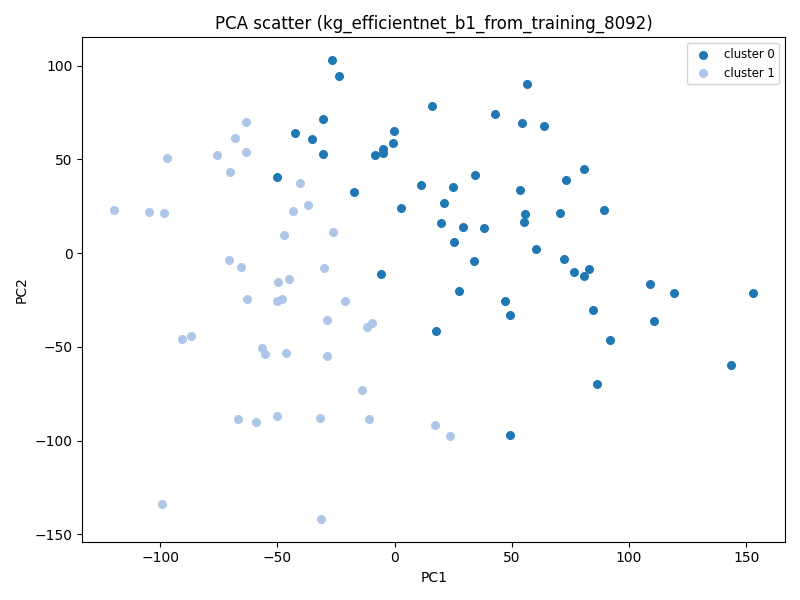

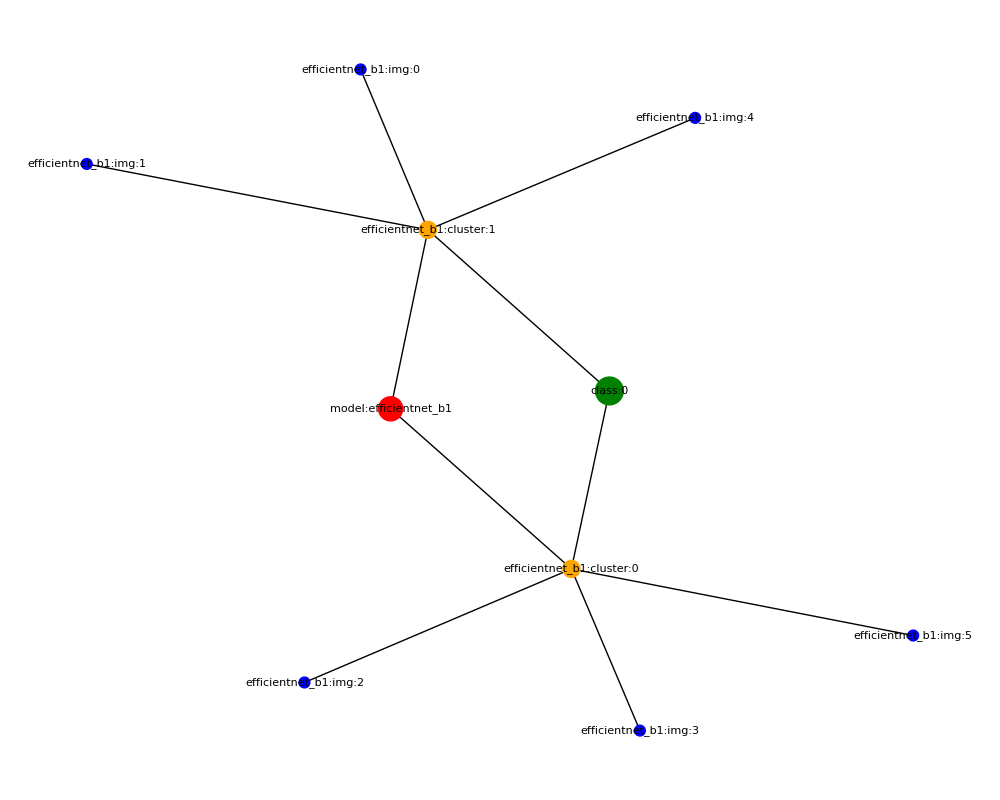


--- kg_efficientnet_b1_from_training_8179


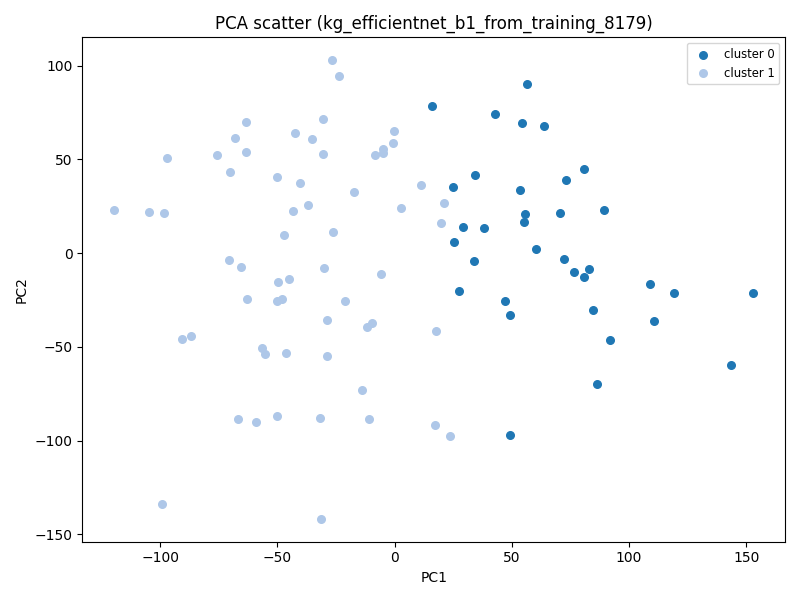

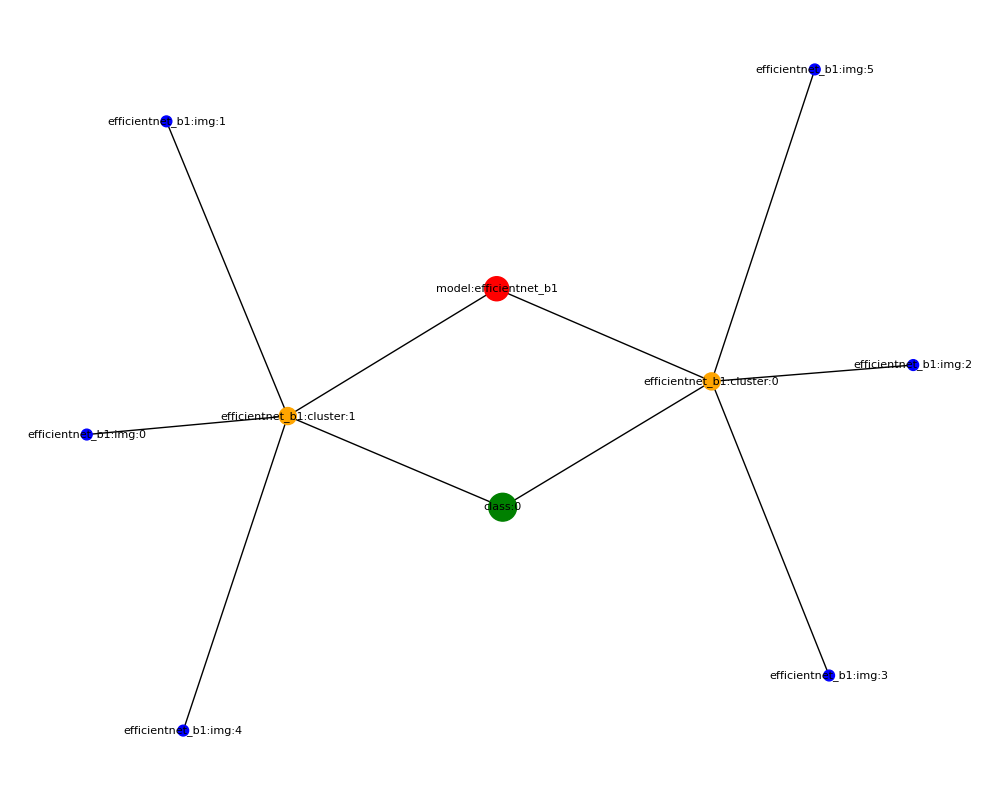


--- kg_efficientnet_b1_from_training_8259


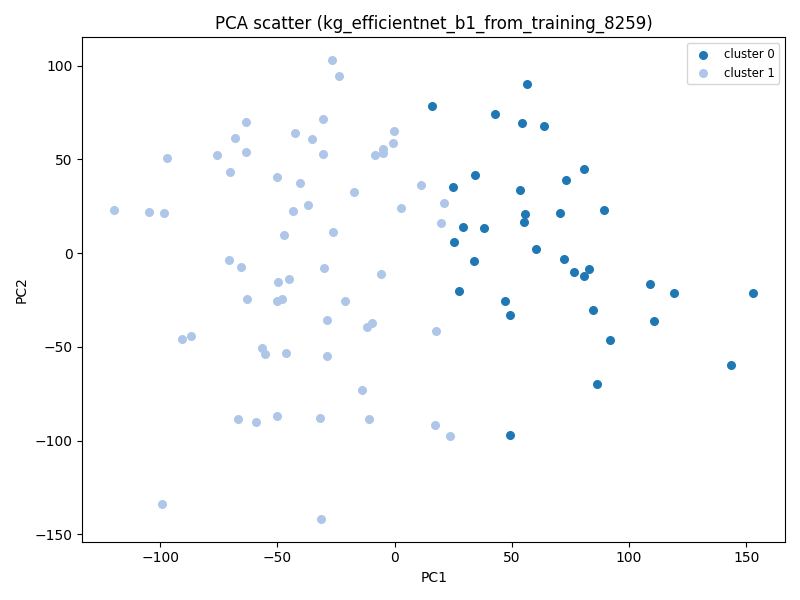

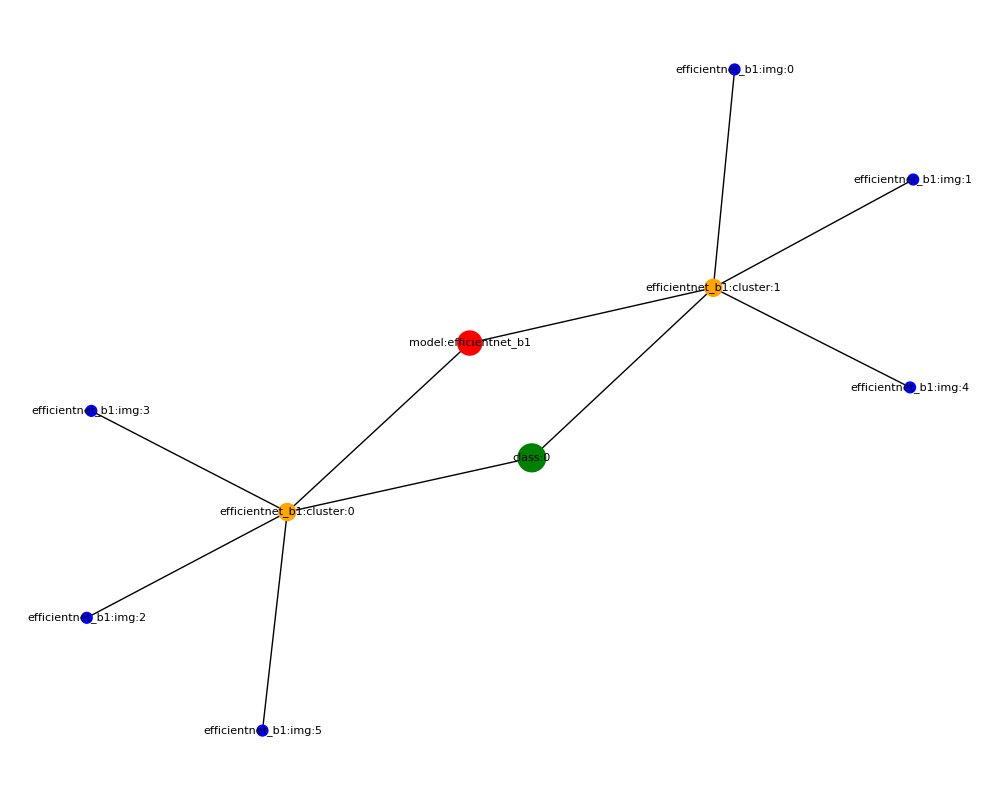


--- kg_efficientnet_b2_from_training_8093


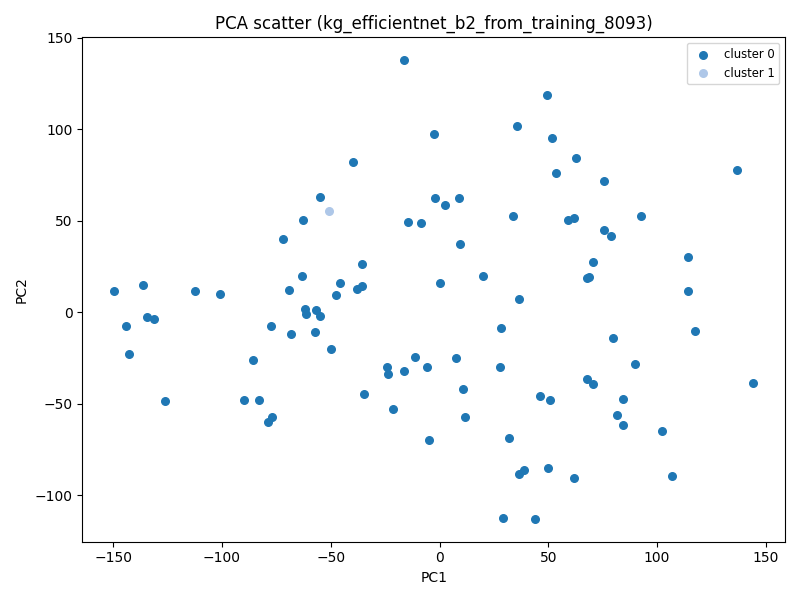

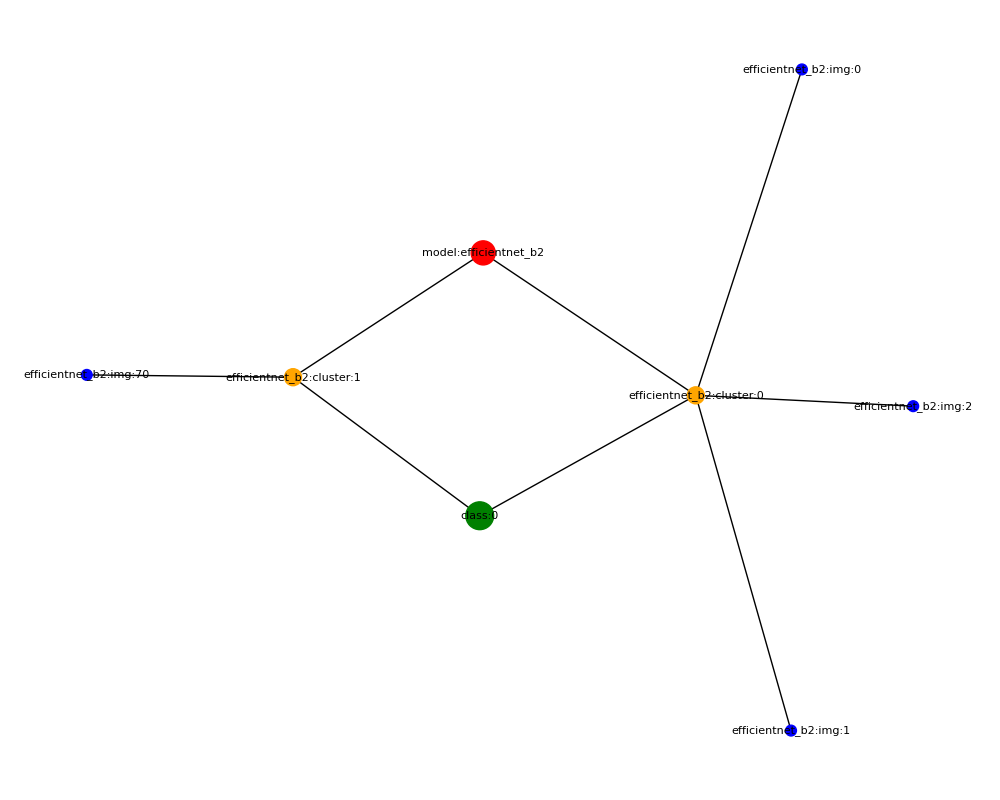


--- kg_efficientnet_b2_from_training_8181


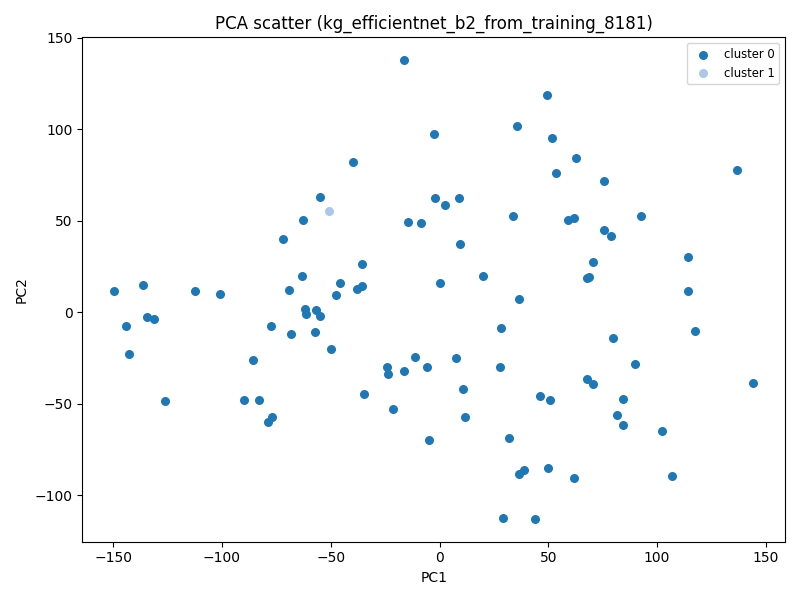

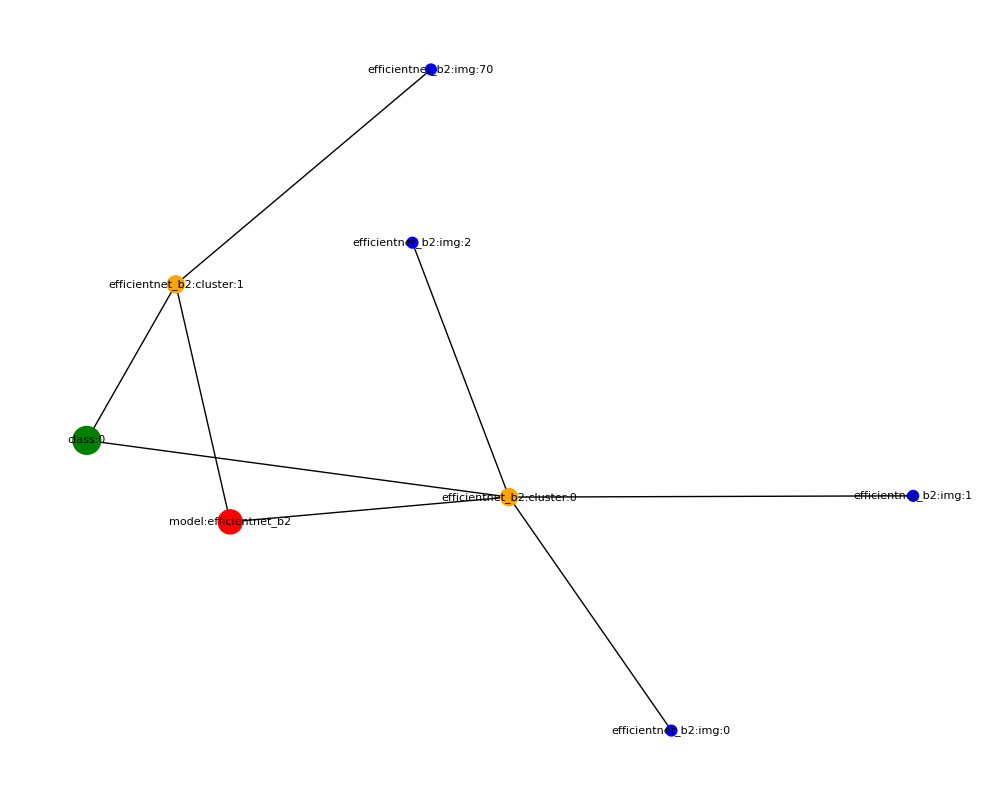


--- kg_efficientnet_b2_from_training_8261


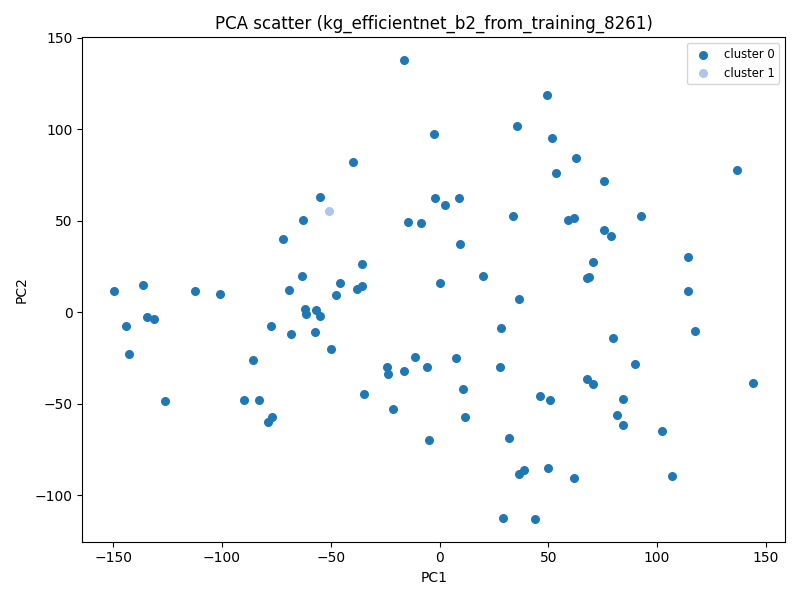

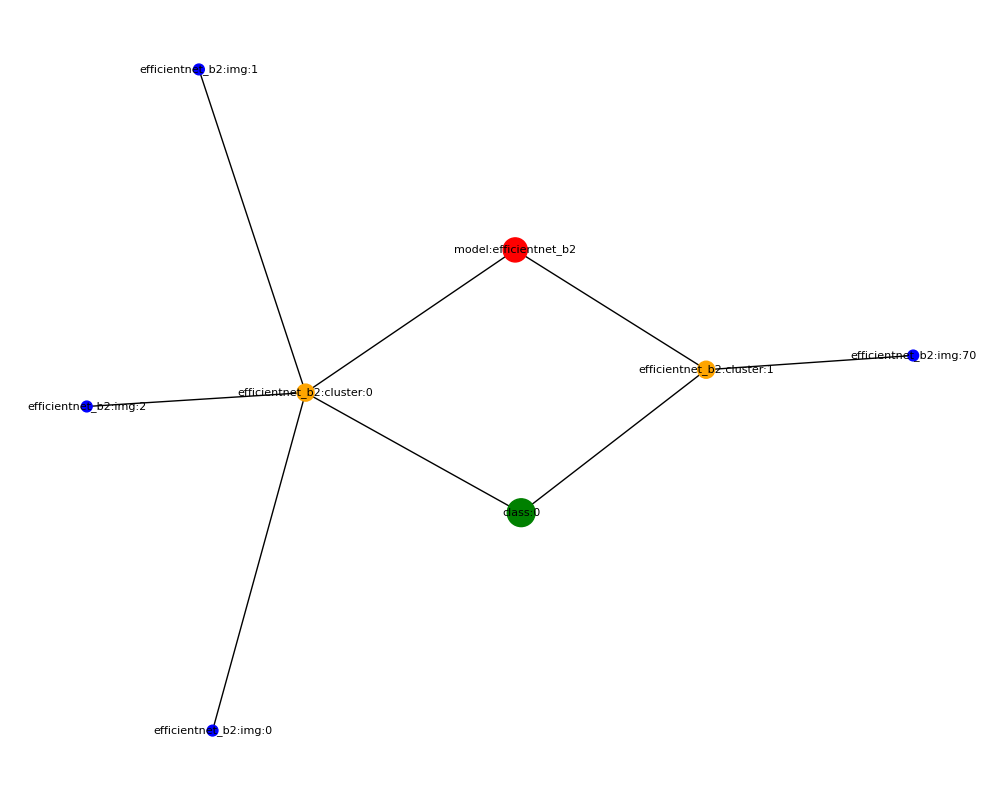


--- kg_efficientnet_b3_from_training_8094


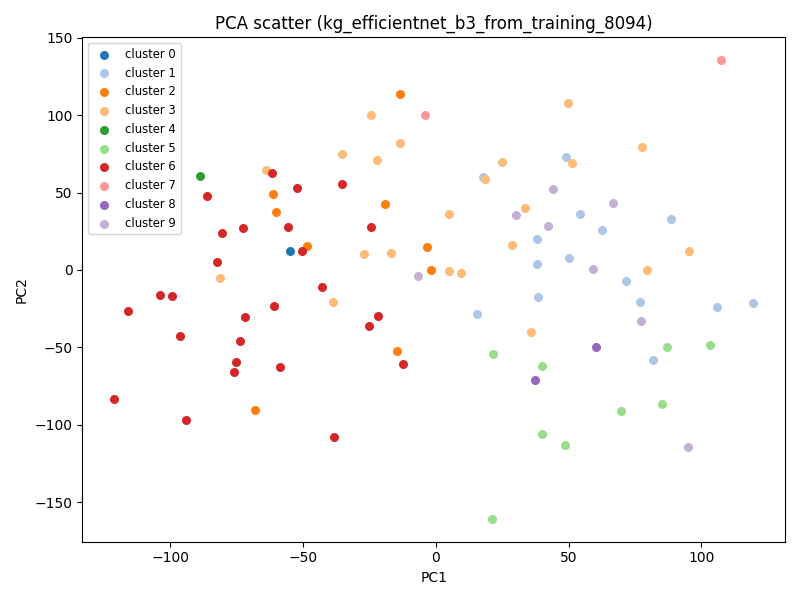

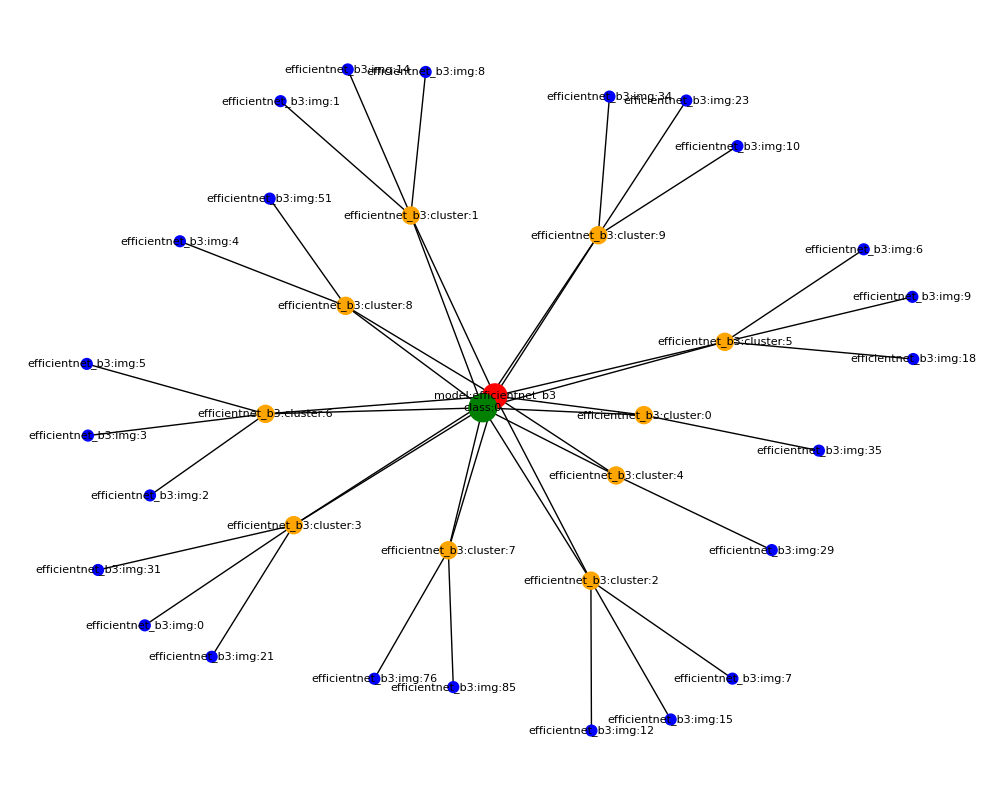


--- kg_efficientnet_b3_from_training_8182


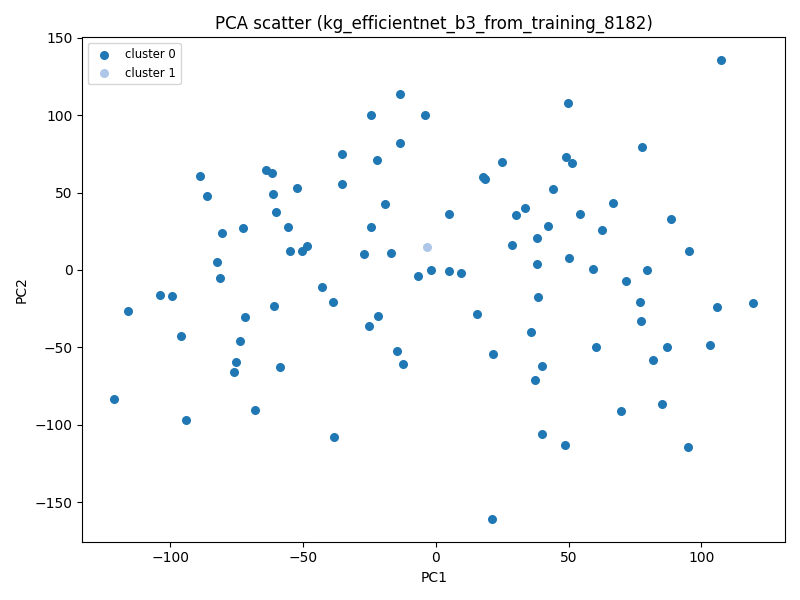

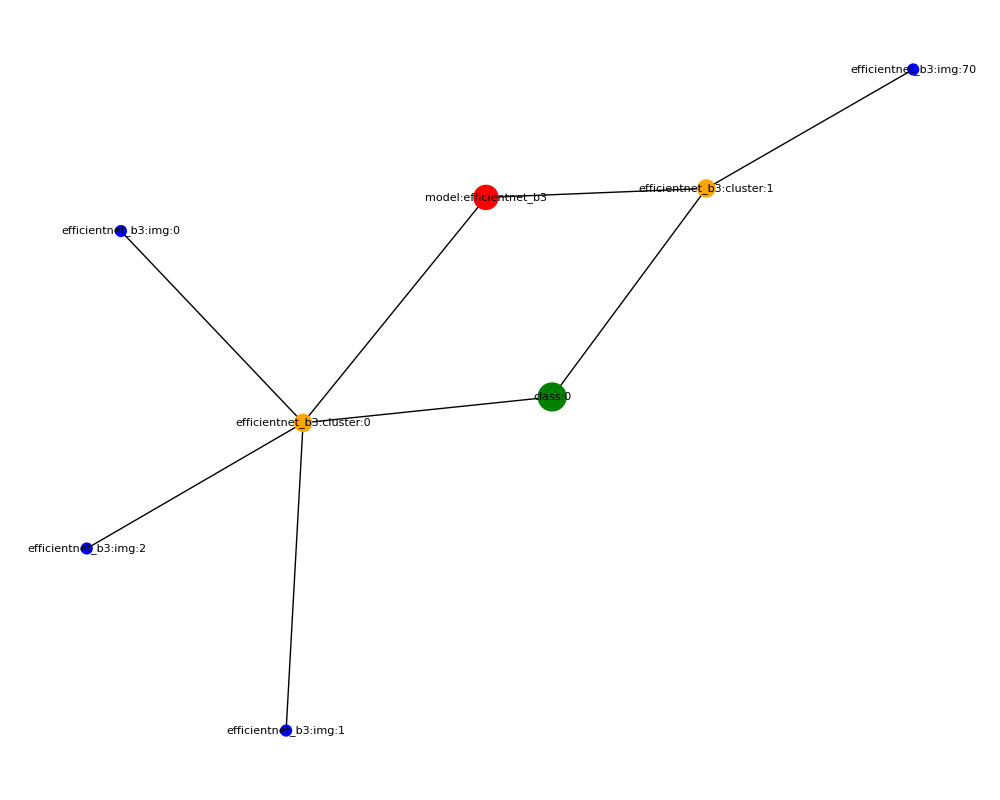


--- kg_efficientnet_b3_from_training_8262


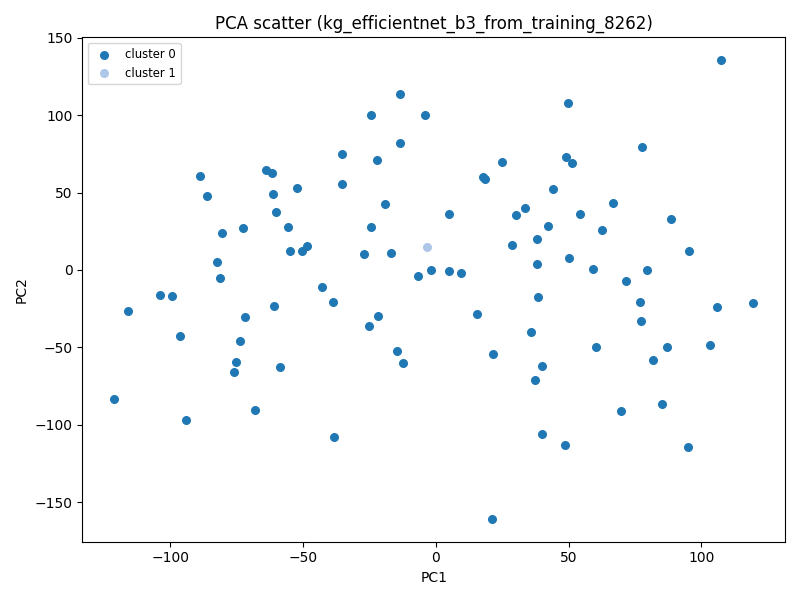

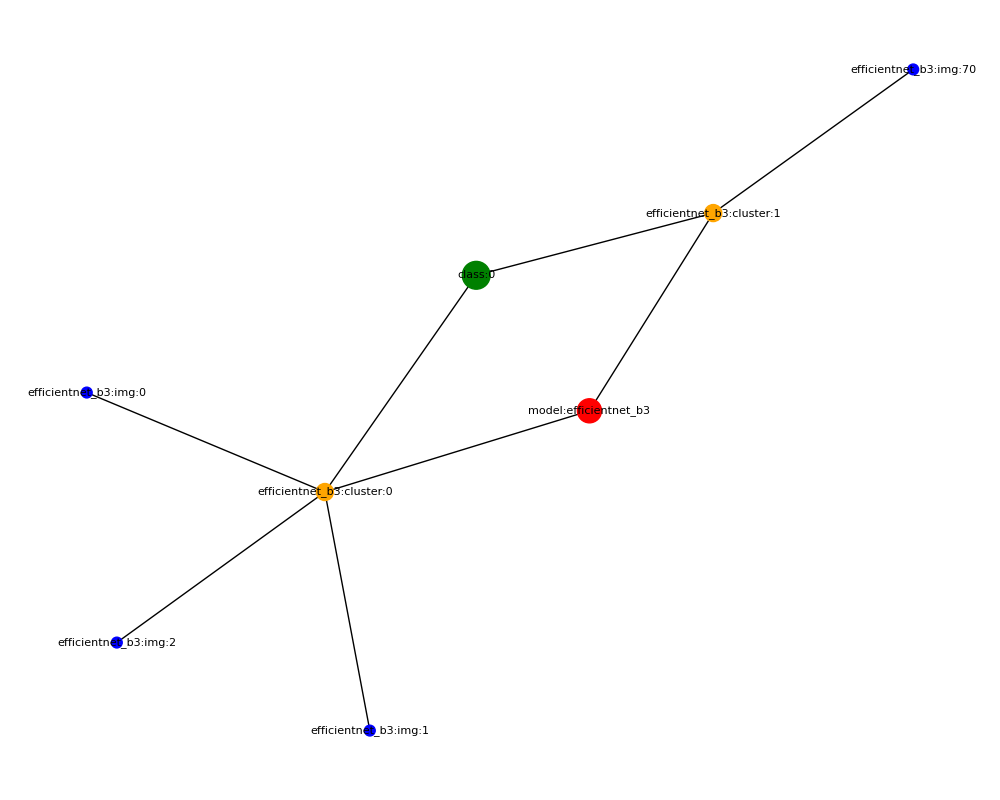


--- kg_efficientnet_b4_from_training_8096


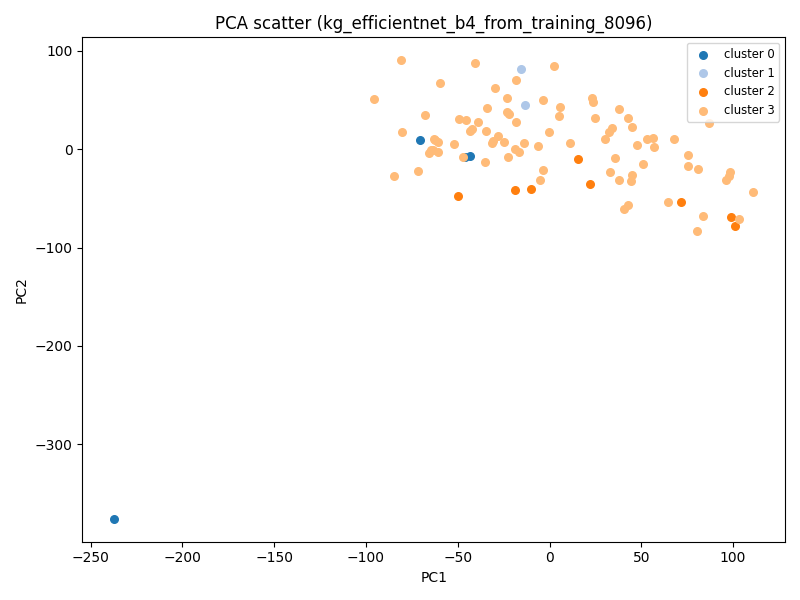

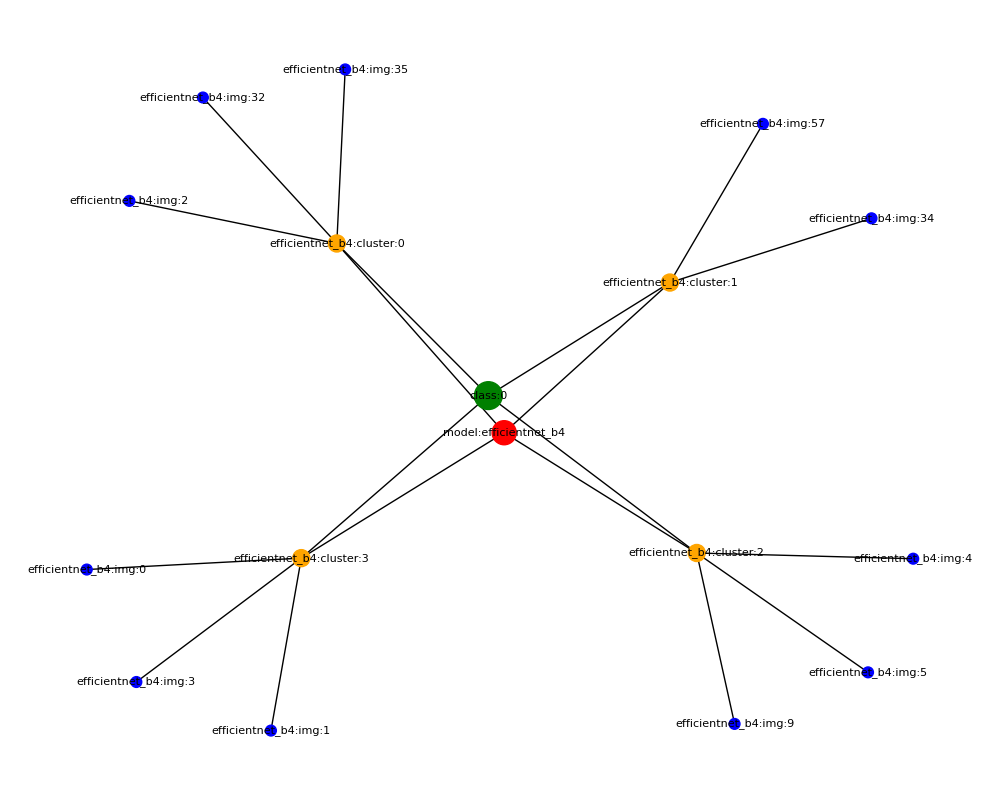


--- kg_efficientnet_b4_from_training_8183


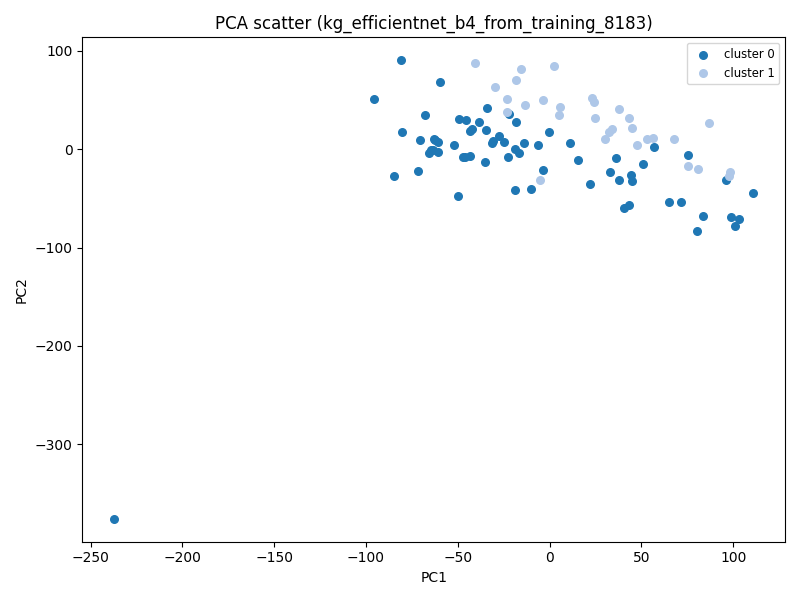

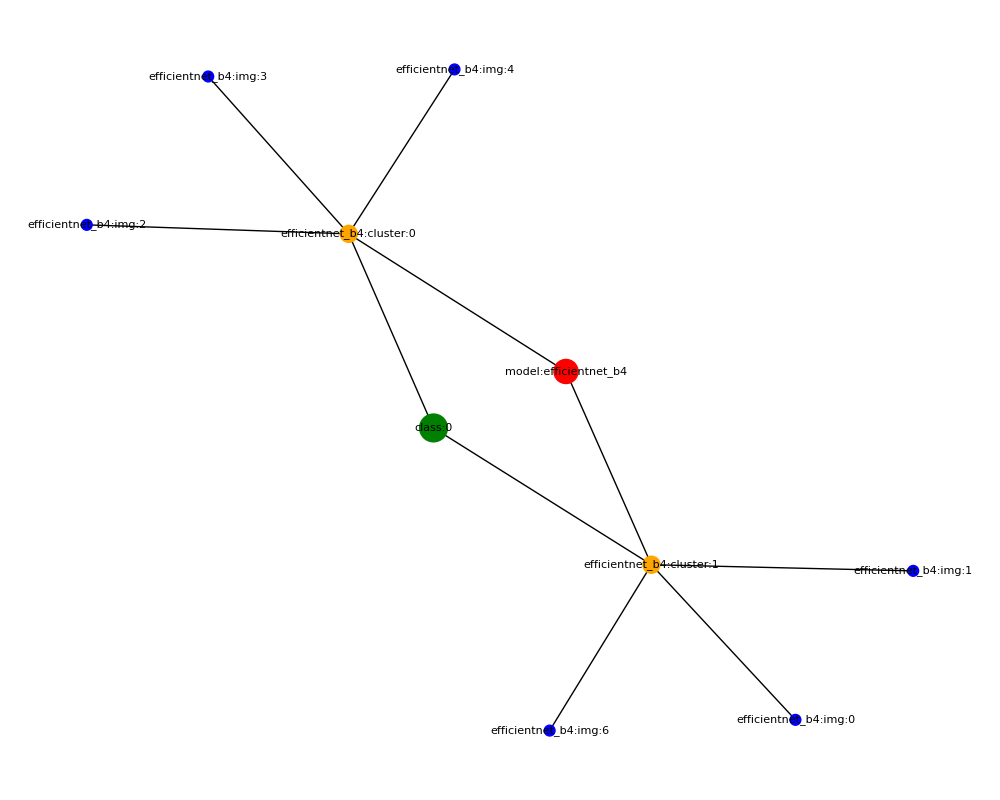


--- kg_efficientnet_b4_from_training_8263


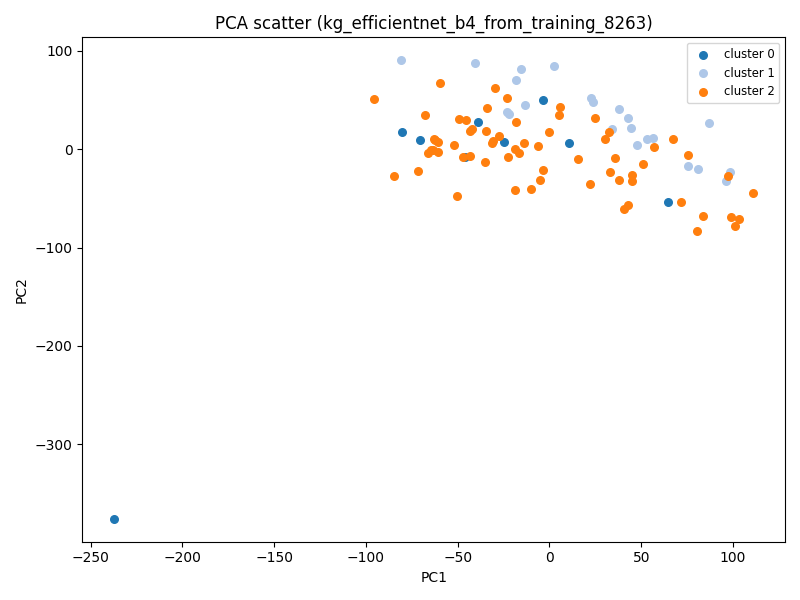

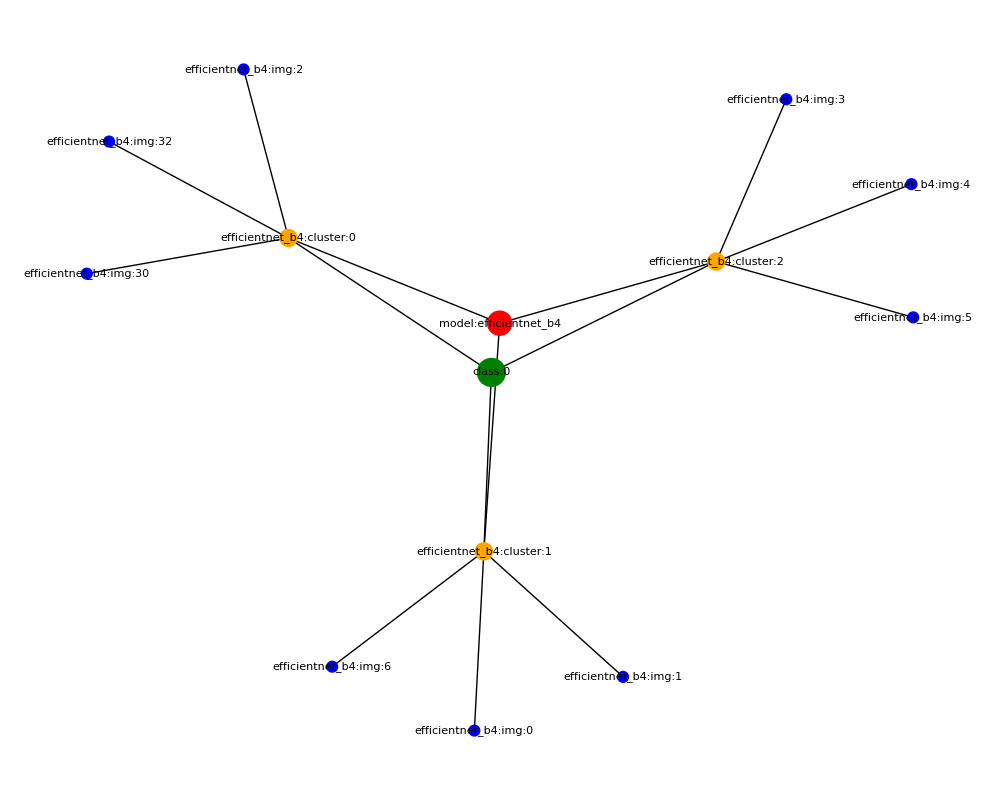


--- kg_gbcnet_from_training_8104


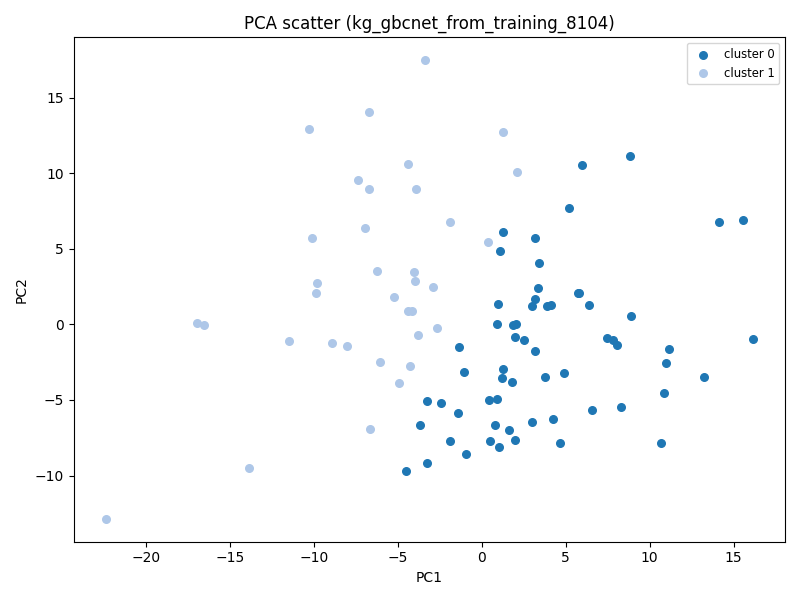

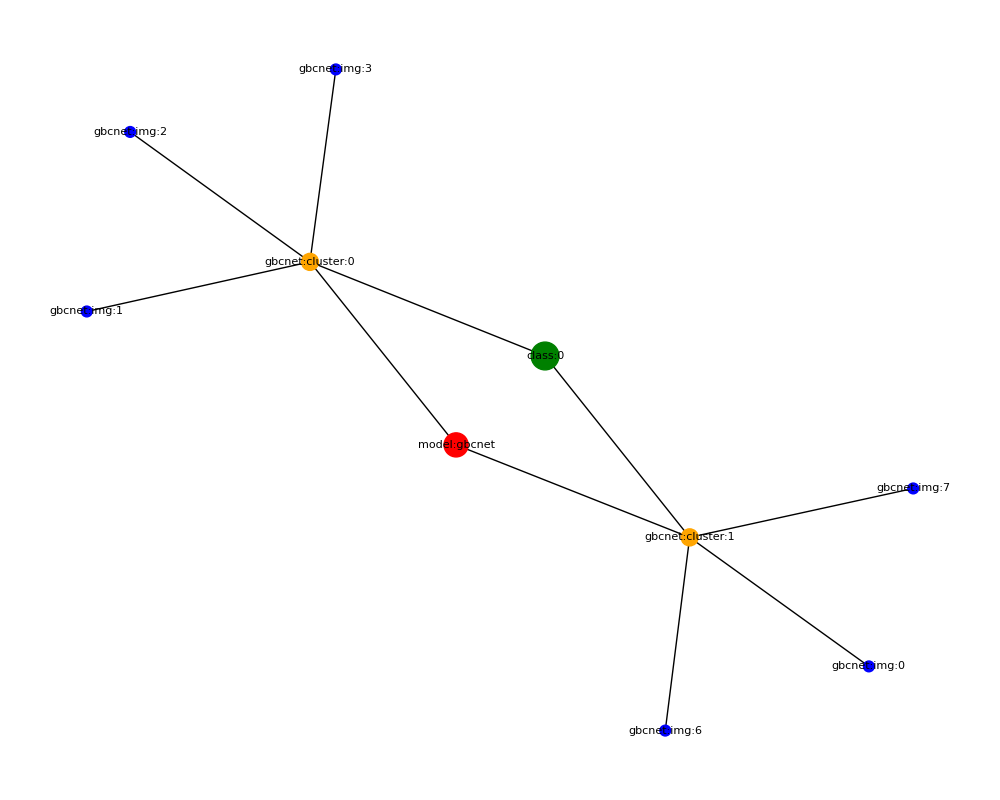


--- kg_gbcnet_from_training_8191


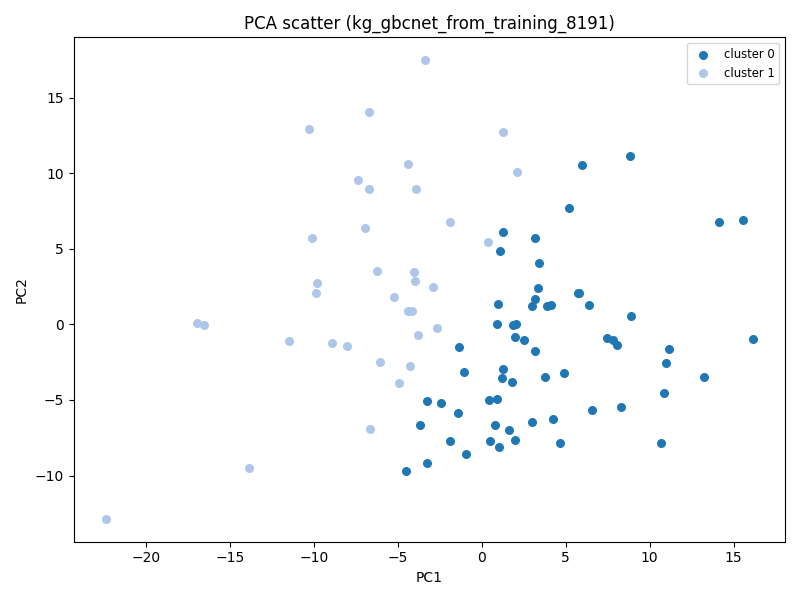

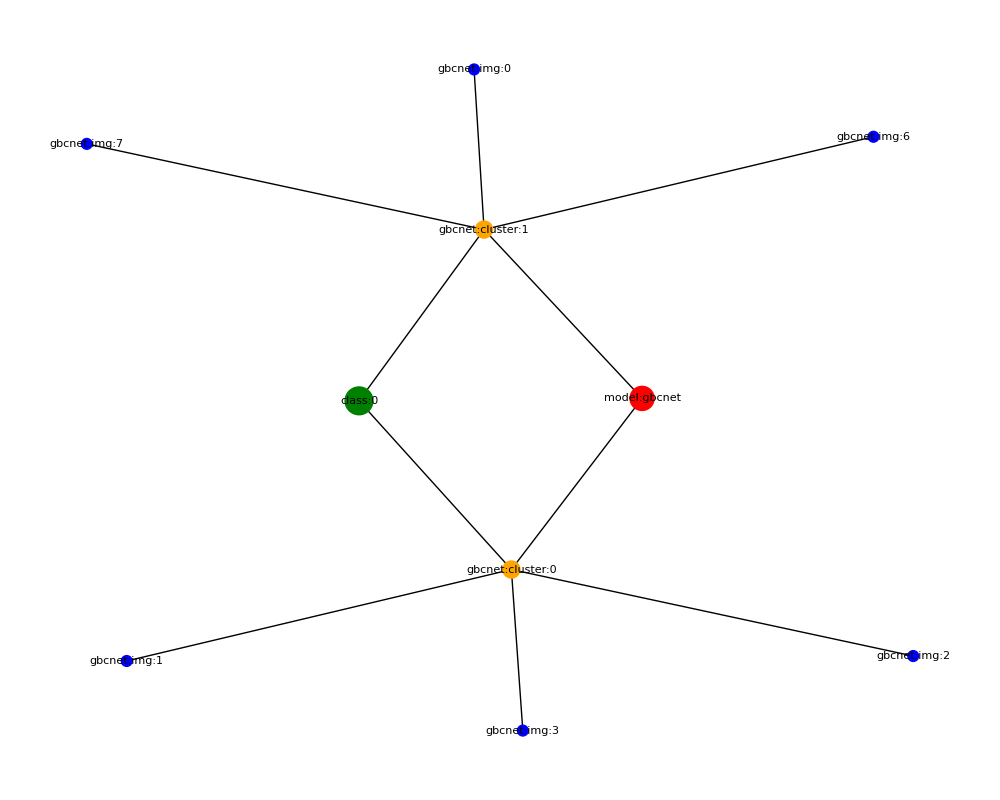


--- kg_gbcnet_from_training_8271


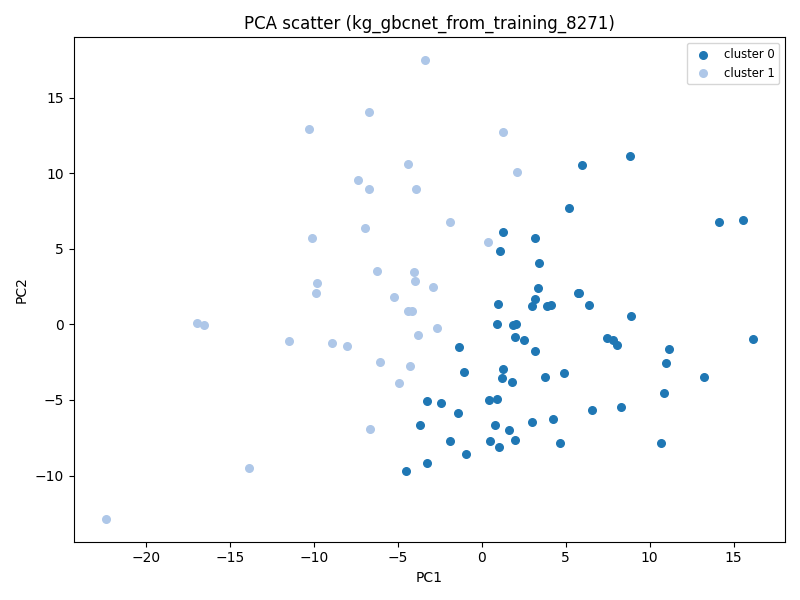

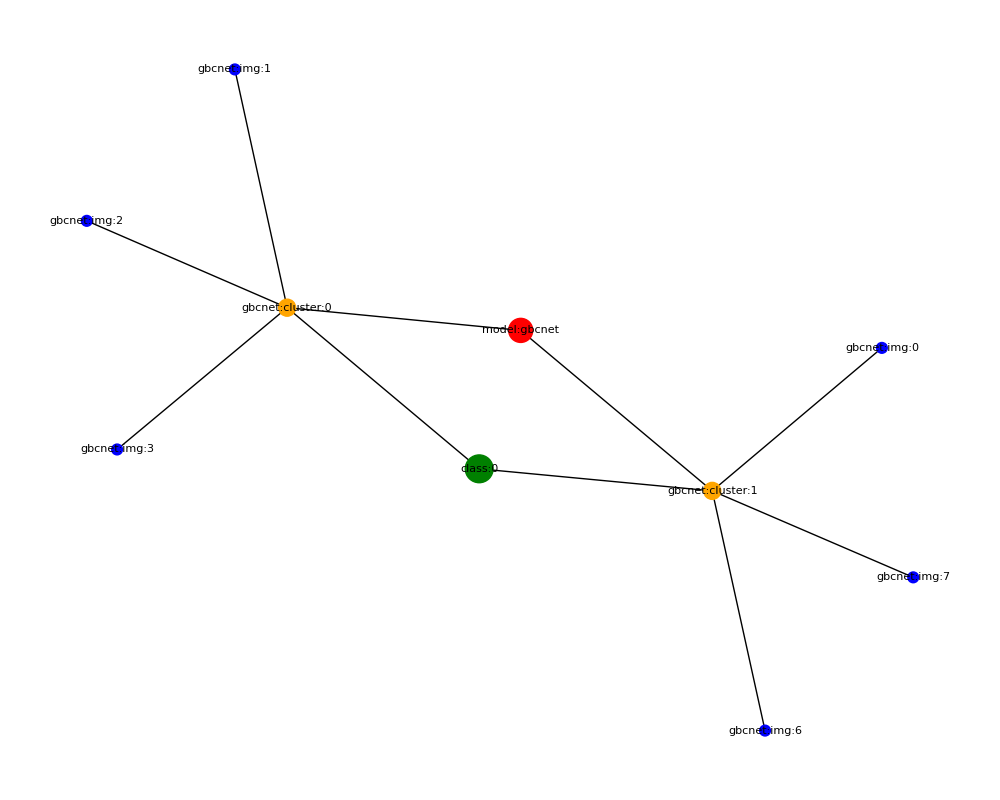


--- kg_mobilenet_v2_from_training_8101


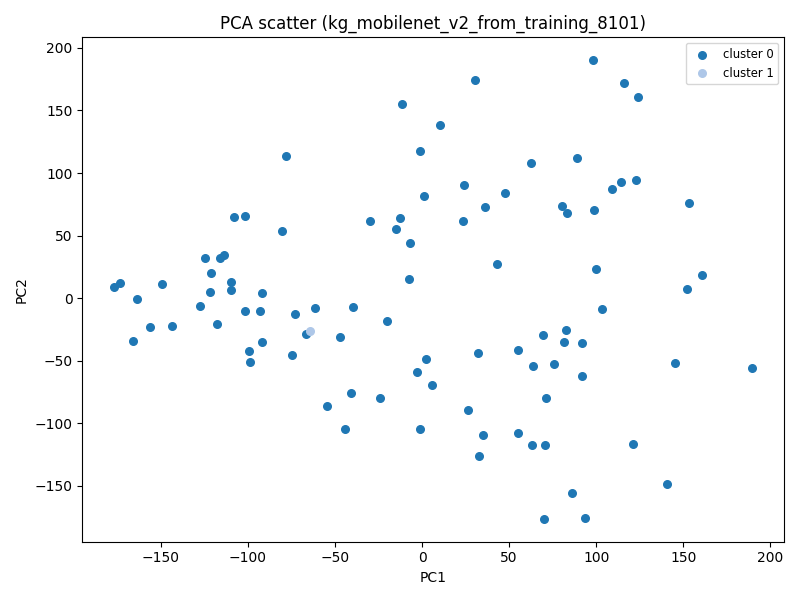

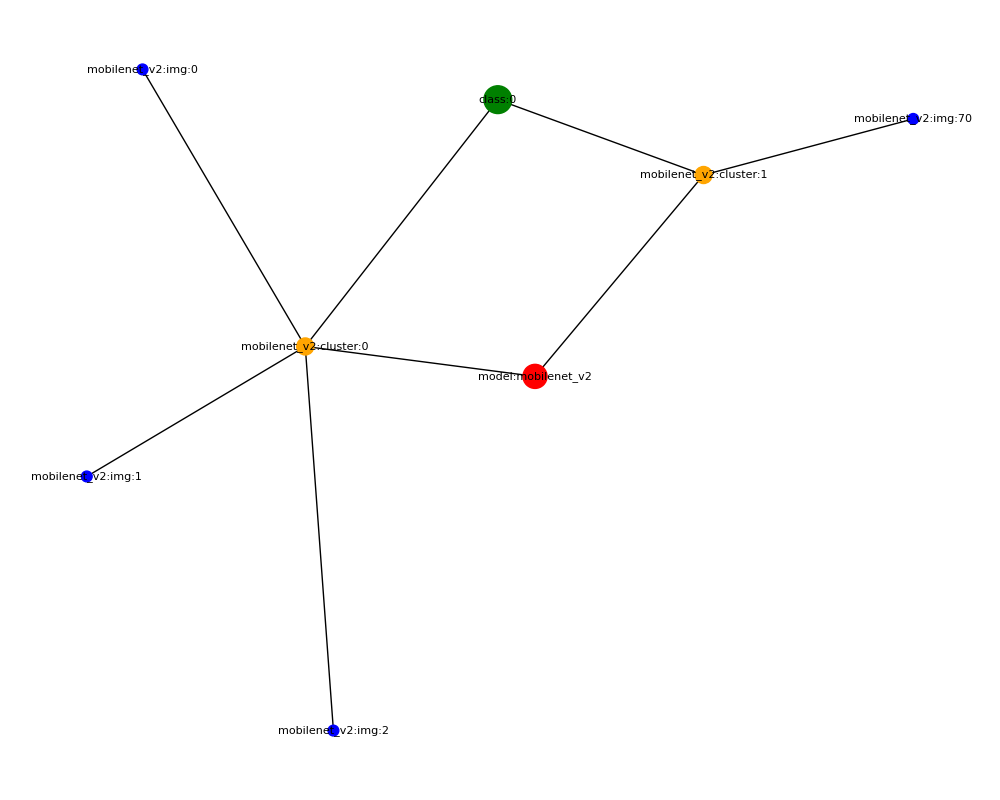


--- kg_mobilenet_v2_from_training_8189


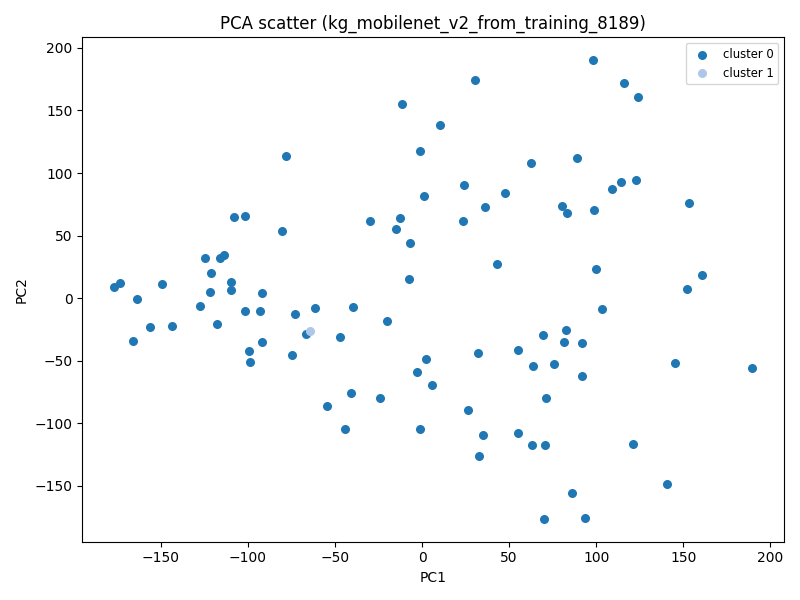

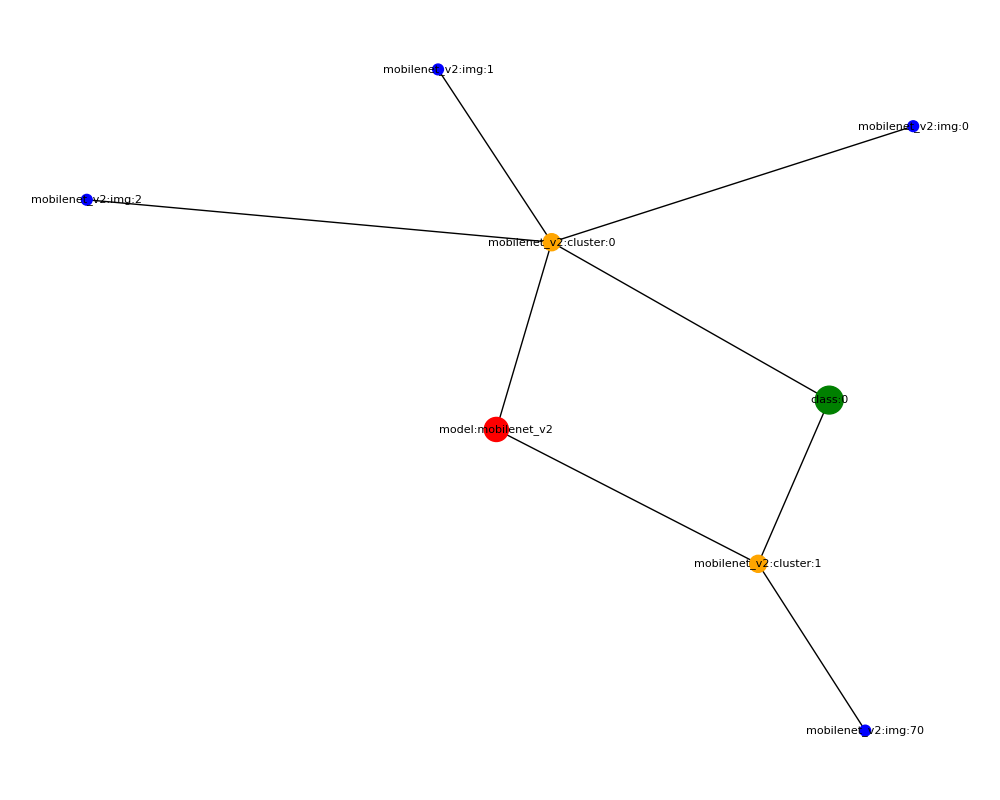


--- kg_mobilenet_v2_from_training_8269


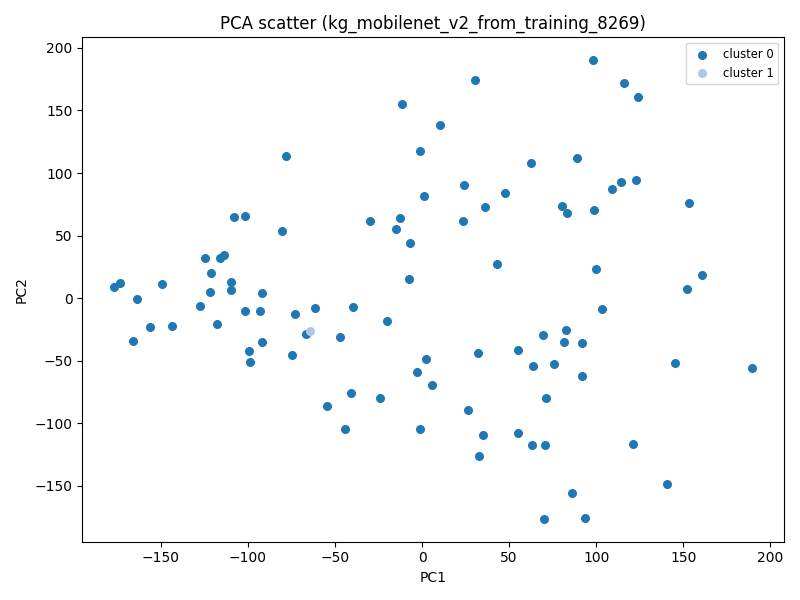

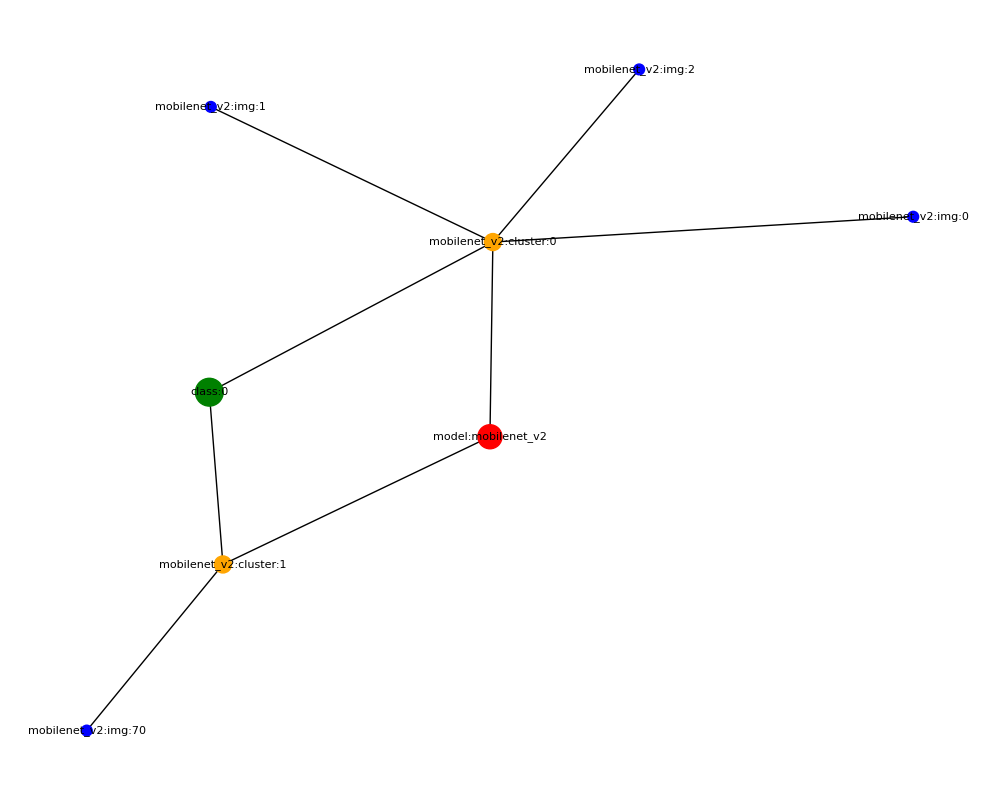


--- kg_resnet18_from_training_5272


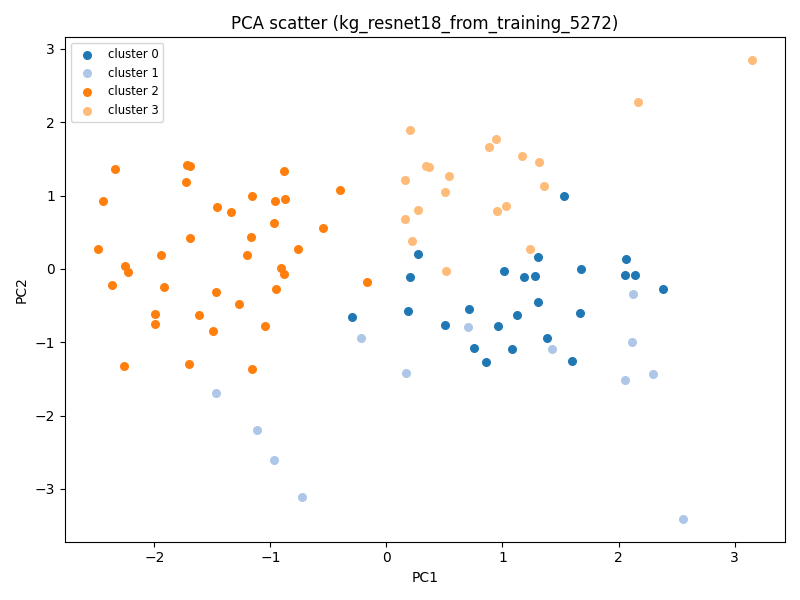

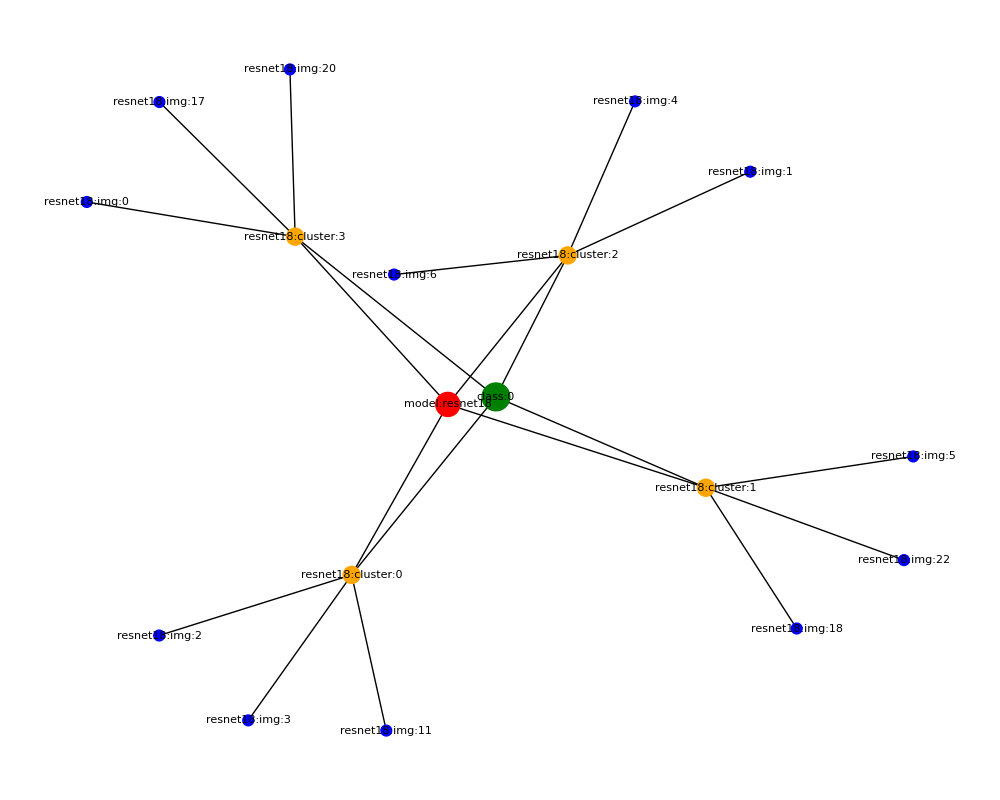


--- kg_resnet18_from_training_5744


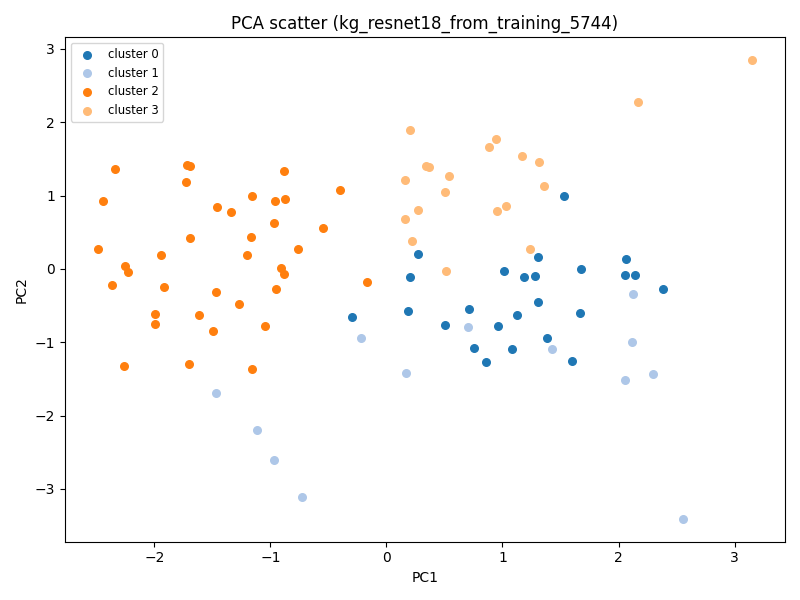

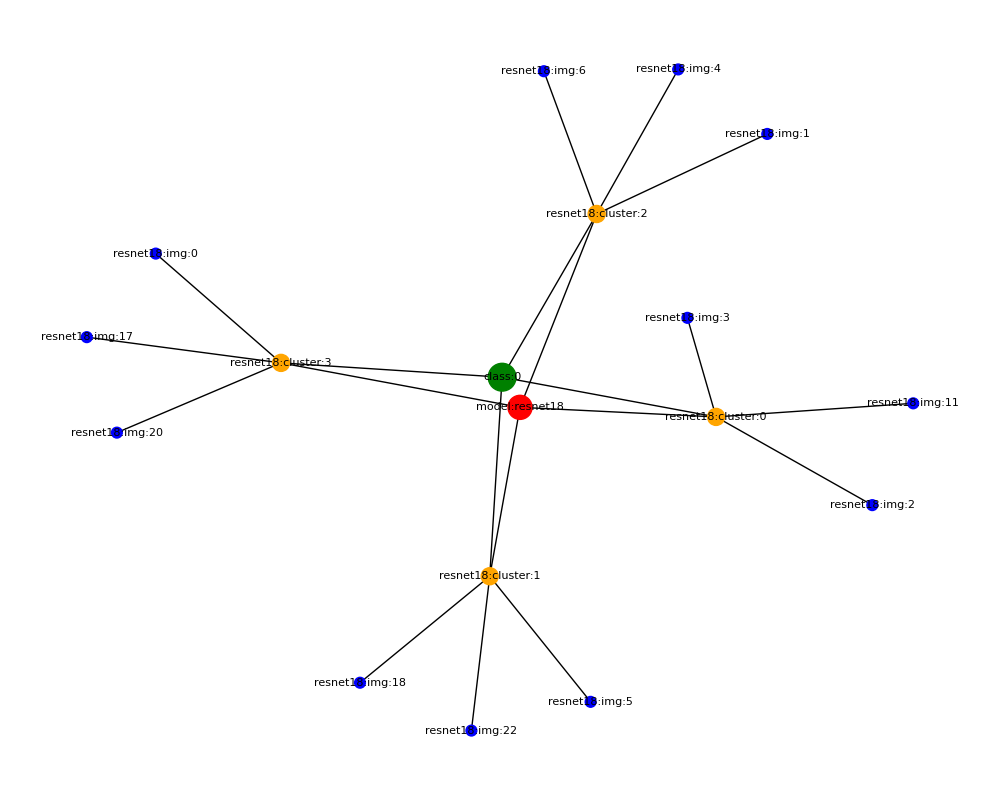


--- kg_resnet18_from_training_8089


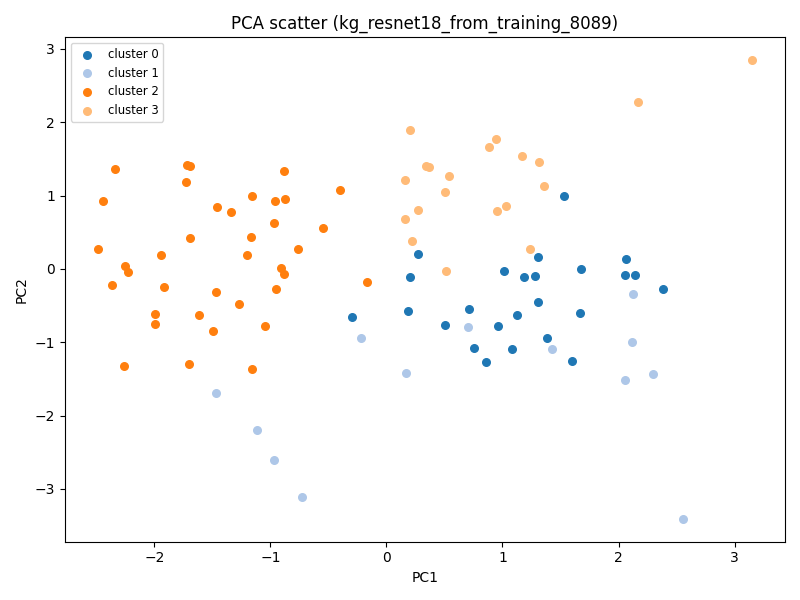

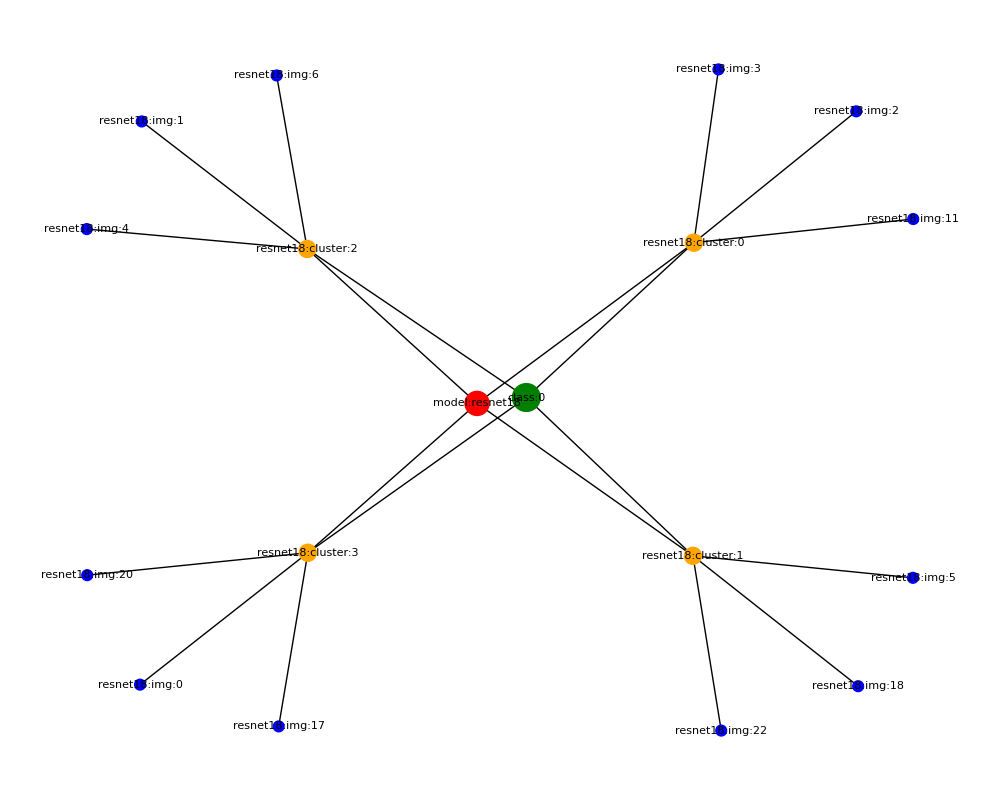


--- kg_resnet18_from_training_8177


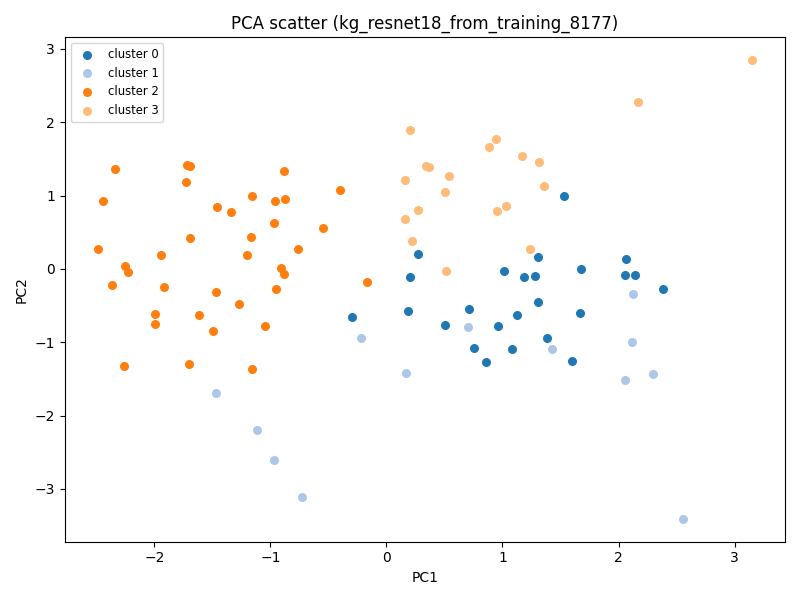

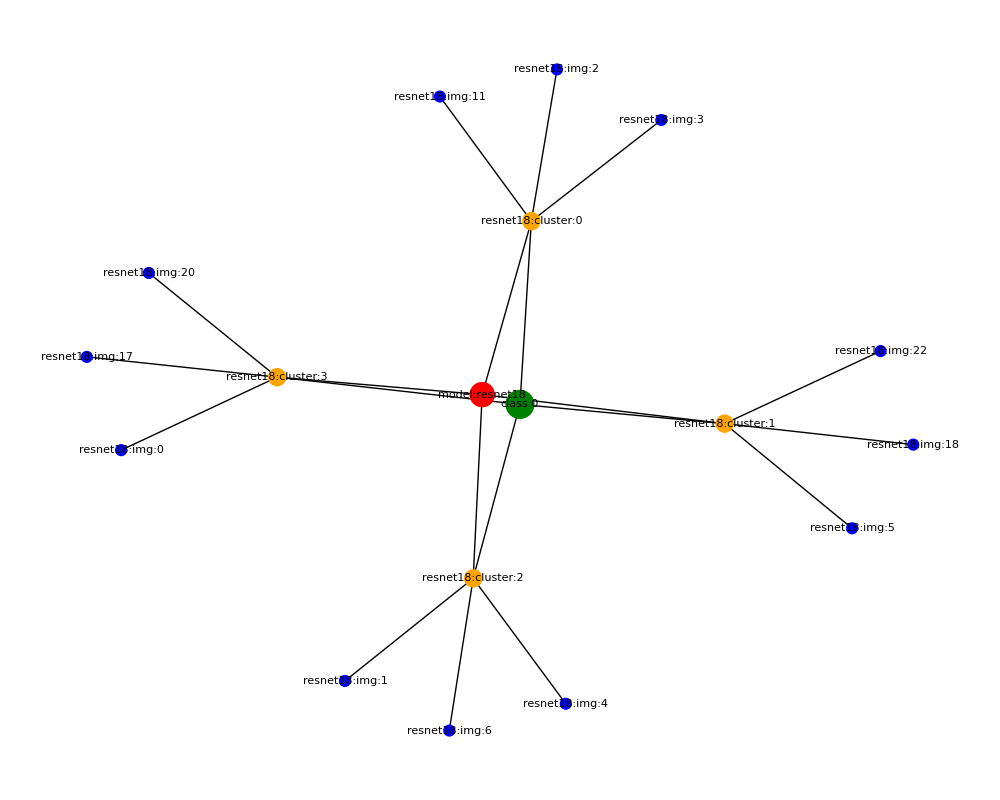


--- kg_resnet18_from_training_8258


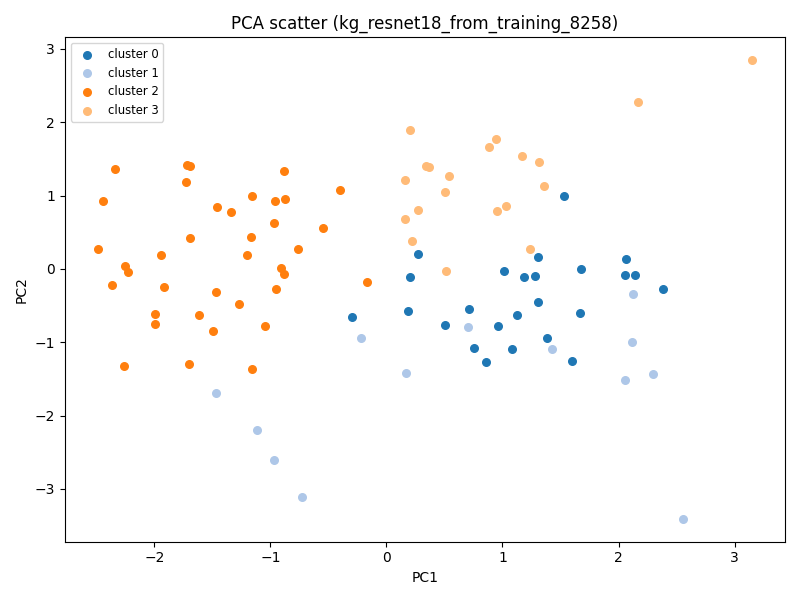

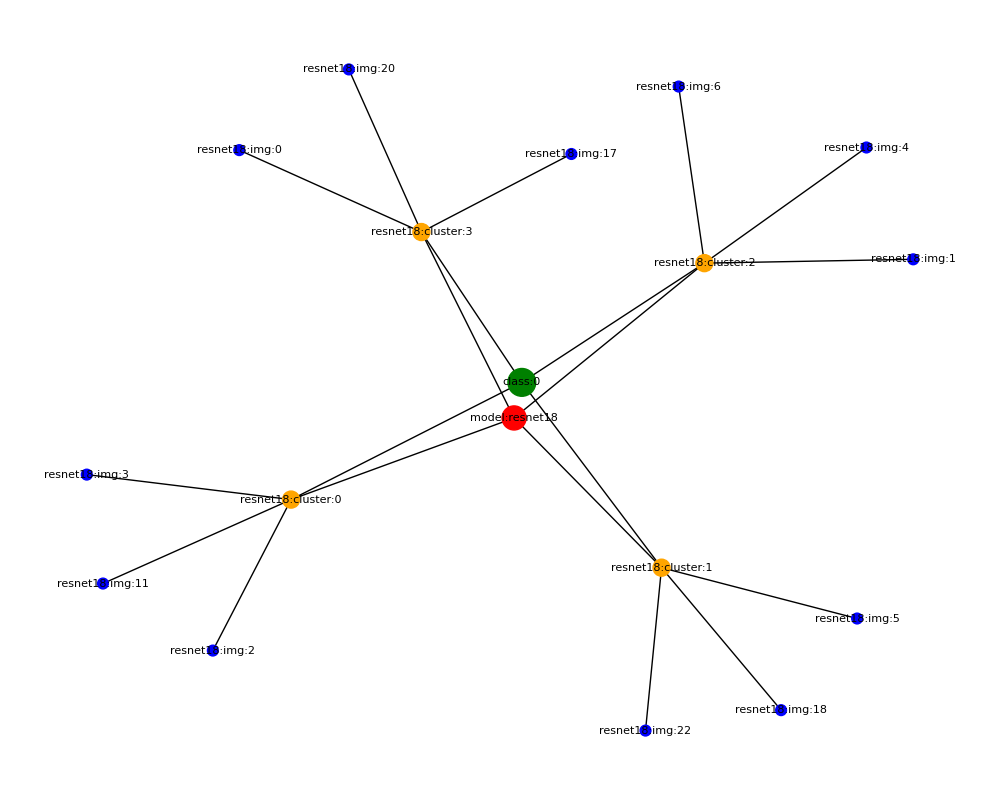


--- kg_resnet50_v1_from_training_8105


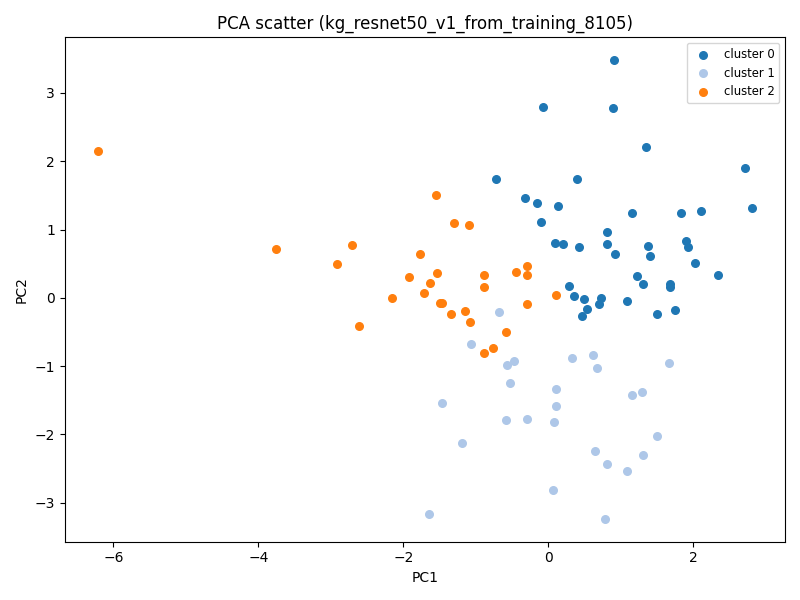

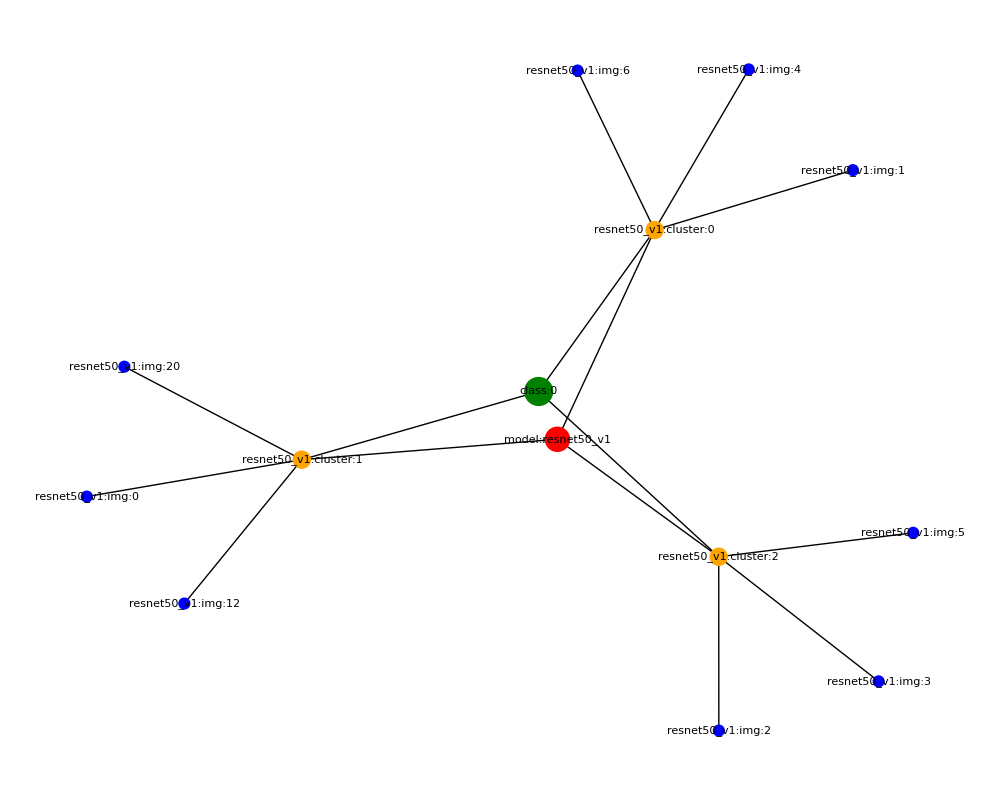


--- kg_resnet50_v1_from_training_8192


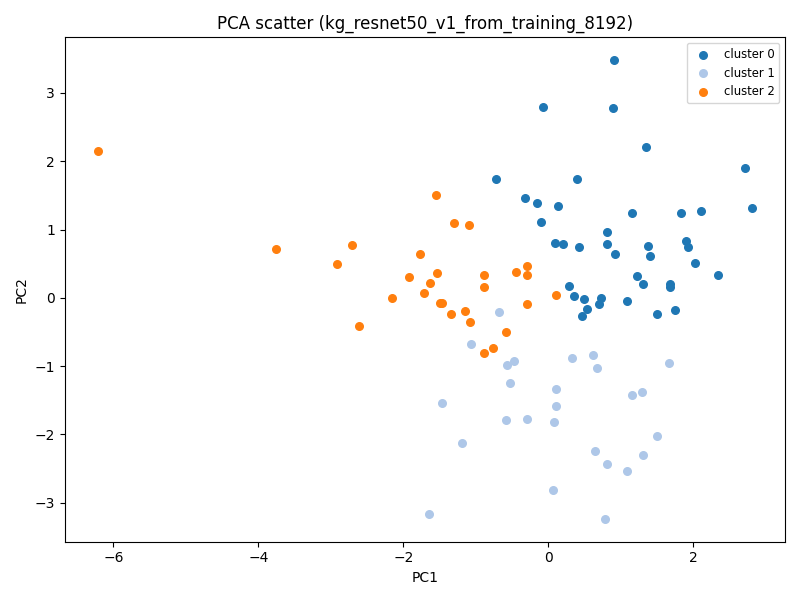

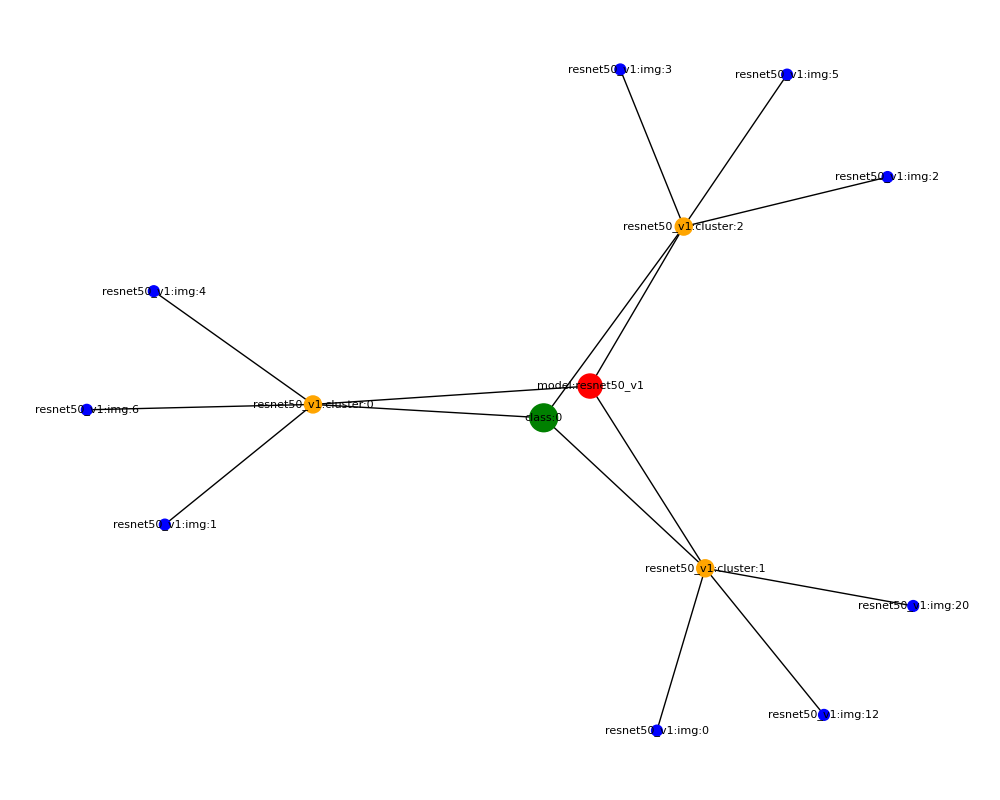


--- kg_resnet50_v1_from_training_8272


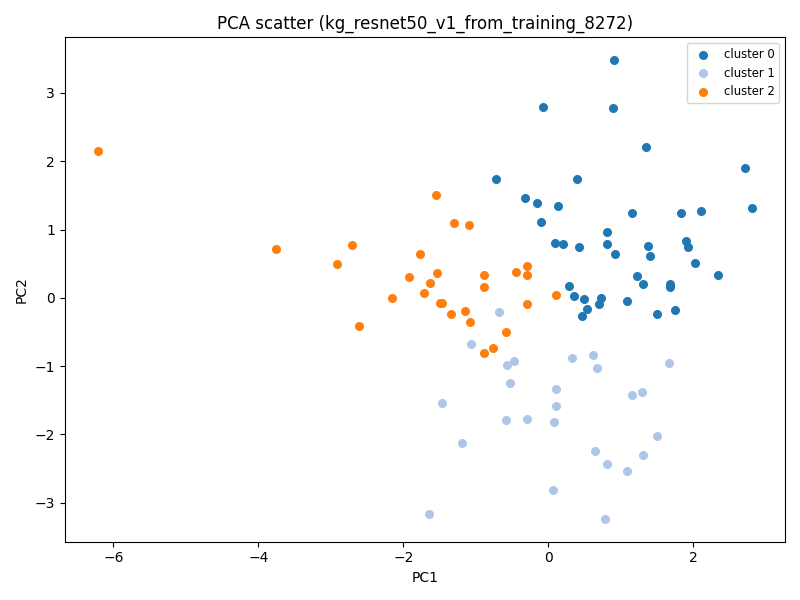

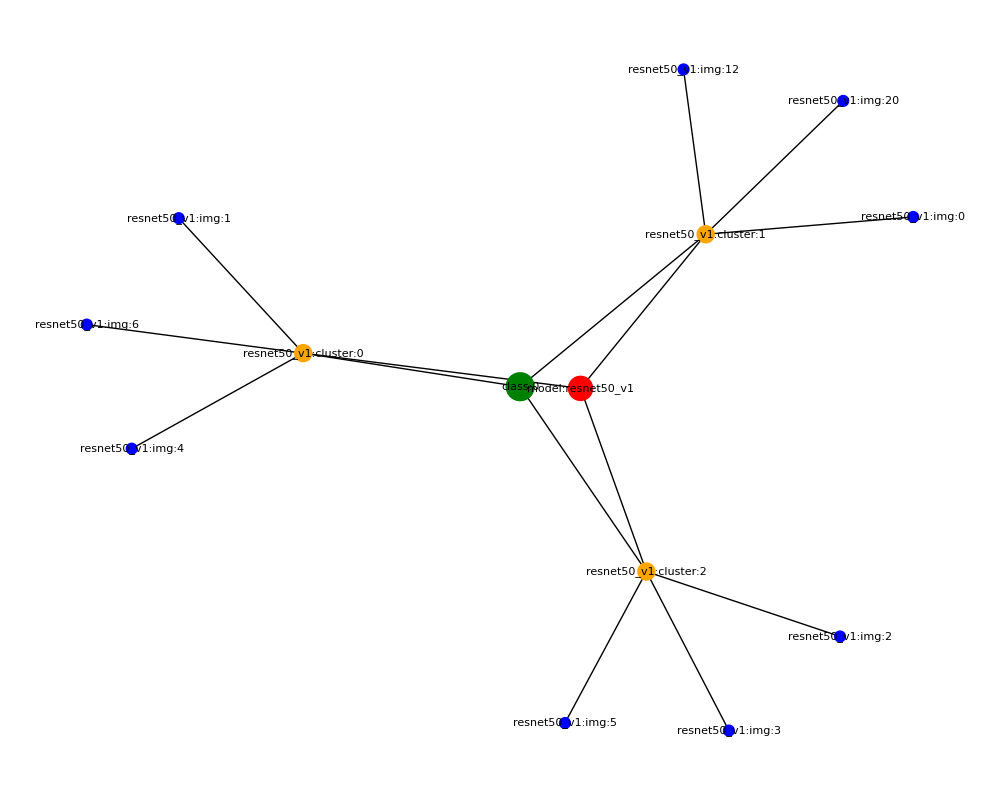


--- kg_resnet50_v2_from_training_8106


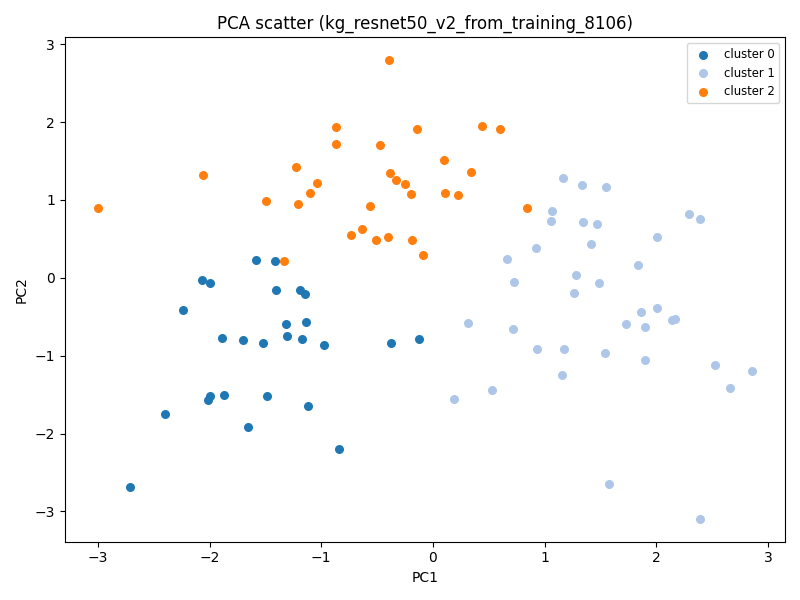

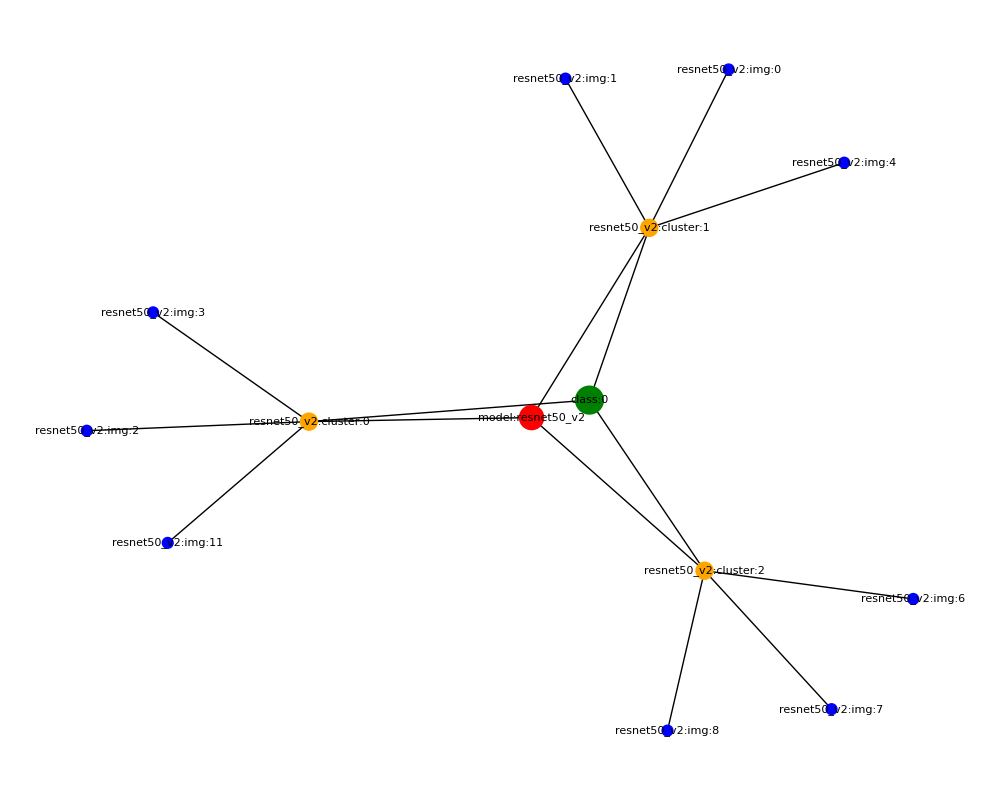


--- kg_resnet50_v2_from_training_8193


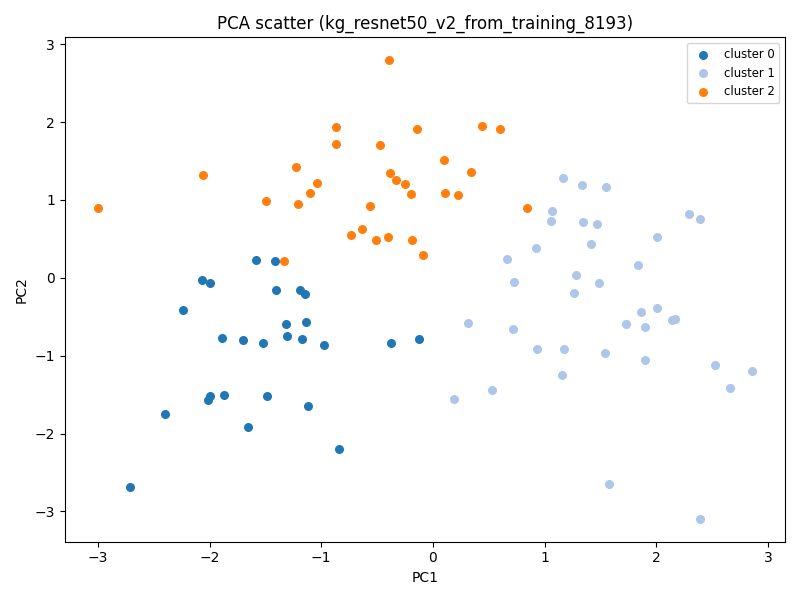

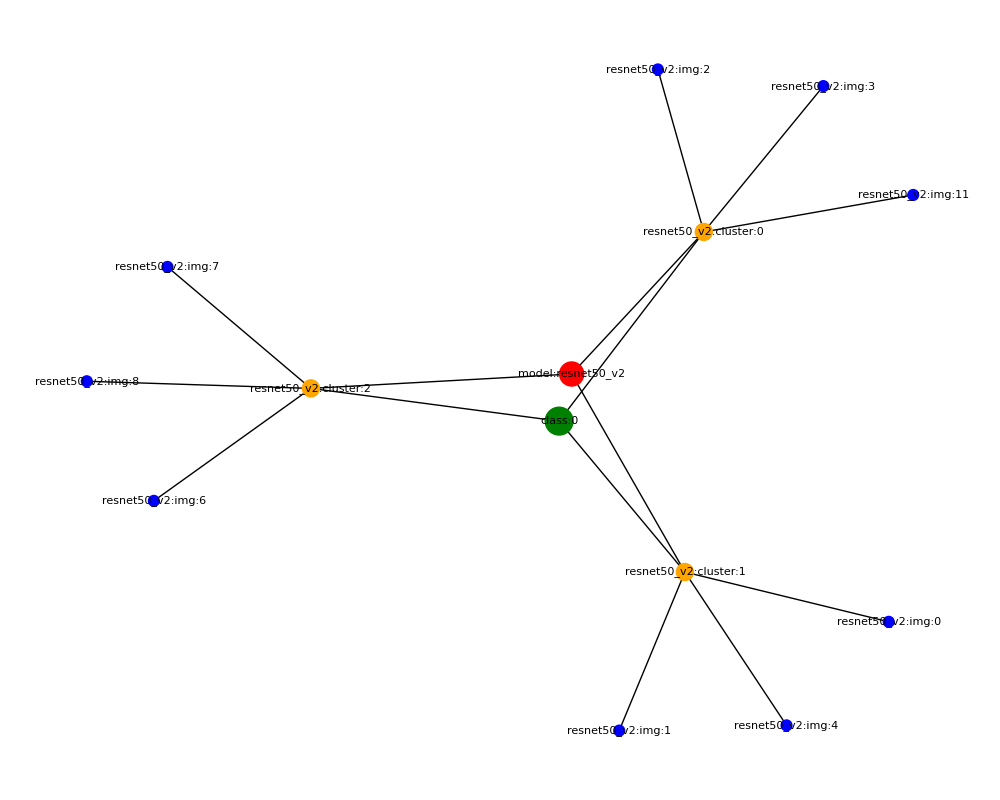


--- kg_resnet50_v2_from_training_8273


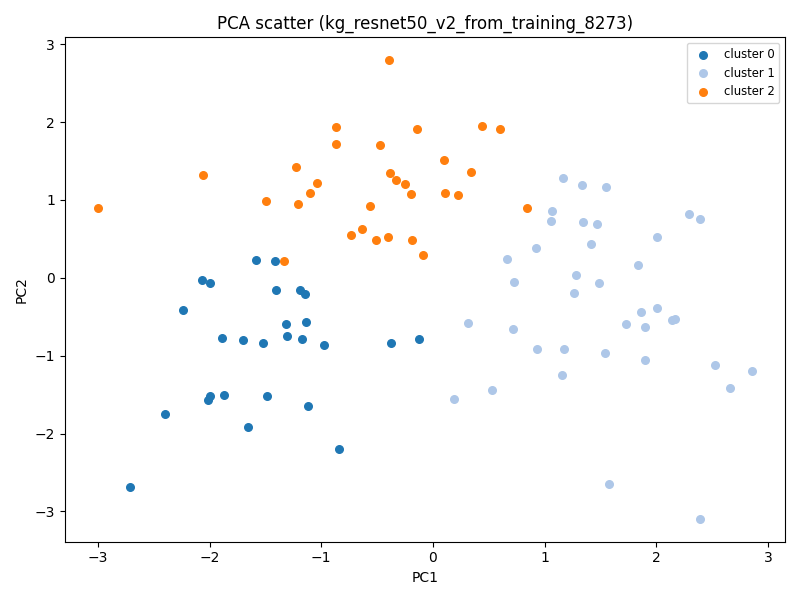

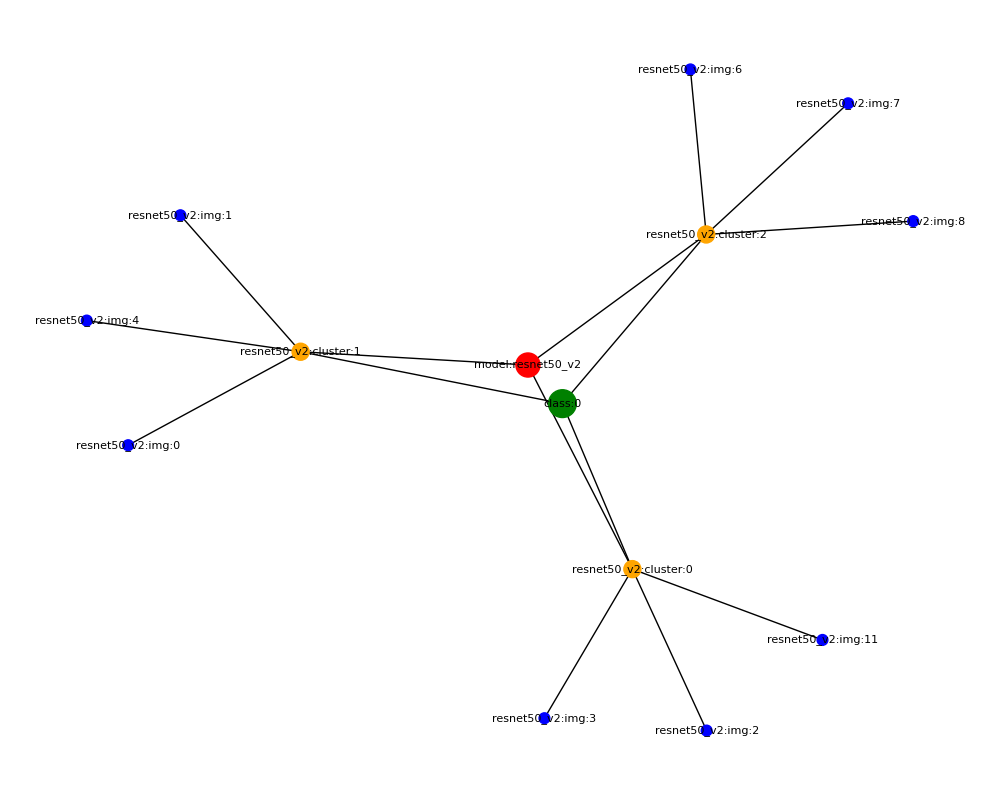


--- kg_shufflenet_v2_from_training_8102


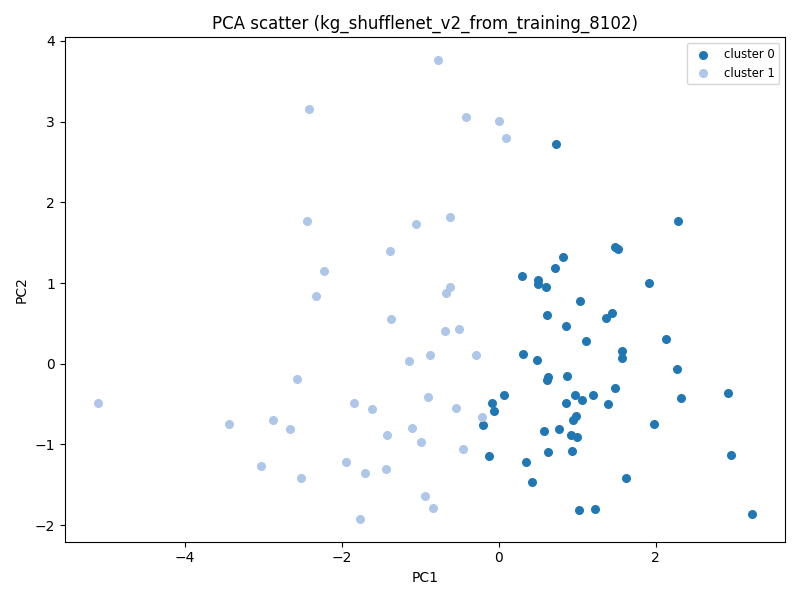

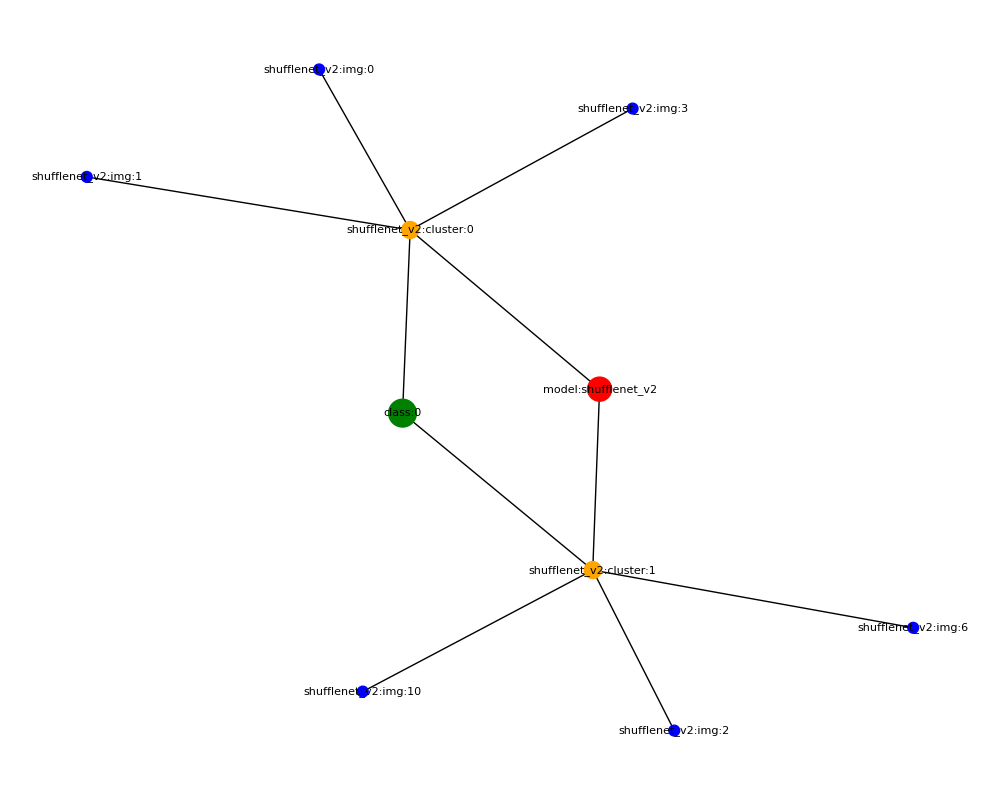


--- kg_shufflenet_v2_from_training_8190


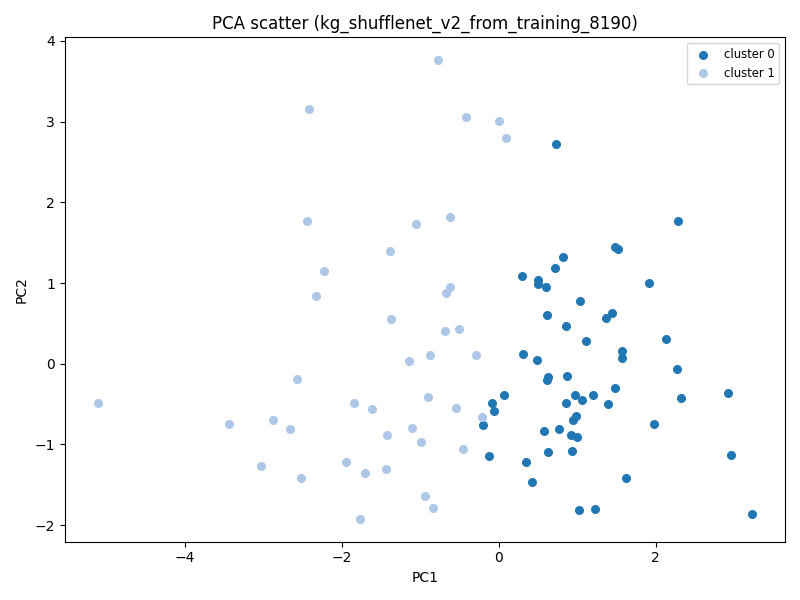

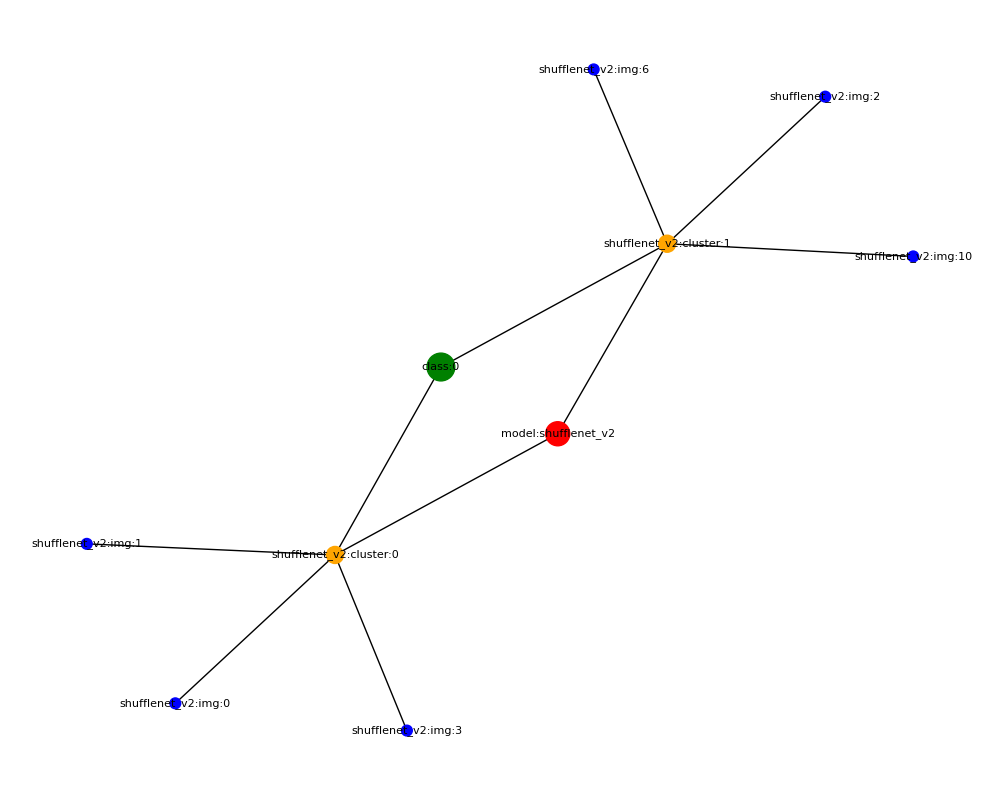


--- kg_shufflenet_v2_from_training_8270


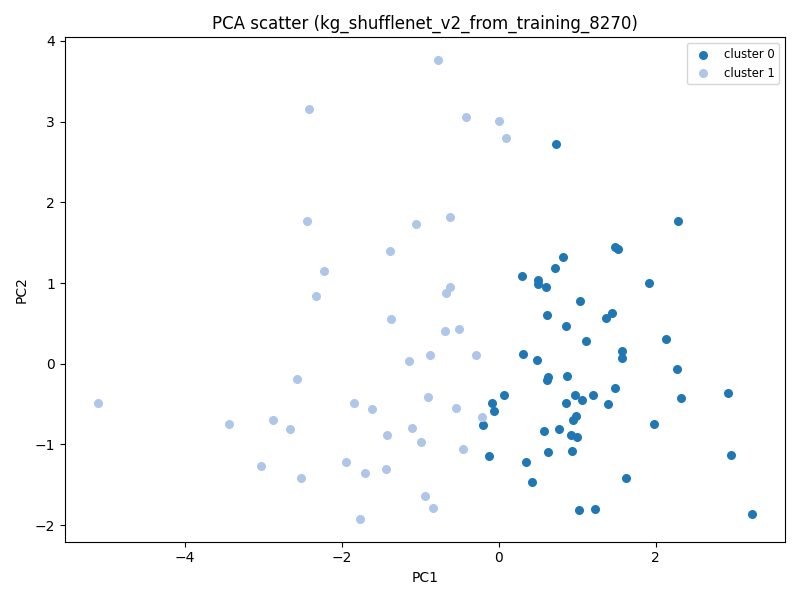

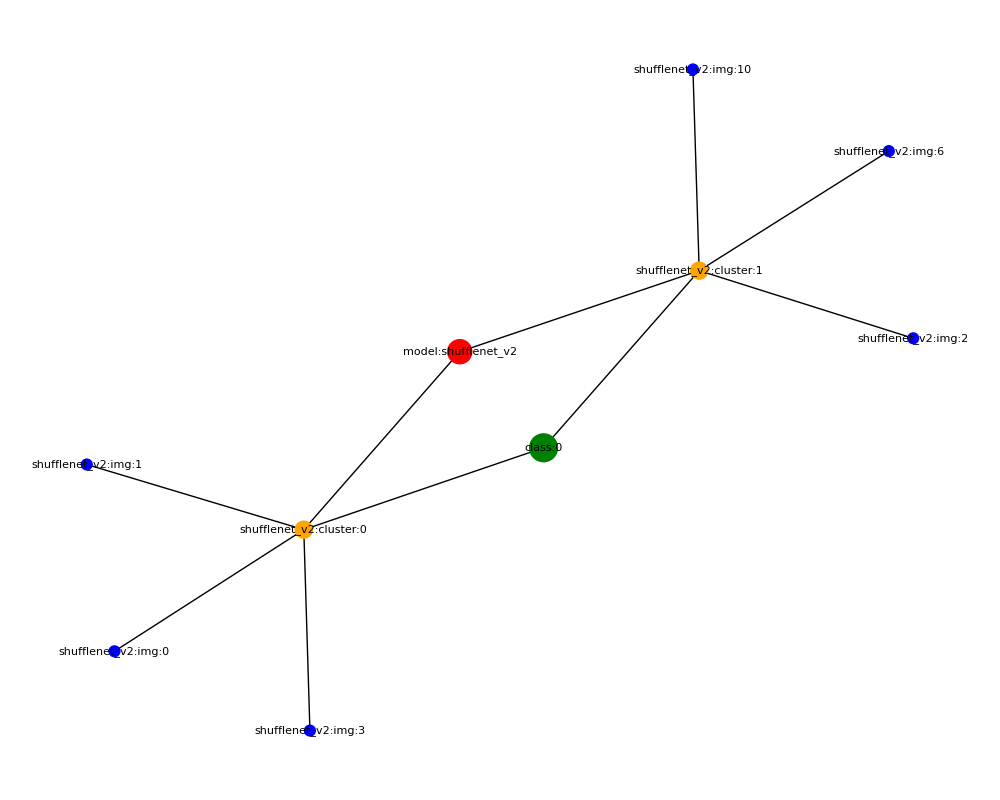


--- kg_squeezenet_from_training_8103


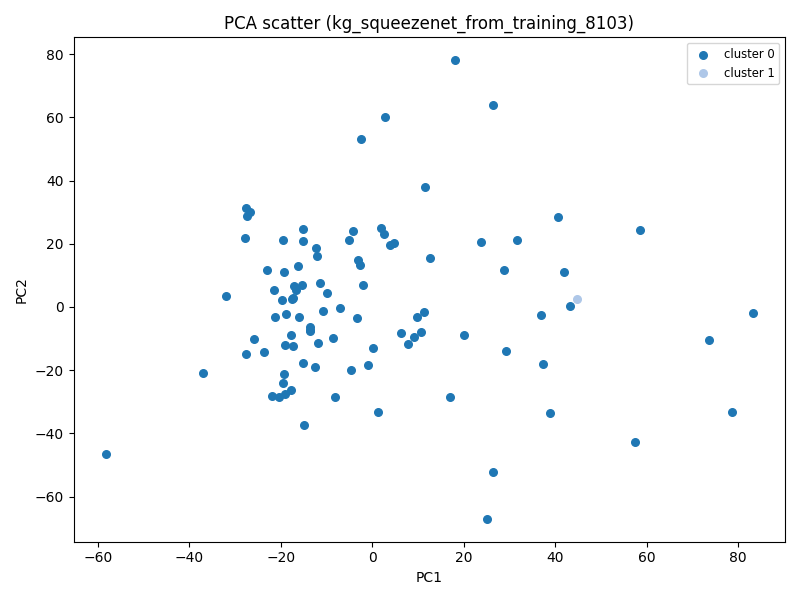

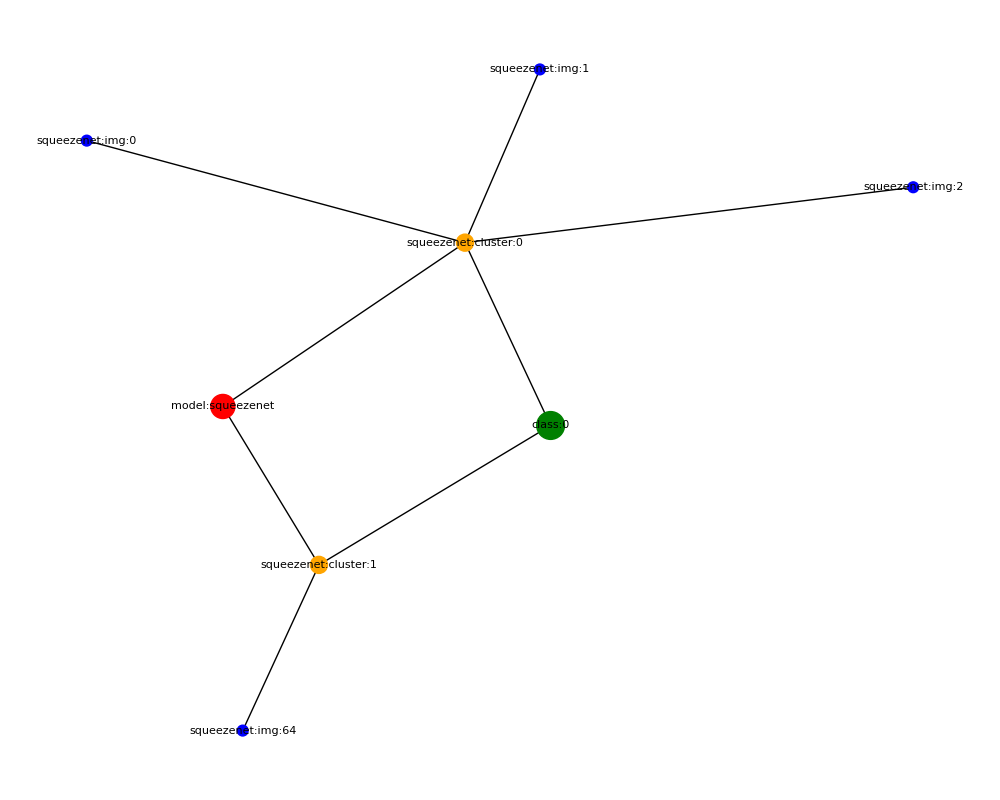


--- kg_squeezenet_from_training_8190


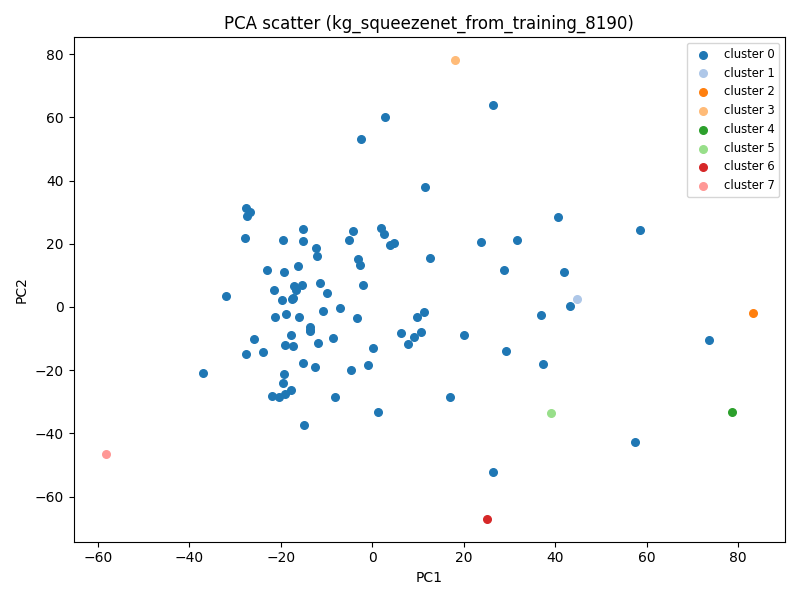

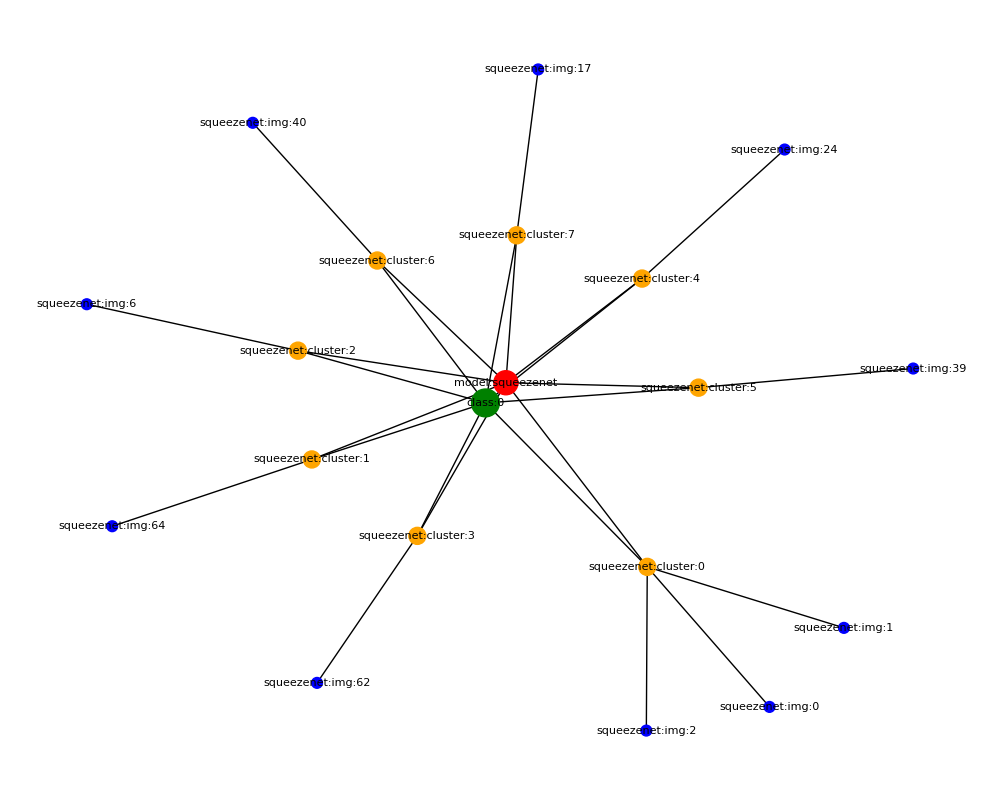


--- kg_squeezenet_from_training_8270


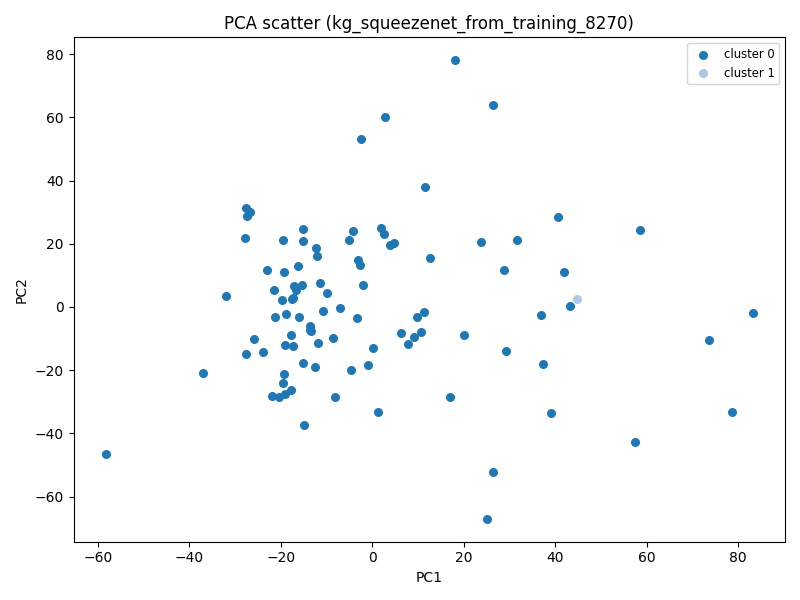

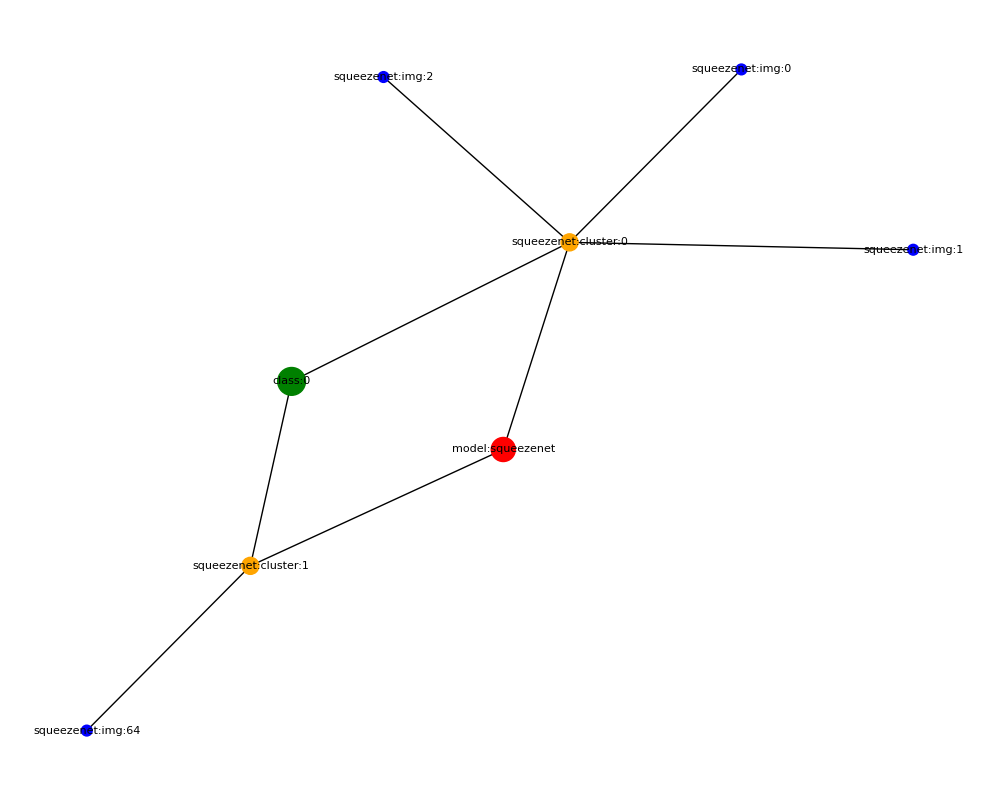


Done.


In [119]:
# Show PCA and network graphs for ALL model-concept KG artifacts
from IPython.display import display, Image as IPyImage

# Discover all prefixes by scanning for *_pca.png files
pca_files = sorted(OUT_DIR.glob('kg_*_from_training_*_pca.png'))
all_prefixes = [p.name.replace('_pca.png', '') for p in pca_files]

if not all_prefixes:
    print('No model-concept KG PCA artifacts found in', OUT_DIR)
else:
    print(f'Found {len(all_prefixes)} KG prefixes; displaying PCA and network PNG for each...')
    for pref in all_prefixes:
        print('\n---', pref)
        p_pca = OUT_DIR / f"{pref}_pca.png"
        p_png = OUT_DIR / f"{pref}.png"
        if p_pca.exists():
            try:
                display(IPyImage(filename=str(p_pca)))
            except Exception as e:
                print('Could not display PCA:', e)
        else:
            print('PCA png missing:', p_pca)
        if p_png.exists():
            try:
                display(IPyImage(filename=str(p_png)))
            except Exception as e:
                print('Could not display network PNG:', e)
        else:
            print('Network png missing:', p_png)
print('\nDone.')